# $$Contents$$
* [1. Feature Engeneering]((#$$Feature Engeneering$$)
* [2. Preprocessing]((#$$Preprocessing$$)
* [3. Modelling]((#$$Modelling$$)
* [4. Submit]((#$$Submit$$)

In [16]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import pandas as pd

  Using cached graphviz-0.19.1-py3-none-any.whl (46 kB)


# $$Feature Engeneering$$

In [67]:
data = pd.read_csv('C:/Users/user/Desktop/Pump_it_Up/Data_processed_new_coords.csv', index_col=0)

In [68]:
data

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,labels,amount_tsh_bool,month_recorded,...,water_quality_encoded,quality_group_encoded,quantity_encoded,basin_encoded,region_encoded,lga_encoded,ward_encoded,extraction_type_encoded,source_encoded,waterpoint_type_encoded
0,1390.0,34.938093,-9.856322,11,5,109.0,1999.0,True,False,3,...,7,2,1,1,3,51,1429,3,8,1
1,1399.0,34.698766,-2.147466,20,2,280.0,2010.0,True,True,3,...,7,2,2,4,9,103,1581,3,5,1
2,686.0,37.460664,-3.821329,21,4,250.0,2009.0,True,False,2,...,7,2,1,5,8,108,1629,3,0,2
3,263.0,38.486161,-11.155298,90,63,58.0,1986.0,True,True,1,...,7,2,0,7,12,87,1576,14,3,2
4,1328.8,31.130847,-1.825359,18,1,264.0,2005.4,True,True,7,...,7,2,4,4,4,26,1692,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,34.0,38.852669,-6.582841,6,1,20.0,1988.0,False,True,2,...,7,2,1,8,14,3,2087,7,6,1
14846,1178.4,37.451633,-5.350428,4,7,2960.0,1994.0,False,False,3,...,5,5,2,5,20,33,1454,8,7,4
14847,1476.0,34.739804,-4.585587,13,2,200.0,2010.0,False,True,3,...,7,2,2,0,18,109,2000,3,0,1
14848,998.0,35.432732,-10.584159,10,2,150.0,2009.0,False,True,2,...,7,2,2,1,16,111,1072,3,6,1


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gps_height                 74250 non-null  float64
 1   longitude                  74250 non-null  float64
 2   latitude                   74250 non-null  float64
 3   region_code                74250 non-null  int64  
 4   district_code              74250 non-null  int64  
 5   population                 74250 non-null  float64
 6   construction_year          74250 non-null  float64
 7   labels                     74250 non-null  bool   
 8   amount_tsh_bool            74250 non-null  bool   
 9   month_recorded             74250 non-null  int64  
 10  funder_encoded             74250 non-null  int64  
 11  installer_encoded          74250 non-null  int64  
 12  scheme_management_encoded  74250 non-null  int64  
 13  scheme_name_encoded        74250 non-null  int

In [82]:
data_labels = pd.read_csv('C:/Users/user/Desktop/Pump_it_Up/y_train.csv', index_col=0)

In [83]:
data_labels

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional
...,...
60739,functional
27263,functional
37057,functional


In [84]:
data.drop('scheme_management_encoded', axis=1, inplace=True)

In [85]:
####################################################
# Частотное заполнение, где пороговое значения - 27.
####################################################
list1 = ['longitude', 'latitude']


for atribute in data.columns:

  condition_1 = len(data[atribute].unique()) > 27
  condition_2 = atribute not in list1             # не оправдало надежд...
  condition  = condition_1 & condition_2

  if condition_1:
    freq_enc = data[atribute].value_counts(normalize=True)
    data[atribute] = data[atribute].map(freq_enc)


In [86]:
# теперь кол-во уникальных значений сократилось
for atribute in data.columns:
  space = '                         '
  nou = len(data[atribute].unique())
  print(f'Кол-во уник. знач. для {atribute}{space[len(atribute):]}:', nou)

Кол-во уник. знач. для gps_height               : 131
Кол-во уник. знач. для longitude                : 19
Кол-во уник. знач. для latitude                 : 19
Кол-во уник. знач. для region_code              : 27
Кол-во уник. знач. для district_code            : 20
Кол-во уник. знач. для population               : 185
Кол-во уник. знач. для construction_year        : 138
Кол-во уник. знач. для labels                   : 2
Кол-во уник. знач. для amount_tsh_bool          : 2
Кол-во уник. знач. для month_recorded           : 12
Кол-во уник. знач. для funder_encoded           : 177
Кол-во уник. знач. для installer_encoded        : 175
Кол-во уник. знач. для scheme_name_encoded      : 189
Кол-во уник. знач. для public_meeting_encoded   : 2
Кол-во уник. знач. для permit_encoded           : 2
Кол-во уник. знач. для subvillage_encoded       : 112
Кол-во уник. знач. для wpt_name_encoded         : 99
Кол-во уник. знач. для management_encoded       : 11
Кол-во уник. знач. для payment_encoded     

In [88]:
data

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,labels,amount_tsh_bool,month_recorded,...,water_quality_encoded,quality_group_encoded,quantity_encoded,basin_encoded,region_encoded,lga_encoded,ward_encoded,extraction_type_encoded,source_encoded,waterpoint_type_encoded
0,0.000539,0.000013,0.000013,11,5,0.000296,0.018316,True,False,3,...,7,2,1,1,3,0.009253,0.000552,3,8,1
1,0.000525,0.000013,0.000013,20,2,0.001859,0.044714,True,True,3,...,7,2,2,4,9,0.012189,0.001212,3,5,1
2,0.000148,0.000013,0.000013,21,4,0.028135,0.043152,True,False,2,...,7,2,1,5,8,0.005010,0.000175,3,0,2
3,0.000458,0.000013,0.000013,90,63,0.000418,0.023556,True,True,1,...,7,2,0,7,12,0.002869,0.000552,14,3,2
4,0.006747,0.000013,0.000013,18,1,0.006909,0.013953,True,True,7,...,7,2,4,4,4,0.013024,0.000189,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,0.000431,0.000013,0.000013,6,1,0.007515,0.012458,False,True,2,...,7,2,1,8,14,0.017010,0.001818,7,6,1
14846,0.001024,0.000013,0.000013,4,7,0.000013,0.013212,False,False,3,...,5,5,2,5,20,0.002842,0.000579,8,7,4
14847,0.000539,0.000013,0.000013,13,2,0.032108,0.044714,False,True,3,...,7,2,2,0,18,0.016189,0.000646,3,0,1
14848,0.000256,0.000013,0.000013,10,2,0.031380,0.043152,False,True,2,...,7,2,2,1,16,0.011798,0.002141,3,6,1


In [89]:
# Заменяем болевые значение атрибута amount_tsh_bool на 0 и 1
data['amount_tsh_bool'] = data.amount_tsh_bool.astype(int)

In [90]:
train = data[data.labels==True]
test = data[data.labels==False]
y = data_labels.status_group

In [91]:
train.drop('labels', axis=1, inplace=True)
test.drop('labels', axis=1, inplace=True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [92]:
train

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,amount_tsh_bool,month_recorded,funder_encoded,...,water_quality_encoded,quality_group_encoded,quantity_encoded,basin_encoded,region_encoded,lga_encoded,ward_encoded,extraction_type_encoded,source_encoded,waterpoint_type_encoded
0,0.000539,0.000013,0.000013,11,5,0.000296,0.018316,0,3,0.004552,...,7,2,1,1,3,0.009253,0.000552,3,8,1
1,0.000525,0.000013,0.000013,20,2,0.001859,0.044714,1,3,0.000862,...,7,2,2,4,9,0.012189,0.001212,3,5,1
2,0.000148,0.000013,0.000013,21,4,0.028135,0.043152,0,2,0.000121,...,7,2,1,5,8,0.005010,0.000175,3,0,2
3,0.000458,0.000013,0.000013,90,63,0.000418,0.023556,1,1,0.020364,...,7,2,0,7,12,0.002869,0.000552,14,3,2
4,0.006747,0.000013,0.000013,18,1,0.006909,0.013953,1,7,0.000013,...,7,2,4,4,4,0.013024,0.000189,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.000471,0.000013,0.000013,3,5,0.002020,0.018316,0,5,0.010303,...,7,2,1,5,6,0.010505,0.002020,3,8,1
59396,0.000458,0.000013,0.000013,11,4,0.002343,0.017522,0,5,0.000418,...,7,2,1,6,3,0.042128,0.000889,3,6,1
59397,0.001616,0.000013,0.000013,12,7,0.006343,0.026721,1,4,0.170074,...,1,1,1,6,10,0.010519,0.001481,15,3,4
59398,0.002007,0.000013,0.000013,1,4,0.001886,0.016741,1,3,0.000067,...,7,2,2,6,2,0.005912,0.000458,8,7,4


# $$Preprocessing$$

In [93]:
# stratify=True - сбалансированно делит нашу выборку т.е. в x_train и в x_test
# functional, non functional, functional needs repair будут в одинаковых пропорциях

x_train, x_test, y_train, y_test = train_test_split(train, y, 
                                                    test_size=0.3,
                                                    stratify=y.values)

In [94]:
x_train

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,amount_tsh_bool,month_recorded,funder_encoded,...,water_quality_encoded,quality_group_encoded,quantity_encoded,basin_encoded,region_encoded,lga_encoded,ward_encoded,extraction_type_encoded,source_encoded,waterpoint_type_encoded
8485,0.008741,0.000013,0.000013,14,1,0.008269,0.034370,1,2,0.022182,...,7,2,1,0,19,0.009832,0.000498,8,7,4
695,0.014290,0.000013,0.000013,20,2,0.000512,0.042074,1,2,0.014195,...,7,2,2,4,9,0.012189,0.001562,8,7,4
31879,0.000081,0.000013,0.000013,11,3,0.045226,0.042074,1,2,0.024229,...,7,2,1,1,3,0.010626,0.001953,3,8,1
7365,0.000013,0.000013,0.000013,11,3,0.045226,0.044714,1,3,0.004552,...,7,2,1,1,3,0.010626,0.000997,3,8,1
32607,0.000485,0.000013,0.000013,5,2,0.032108,0.017724,1,2,0.014343,...,5,5,2,8,11,0.008835,0.000700,15,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58949,0.000269,0.000013,0.000013,11,1,0.122801,0.015286,0,3,0.055488,...,7,2,1,6,3,0.012310,0.000822,3,8,1
57372,0.000377,0.000013,0.000013,20,2,0.009374,0.034370,1,2,0.000013,...,5,5,2,4,9,0.012189,0.000862,0,7,4
45853,0.000552,0.000013,0.000013,2,7,0.000781,0.021051,1,3,0.000485,...,7,2,2,5,0,0.016754,0.000768,3,8,1
14549,0.000512,0.000081,0.000081,19,6,0.000108,0.000471,1,8,0.015313,...,7,2,2,3,13,0.008121,0.000418,9,5,1


In [99]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 8485 to 7652
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gps_height               41580 non-null  float64
 1   longitude                41580 non-null  float64
 2   latitude                 41580 non-null  float64
 3   region_code              41580 non-null  int64  
 4   district_code            41580 non-null  int64  
 5   population               41580 non-null  float64
 6   construction_year        41580 non-null  float64
 7   amount_tsh_bool          41580 non-null  int32  
 8   month_recorded           41580 non-null  int64  
 9   funder_encoded           41580 non-null  float64
 10  installer_encoded        41580 non-null  float64
 11  scheme_name_encoded      41580 non-null  float64
 12  public_meeting_encoded   41580 non-null  int64  
 13  permit_encoded           41580 non-null  int64  
 14  subvillage_encoded  

In [127]:
list_ignor = []
for i, atribute in enumerate(x_train.columns):
  space = '                         '
  nou = len(data[atribute].unique())
  print(f'{i} /Кол-во уник. знач. для {atribute}{space[len(atribute):]}:', nou)
  if nou > 10:
        list_ignor.append(i) 

0 /Кол-во уник. знач. для gps_height               : 131
1 /Кол-во уник. знач. для longitude                : 19
2 /Кол-во уник. знач. для latitude                 : 19
3 /Кол-во уник. знач. для region_code              : 27
4 /Кол-во уник. знач. для district_code            : 20
5 /Кол-во уник. знач. для population               : 185
6 /Кол-во уник. знач. для construction_year        : 138
7 /Кол-во уник. знач. для amount_tsh_bool          : 2
8 /Кол-во уник. знач. для month_recorded           : 12
9 /Кол-во уник. знач. для funder_encoded           : 177
10 /Кол-во уник. знач. для installer_encoded        : 175
11 /Кол-во уник. знач. для scheme_name_encoded      : 189
12 /Кол-во уник. знач. для public_meeting_encoded   : 2
13 /Кол-во уник. знач. для permit_encoded           : 2
14 /Кол-во уник. знач. для subvillage_encoded       : 112
15 /Кол-во уник. знач. для wpt_name_encoded         : 99
16 /Кол-во уник. знач. для management_encoded       : 11
17 /Кол-во уник. знач. для payment_en

In [128]:
############################################################################
# Получили список индексов колонок, где число уникальных значений больше 10.
############################################################################

list_ignor

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 15, 16, 23, 24, 25, 26]

In [287]:
# Список индексов атрибутов, где значение НЕ float
categorical_features_indices = np.where(x_train.dtypes != float)[0]
print(categorical_features_indices)

[ 3  4  7  8 12 13 16 17 18 19 20 21 22 23 26 27 28]


In [157]:
# Список индексов атрибутов, где значение НЕ float и не более 10 уникальных значений
categorical_features_indices = set(categorical_features_indices) - set(list_ignor)
categorical_features_indices = np.array(list(categorical_features_indices))
print(categorical_features_indices)

# $$Modelling$$

In [160]:
###################
# Создаем CAtBoost.
###################

model3 = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent',
    iterations=5000
)

In [161]:
###################################
# Обучение CAtBoost классификатора.
###################################

model3.fit(
    x_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(x_test, y_test),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True,
    use_best_model=True
);

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.062907
0:	learn: 1.0559025	test: 1.0557475	best: 1.0557475 (0)	total: 279ms	remaining: 23m 14s
1:	learn: 1.0170075	test: 1.0165523	best: 1.0165523 (1)	total: 569ms	remaining: 23m 40s
2:	learn: 0.9840767	test: 0.9828604	best: 0.9828604 (2)	total: 803ms	remaining: 22m 17s
3:	learn: 0.9548316	test: 0.9532584	best: 0.9532584 (3)	total: 1.14s	remaining: 23m 37s
4:	learn: 0.9295160	test: 0.9277039	best: 0.9277039 (4)	total: 1.39s	remaining: 23m 11s
5:	learn: 0.9067997	test: 0.9045111	best: 0.9045111 (5)	total: 1.65s	remaining: 22m 56s
6:	learn: 0.8872609	test: 0.8847895	best: 0.8847895 (6)	total: 1.85s	remaining: 21m 57s
7:	learn: 0.8691513	test: 0.8662536	best: 0.8662536 (7)	total: 2.1s	remaining: 21m 51s
8:	learn: 0.8533688	test: 0.8503586	best: 0.8503586 (8)	total: 2.3s	remaining: 21m 15s
9:	learn: 0.8392000	test: 0.8362204	best: 0.8362204 (9)	total: 2.52s	remaining: 20m 57s
10:	learn: 0.8258915	test: 0.8227575	best: 0.8227575 (10)	total: 2.78s	remaining: 21m 1s
11:

92:	learn: 0.6193146	test: 0.6213823	best: 0.6213823 (92)	total: 26.6s	remaining: 23m 23s
93:	learn: 0.6188887	test: 0.6211395	best: 0.6211395 (93)	total: 26.9s	remaining: 23m 23s
94:	learn: 0.6180117	test: 0.6204135	best: 0.6204135 (94)	total: 27.2s	remaining: 23m 24s
95:	learn: 0.6172787	test: 0.6198764	best: 0.6198764 (95)	total: 27.5s	remaining: 23m 25s
96:	learn: 0.6167548	test: 0.6194894	best: 0.6194894 (96)	total: 27.8s	remaining: 23m 26s
97:	learn: 0.6161396	test: 0.6189887	best: 0.6189887 (97)	total: 28.1s	remaining: 23m 27s
98:	learn: 0.6151456	test: 0.6180680	best: 0.6180680 (98)	total: 28.4s	remaining: 23m 27s
99:	learn: 0.6146923	test: 0.6176576	best: 0.6176576 (99)	total: 28.7s	remaining: 23m 27s
100:	learn: 0.6143032	test: 0.6172846	best: 0.6172846 (100)	total: 29s	remaining: 23m 28s
101:	learn: 0.6136041	test: 0.6166845	best: 0.6166845 (101)	total: 29.4s	remaining: 23m 30s
102:	learn: 0.6131233	test: 0.6161948	best: 0.6161948 (102)	total: 29.6s	remaining: 23m 28s
103:	l

182:	learn: 0.5812786	test: 0.5904810	best: 0.5904810 (182)	total: 53.5s	remaining: 23m 29s
183:	learn: 0.5810687	test: 0.5903698	best: 0.5903698 (183)	total: 53.8s	remaining: 23m 28s
184:	learn: 0.5803996	test: 0.5898932	best: 0.5898932 (184)	total: 54.2s	remaining: 23m 31s
185:	learn: 0.5800918	test: 0.5896225	best: 0.5896225 (185)	total: 54.5s	remaining: 23m 31s
186:	learn: 0.5798670	test: 0.5894749	best: 0.5894749 (186)	total: 54.9s	remaining: 23m 32s
187:	learn: 0.5793857	test: 0.5892377	best: 0.5892377 (187)	total: 55.2s	remaining: 23m 31s
188:	learn: 0.5791691	test: 0.5890397	best: 0.5890397 (188)	total: 55.4s	remaining: 23m 30s
189:	learn: 0.5787942	test: 0.5887701	best: 0.5887701 (189)	total: 55.7s	remaining: 23m 30s
190:	learn: 0.5785828	test: 0.5886084	best: 0.5886084 (190)	total: 56s	remaining: 23m 30s
191:	learn: 0.5781237	test: 0.5883654	best: 0.5883654 (191)	total: 56.3s	remaining: 23m 29s
192:	learn: 0.5777986	test: 0.5881437	best: 0.5881437 (192)	total: 56.5s	remaining

272:	learn: 0.5550235	test: 0.5730434	best: 0.5730434 (272)	total: 1m 18s	remaining: 22m 47s
273:	learn: 0.5548130	test: 0.5729291	best: 0.5729291 (273)	total: 1m 19s	remaining: 22m 47s
274:	learn: 0.5546440	test: 0.5727957	best: 0.5727957 (274)	total: 1m 19s	remaining: 22m 46s
275:	learn: 0.5544558	test: 0.5726621	best: 0.5726621 (275)	total: 1m 19s	remaining: 22m 45s
276:	learn: 0.5543078	test: 0.5725394	best: 0.5725394 (276)	total: 1m 20s	remaining: 22m 44s
277:	learn: 0.5540255	test: 0.5724361	best: 0.5724361 (277)	total: 1m 20s	remaining: 22m 44s
278:	learn: 0.5537184	test: 0.5721747	best: 0.5721747 (278)	total: 1m 20s	remaining: 22m 43s
279:	learn: 0.5535357	test: 0.5720731	best: 0.5720731 (279)	total: 1m 20s	remaining: 22m 43s
280:	learn: 0.5533705	test: 0.5719353	best: 0.5719353 (280)	total: 1m 21s	remaining: 22m 42s
281:	learn: 0.5530516	test: 0.5718009	best: 0.5718009 (281)	total: 1m 21s	remaining: 22m 41s
282:	learn: 0.5527740	test: 0.5716513	best: 0.5716513 (282)	total: 1m 

361:	learn: 0.5394811	test: 0.5638623	best: 0.5638623 (361)	total: 1m 44s	remaining: 22m 19s
362:	learn: 0.5391659	test: 0.5635979	best: 0.5635979 (362)	total: 1m 44s	remaining: 22m 18s
363:	learn: 0.5389665	test: 0.5634819	best: 0.5634819 (363)	total: 1m 45s	remaining: 22m 18s
364:	learn: 0.5388386	test: 0.5633826	best: 0.5633826 (364)	total: 1m 45s	remaining: 22m 18s
365:	learn: 0.5387510	test: 0.5633296	best: 0.5633296 (365)	total: 1m 45s	remaining: 22m 17s
366:	learn: 0.5384799	test: 0.5631344	best: 0.5631344 (366)	total: 1m 45s	remaining: 22m 17s
367:	learn: 0.5382234	test: 0.5629892	best: 0.5629892 (367)	total: 1m 46s	remaining: 22m 17s
368:	learn: 0.5381460	test: 0.5629660	best: 0.5629660 (368)	total: 1m 46s	remaining: 22m 17s
369:	learn: 0.5378749	test: 0.5628343	best: 0.5628343 (369)	total: 1m 46s	remaining: 22m 18s
370:	learn: 0.5377392	test: 0.5627854	best: 0.5627854 (370)	total: 1m 47s	remaining: 22m 17s
371:	learn: 0.5376149	test: 0.5627339	best: 0.5627339 (371)	total: 1m 

450:	learn: 0.5266927	test: 0.5570739	best: 0.5570739 (450)	total: 2m 10s	remaining: 21m 52s
451:	learn: 0.5266698	test: 0.5570648	best: 0.5570648 (451)	total: 2m 10s	remaining: 21m 52s
452:	learn: 0.5265619	test: 0.5570337	best: 0.5570337 (452)	total: 2m 10s	remaining: 21m 51s
453:	learn: 0.5262914	test: 0.5568735	best: 0.5568735 (453)	total: 2m 10s	remaining: 21m 51s
454:	learn: 0.5261989	test: 0.5568075	best: 0.5568075 (454)	total: 2m 11s	remaining: 21m 51s
455:	learn: 0.5261340	test: 0.5567818	best: 0.5567818 (455)	total: 2m 11s	remaining: 21m 50s
456:	learn: 0.5259477	test: 0.5567066	best: 0.5567066 (456)	total: 2m 11s	remaining: 21m 50s
457:	learn: 0.5258943	test: 0.5566735	best: 0.5566735 (457)	total: 2m 12s	remaining: 21m 49s
458:	learn: 0.5255730	test: 0.5565219	best: 0.5565219 (458)	total: 2m 12s	remaining: 21m 49s
459:	learn: 0.5255176	test: 0.5565052	best: 0.5565052 (459)	total: 2m 12s	remaining: 21m 49s
460:	learn: 0.5254364	test: 0.5564544	best: 0.5564544 (460)	total: 2m 

539:	learn: 0.5156682	test: 0.5516983	best: 0.5516983 (539)	total: 2m 36s	remaining: 21m 29s
540:	learn: 0.5154703	test: 0.5515875	best: 0.5515875 (540)	total: 2m 36s	remaining: 21m 28s
541:	learn: 0.5153758	test: 0.5515355	best: 0.5515355 (541)	total: 2m 36s	remaining: 21m 28s
542:	learn: 0.5152914	test: 0.5515005	best: 0.5515005 (542)	total: 2m 36s	remaining: 21m 28s
543:	learn: 0.5152622	test: 0.5514873	best: 0.5514873 (543)	total: 2m 37s	remaining: 21m 27s
544:	learn: 0.5151334	test: 0.5514063	best: 0.5514063 (544)	total: 2m 37s	remaining: 21m 27s
545:	learn: 0.5150568	test: 0.5513225	best: 0.5513225 (545)	total: 2m 37s	remaining: 21m 26s
546:	learn: 0.5149471	test: 0.5512530	best: 0.5512530 (546)	total: 2m 38s	remaining: 21m 26s
547:	learn: 0.5148387	test: 0.5511961	best: 0.5511961 (547)	total: 2m 38s	remaining: 21m 25s
548:	learn: 0.5147076	test: 0.5511115	best: 0.5511115 (548)	total: 2m 38s	remaining: 21m 25s
549:	learn: 0.5145858	test: 0.5510326	best: 0.5510326 (549)	total: 2m 

628:	learn: 0.5068574	test: 0.5477211	best: 0.5477211 (628)	total: 3m	remaining: 20m 54s
629:	learn: 0.5067624	test: 0.5476947	best: 0.5476947 (629)	total: 3m	remaining: 20m 53s
630:	learn: 0.5067067	test: 0.5476948	best: 0.5476947 (629)	total: 3m 1s	remaining: 20m 53s
631:	learn: 0.5066203	test: 0.5476108	best: 0.5476108 (631)	total: 3m 1s	remaining: 20m 53s
632:	learn: 0.5065383	test: 0.5475952	best: 0.5475952 (632)	total: 3m 1s	remaining: 20m 52s
633:	learn: 0.5064091	test: 0.5475839	best: 0.5475839 (633)	total: 3m 1s	remaining: 20m 52s
634:	learn: 0.5063431	test: 0.5475675	best: 0.5475675 (634)	total: 3m 2s	remaining: 20m 53s
635:	learn: 0.5062275	test: 0.5475130	best: 0.5475130 (635)	total: 3m 2s	remaining: 20m 52s
636:	learn: 0.5061674	test: 0.5475016	best: 0.5475016 (636)	total: 3m 2s	remaining: 20m 52s
637:	learn: 0.5060708	test: 0.5474625	best: 0.5474625 (637)	total: 3m 3s	remaining: 20m 51s
638:	learn: 0.5059389	test: 0.5473990	best: 0.5473990 (638)	total: 3m 3s	remaining: 20

717:	learn: 0.4980131	test: 0.5437744	best: 0.5437623 (715)	total: 3m 25s	remaining: 20m 25s
718:	learn: 0.4979309	test: 0.5437472	best: 0.5437472 (718)	total: 3m 25s	remaining: 20m 25s
719:	learn: 0.4978772	test: 0.5437203	best: 0.5437203 (719)	total: 3m 26s	remaining: 20m 24s
720:	learn: 0.4977299	test: 0.5436518	best: 0.5436518 (720)	total: 3m 26s	remaining: 20m 24s
721:	learn: 0.4976601	test: 0.5436278	best: 0.5436278 (721)	total: 3m 26s	remaining: 20m 24s
722:	learn: 0.4974980	test: 0.5435456	best: 0.5435456 (722)	total: 3m 26s	remaining: 20m 24s
723:	learn: 0.4974282	test: 0.5434983	best: 0.5434983 (723)	total: 3m 27s	remaining: 20m 23s
724:	learn: 0.4972846	test: 0.5434350	best: 0.5434350 (724)	total: 3m 27s	remaining: 20m 23s
725:	learn: 0.4971684	test: 0.5434095	best: 0.5434095 (725)	total: 3m 27s	remaining: 20m 22s
726:	learn: 0.4969689	test: 0.5432644	best: 0.5432644 (726)	total: 3m 28s	remaining: 20m 22s
727:	learn: 0.4968124	test: 0.5431931	best: 0.5431931 (727)	total: 3m 

806:	learn: 0.4885994	test: 0.5399396	best: 0.5399396 (806)	total: 3m 50s	remaining: 19m 57s
807:	learn: 0.4885445	test: 0.5399252	best: 0.5399252 (807)	total: 3m 50s	remaining: 19m 57s
808:	learn: 0.4885206	test: 0.5399173	best: 0.5399173 (808)	total: 3m 51s	remaining: 19m 57s
809:	learn: 0.4884944	test: 0.5399156	best: 0.5399156 (809)	total: 3m 51s	remaining: 19m 56s
810:	learn: 0.4884198	test: 0.5399023	best: 0.5399023 (810)	total: 3m 51s	remaining: 19m 56s
811:	learn: 0.4883005	test: 0.5398051	best: 0.5398051 (811)	total: 3m 51s	remaining: 19m 56s
812:	learn: 0.4881399	test: 0.5397117	best: 0.5397117 (812)	total: 3m 52s	remaining: 19m 55s
813:	learn: 0.4881194	test: 0.5397153	best: 0.5397117 (812)	total: 3m 52s	remaining: 19m 55s
814:	learn: 0.4879619	test: 0.5396628	best: 0.5396628 (814)	total: 3m 52s	remaining: 19m 54s
815:	learn: 0.4878929	test: 0.5396765	best: 0.5396628 (814)	total: 3m 52s	remaining: 19m 54s
816:	learn: 0.4877932	test: 0.5396566	best: 0.5396566 (816)	total: 3m 

895:	learn: 0.4810395	test: 0.5368551	best: 0.5368551 (895)	total: 4m 15s	remaining: 19m 31s
896:	learn: 0.4810238	test: 0.5368508	best: 0.5368508 (896)	total: 4m 16s	remaining: 19m 31s
897:	learn: 0.4809412	test: 0.5368465	best: 0.5368465 (897)	total: 4m 16s	remaining: 19m 31s
898:	learn: 0.4808766	test: 0.5368218	best: 0.5368218 (898)	total: 4m 16s	remaining: 19m 30s
899:	learn: 0.4807921	test: 0.5367865	best: 0.5367865 (899)	total: 4m 16s	remaining: 19m 30s
900:	learn: 0.4806495	test: 0.5367116	best: 0.5367116 (900)	total: 4m 17s	remaining: 19m 30s
901:	learn: 0.4805879	test: 0.5366825	best: 0.5366825 (901)	total: 4m 17s	remaining: 19m 29s
902:	learn: 0.4804563	test: 0.5366284	best: 0.5366284 (902)	total: 4m 17s	remaining: 19m 29s
903:	learn: 0.4804259	test: 0.5366270	best: 0.5366270 (903)	total: 4m 18s	remaining: 19m 29s
904:	learn: 0.4802498	test: 0.5365384	best: 0.5365384 (904)	total: 4m 18s	remaining: 19m 29s
905:	learn: 0.4801757	test: 0.5365173	best: 0.5365173 (905)	total: 4m 

984:	learn: 0.4739785	test: 0.5344814	best: 0.5344814 (984)	total: 4m 40s	remaining: 19m 4s
985:	learn: 0.4739573	test: 0.5344753	best: 0.5344753 (985)	total: 4m 41s	remaining: 19m 4s
986:	learn: 0.4739329	test: 0.5344524	best: 0.5344524 (986)	total: 4m 41s	remaining: 19m 3s
987:	learn: 0.4738555	test: 0.5344414	best: 0.5344414 (987)	total: 4m 41s	remaining: 19m 3s
988:	learn: 0.4738249	test: 0.5344281	best: 0.5344281 (988)	total: 4m 41s	remaining: 19m 3s
989:	learn: 0.4737874	test: 0.5344160	best: 0.5344160 (989)	total: 4m 42s	remaining: 19m 2s
990:	learn: 0.4737748	test: 0.5344132	best: 0.5344132 (990)	total: 4m 42s	remaining: 19m 2s
991:	learn: 0.4737068	test: 0.5344010	best: 0.5344010 (991)	total: 4m 42s	remaining: 19m 2s
992:	learn: 0.4736224	test: 0.5343942	best: 0.5343942 (992)	total: 4m 42s	remaining: 19m 1s
993:	learn: 0.4735977	test: 0.5343752	best: 0.5343752 (993)	total: 4m 43s	remaining: 19m 1s
994:	learn: 0.4734088	test: 0.5342835	best: 0.5342835 (994)	total: 4m 43s	remain

1072:	learn: 0.4673462	test: 0.5323081	best: 0.5323081 (1072)	total: 5m 5s	remaining: 18m 39s
1073:	learn: 0.4672296	test: 0.5322662	best: 0.5322662 (1073)	total: 5m 6s	remaining: 18m 39s
1074:	learn: 0.4671784	test: 0.5322654	best: 0.5322654 (1074)	total: 5m 6s	remaining: 18m 38s
1075:	learn: 0.4671227	test: 0.5322472	best: 0.5322472 (1075)	total: 5m 6s	remaining: 18m 38s
1076:	learn: 0.4670738	test: 0.5322322	best: 0.5322322 (1076)	total: 5m 7s	remaining: 18m 38s
1077:	learn: 0.4670259	test: 0.5322142	best: 0.5322142 (1077)	total: 5m 7s	remaining: 18m 38s
1078:	learn: 0.4669825	test: 0.5321903	best: 0.5321903 (1078)	total: 5m 7s	remaining: 18m 37s
1079:	learn: 0.4669061	test: 0.5321473	best: 0.5321473 (1079)	total: 5m 7s	remaining: 18m 37s
1080:	learn: 0.4667908	test: 0.5320702	best: 0.5320702 (1080)	total: 5m 8s	remaining: 18m 37s
1081:	learn: 0.4666831	test: 0.5320245	best: 0.5320245 (1081)	total: 5m 8s	remaining: 18m 37s
1082:	learn: 0.4666036	test: 0.5319914	best: 0.5319914 (1082

1159:	learn: 0.4607400	test: 0.5299391	best: 0.5299391 (1159)	total: 5m 31s	remaining: 18m 15s
1160:	learn: 0.4605905	test: 0.5298803	best: 0.5298803 (1160)	total: 5m 31s	remaining: 18m 15s
1161:	learn: 0.4604649	test: 0.5298274	best: 0.5298274 (1161)	total: 5m 31s	remaining: 18m 15s
1162:	learn: 0.4604104	test: 0.5298003	best: 0.5298003 (1162)	total: 5m 31s	remaining: 18m 14s
1163:	learn: 0.4602917	test: 0.5297230	best: 0.5297230 (1163)	total: 5m 32s	remaining: 18m 14s
1164:	learn: 0.4602159	test: 0.5296885	best: 0.5296885 (1164)	total: 5m 32s	remaining: 18m 14s
1165:	learn: 0.4600652	test: 0.5296382	best: 0.5296382 (1165)	total: 5m 32s	remaining: 18m 14s
1166:	learn: 0.4599001	test: 0.5295493	best: 0.5295493 (1166)	total: 5m 33s	remaining: 18m 13s
1167:	learn: 0.4598433	test: 0.5295462	best: 0.5295462 (1167)	total: 5m 33s	remaining: 18m 13s
1168:	learn: 0.4597749	test: 0.5295251	best: 0.5295251 (1168)	total: 5m 33s	remaining: 18m 13s
1169:	learn: 0.4596982	test: 0.5295144	best: 0.529

1246:	learn: 0.4531364	test: 0.5272284	best: 0.5272284 (1246)	total: 5m 56s	remaining: 17m 52s
1247:	learn: 0.4529958	test: 0.5271734	best: 0.5271734 (1247)	total: 5m 56s	remaining: 17m 52s
1248:	learn: 0.4529880	test: 0.5271692	best: 0.5271692 (1248)	total: 5m 56s	remaining: 17m 51s
1249:	learn: 0.4529683	test: 0.5271800	best: 0.5271692 (1248)	total: 5m 57s	remaining: 17m 51s
1250:	learn: 0.4528905	test: 0.5271676	best: 0.5271676 (1250)	total: 5m 57s	remaining: 17m 51s
1251:	learn: 0.4528623	test: 0.5271461	best: 0.5271461 (1251)	total: 5m 57s	remaining: 17m 50s
1252:	learn: 0.4527804	test: 0.5271214	best: 0.5271214 (1252)	total: 5m 58s	remaining: 17m 50s
1253:	learn: 0.4526737	test: 0.5270754	best: 0.5270754 (1253)	total: 5m 58s	remaining: 17m 50s
1254:	learn: 0.4526092	test: 0.5270340	best: 0.5270340 (1254)	total: 5m 58s	remaining: 17m 50s
1255:	learn: 0.4525417	test: 0.5270189	best: 0.5270189 (1255)	total: 5m 58s	remaining: 17m 49s
1256:	learn: 0.4524884	test: 0.5270054	best: 0.527

1333:	learn: 0.4466251	test: 0.5250631	best: 0.5250631 (1333)	total: 6m 21s	remaining: 17m 28s
1334:	learn: 0.4465307	test: 0.5250516	best: 0.5250516 (1334)	total: 6m 21s	remaining: 17m 28s
1335:	learn: 0.4464483	test: 0.5250382	best: 0.5250382 (1335)	total: 6m 22s	remaining: 17m 28s
1336:	learn: 0.4464140	test: 0.5250327	best: 0.5250327 (1336)	total: 6m 22s	remaining: 17m 28s
1337:	learn: 0.4463333	test: 0.5250169	best: 0.5250169 (1337)	total: 6m 22s	remaining: 17m 27s
1338:	learn: 0.4462750	test: 0.5250004	best: 0.5250004 (1338)	total: 6m 23s	remaining: 17m 27s
1339:	learn: 0.4461518	test: 0.5249780	best: 0.5249780 (1339)	total: 6m 23s	remaining: 17m 27s
1340:	learn: 0.4460614	test: 0.5249310	best: 0.5249310 (1340)	total: 6m 23s	remaining: 17m 26s
1341:	learn: 0.4460245	test: 0.5249180	best: 0.5249180 (1341)	total: 6m 23s	remaining: 17m 26s
1342:	learn: 0.4459895	test: 0.5249149	best: 0.5249149 (1342)	total: 6m 24s	remaining: 17m 26s
1343:	learn: 0.4458909	test: 0.5248697	best: 0.524

1420:	learn: 0.4407392	test: 0.5231941	best: 0.5231941 (1420)	total: 6m 47s	remaining: 17m 6s
1421:	learn: 0.4406538	test: 0.5231649	best: 0.5231649 (1421)	total: 6m 47s	remaining: 17m 6s
1422:	learn: 0.4405819	test: 0.5231451	best: 0.5231451 (1422)	total: 6m 48s	remaining: 17m 6s
1423:	learn: 0.4404905	test: 0.5231114	best: 0.5231114 (1423)	total: 6m 48s	remaining: 17m 5s
1424:	learn: 0.4404197	test: 0.5230886	best: 0.5230886 (1424)	total: 6m 48s	remaining: 17m 5s
1425:	learn: 0.4403646	test: 0.5230888	best: 0.5230886 (1424)	total: 6m 49s	remaining: 17m 5s
1426:	learn: 0.4402508	test: 0.5230647	best: 0.5230647 (1426)	total: 6m 49s	remaining: 17m 5s
1427:	learn: 0.4402143	test: 0.5230536	best: 0.5230536 (1427)	total: 6m 49s	remaining: 17m 4s
1428:	learn: 0.4401544	test: 0.5230350	best: 0.5230350 (1428)	total: 6m 49s	remaining: 17m 4s
1429:	learn: 0.4401191	test: 0.5230164	best: 0.5230164 (1429)	total: 6m 50s	remaining: 17m 4s
1430:	learn: 0.4400498	test: 0.5230068	best: 0.5230068 (1430

1508:	learn: 0.4346651	test: 0.5216461	best: 0.5216461 (1508)	total: 7m 13s	remaining: 16m 43s
1509:	learn: 0.4345968	test: 0.5216361	best: 0.5216361 (1509)	total: 7m 13s	remaining: 16m 42s
1510:	learn: 0.4345838	test: 0.5216395	best: 0.5216361 (1509)	total: 7m 14s	remaining: 16m 42s
1511:	learn: 0.4344744	test: 0.5215695	best: 0.5215695 (1511)	total: 7m 14s	remaining: 16m 42s
1512:	learn: 0.4344442	test: 0.5215563	best: 0.5215563 (1512)	total: 7m 14s	remaining: 16m 42s
1513:	learn: 0.4343876	test: 0.5215384	best: 0.5215384 (1513)	total: 7m 15s	remaining: 16m 41s
1514:	learn: 0.4343126	test: 0.5215107	best: 0.5215107 (1514)	total: 7m 15s	remaining: 16m 41s
1515:	learn: 0.4342429	test: 0.5214886	best: 0.5214886 (1515)	total: 7m 15s	remaining: 16m 41s
1516:	learn: 0.4341154	test: 0.5214451	best: 0.5214451 (1516)	total: 7m 16s	remaining: 16m 41s
1517:	learn: 0.4340011	test: 0.5214291	best: 0.5214291 (1517)	total: 7m 16s	remaining: 16m 40s
1518:	learn: 0.4339323	test: 0.5214348	best: 0.521

1595:	learn: 0.4285627	test: 0.5204062	best: 0.5204024 (1594)	total: 7m 39s	remaining: 16m 20s
1596:	learn: 0.4285250	test: 0.5203830	best: 0.5203830 (1596)	total: 7m 39s	remaining: 16m 19s
1597:	learn: 0.4284576	test: 0.5203721	best: 0.5203721 (1597)	total: 7m 40s	remaining: 16m 19s
1598:	learn: 0.4284298	test: 0.5203524	best: 0.5203524 (1598)	total: 7m 40s	remaining: 16m 19s
1599:	learn: 0.4283935	test: 0.5203252	best: 0.5203252 (1599)	total: 7m 40s	remaining: 16m 18s
1600:	learn: 0.4283211	test: 0.5203038	best: 0.5203038 (1600)	total: 7m 40s	remaining: 16m 18s
1601:	learn: 0.4282997	test: 0.5203000	best: 0.5203000 (1601)	total: 7m 41s	remaining: 16m 18s
1602:	learn: 0.4282204	test: 0.5203078	best: 0.5203000 (1601)	total: 7m 41s	remaining: 16m 17s
1603:	learn: 0.4281639	test: 0.5202945	best: 0.5202945 (1603)	total: 7m 41s	remaining: 16m 17s
1604:	learn: 0.4281158	test: 0.5202686	best: 0.5202686 (1604)	total: 7m 42s	remaining: 16m 17s
1605:	learn: 0.4280152	test: 0.5202619	best: 0.520

1683:	learn: 0.4236102	test: 0.5192421	best: 0.5192421 (1683)	total: 8m 5s	remaining: 15m 55s
1684:	learn: 0.4235863	test: 0.5192370	best: 0.5192370 (1684)	total: 8m 5s	remaining: 15m 55s
1685:	learn: 0.4235548	test: 0.5192289	best: 0.5192289 (1685)	total: 8m 5s	remaining: 15m 55s
1686:	learn: 0.4234690	test: 0.5191971	best: 0.5191971 (1686)	total: 8m 6s	remaining: 15m 54s
1687:	learn: 0.4234036	test: 0.5191819	best: 0.5191819 (1687)	total: 8m 6s	remaining: 15m 54s
1688:	learn: 0.4233309	test: 0.5191729	best: 0.5191729 (1688)	total: 8m 6s	remaining: 15m 54s
1689:	learn: 0.4232910	test: 0.5191752	best: 0.5191729 (1688)	total: 8m 7s	remaining: 15m 53s
1690:	learn: 0.4232054	test: 0.5191216	best: 0.5191216 (1690)	total: 8m 7s	remaining: 15m 53s
1691:	learn: 0.4231587	test: 0.5191078	best: 0.5191078 (1691)	total: 8m 7s	remaining: 15m 53s
1692:	learn: 0.4230946	test: 0.5190966	best: 0.5190966 (1692)	total: 8m 7s	remaining: 15m 53s
1693:	learn: 0.4230266	test: 0.5191003	best: 0.5190966 (1692

1770:	learn: 0.4186624	test: 0.5180406	best: 0.5180406 (1770)	total: 8m 31s	remaining: 15m 32s
1771:	learn: 0.4185797	test: 0.5179970	best: 0.5179970 (1771)	total: 8m 31s	remaining: 15m 32s
1772:	learn: 0.4185193	test: 0.5179926	best: 0.5179926 (1772)	total: 8m 32s	remaining: 15m 32s
1773:	learn: 0.4184529	test: 0.5179987	best: 0.5179926 (1772)	total: 8m 32s	remaining: 15m 32s
1774:	learn: 0.4183722	test: 0.5179971	best: 0.5179926 (1772)	total: 8m 32s	remaining: 15m 31s
1775:	learn: 0.4183593	test: 0.5179979	best: 0.5179926 (1772)	total: 8m 33s	remaining: 15m 31s
1776:	learn: 0.4182794	test: 0.5179665	best: 0.5179665 (1776)	total: 8m 33s	remaining: 15m 31s
1777:	learn: 0.4182558	test: 0.5179694	best: 0.5179665 (1776)	total: 8m 33s	remaining: 15m 31s
1778:	learn: 0.4182389	test: 0.5179588	best: 0.5179588 (1778)	total: 8m 34s	remaining: 15m 30s
1779:	learn: 0.4181759	test: 0.5179808	best: 0.5179588 (1778)	total: 8m 34s	remaining: 15m 30s
1780:	learn: 0.4181172	test: 0.5179618	best: 0.517

1857:	learn: 0.4136271	test: 0.5169995	best: 0.5169995 (1857)	total: 8m 59s	remaining: 15m 11s
1858:	learn: 0.4135305	test: 0.5170143	best: 0.5169995 (1857)	total: 8m 59s	remaining: 15m 11s
1859:	learn: 0.4134760	test: 0.5170295	best: 0.5169995 (1857)	total: 8m 59s	remaining: 15m 11s
1860:	learn: 0.4133750	test: 0.5169811	best: 0.5169811 (1860)	total: 8m 59s	remaining: 15m 10s
1861:	learn: 0.4133628	test: 0.5169720	best: 0.5169720 (1861)	total: 9m	remaining: 15m 10s
1862:	learn: 0.4133315	test: 0.5169637	best: 0.5169637 (1862)	total: 9m	remaining: 15m 10s
1863:	learn: 0.4133147	test: 0.5169556	best: 0.5169556 (1863)	total: 9m	remaining: 15m 9s
1864:	learn: 0.4132123	test: 0.5169236	best: 0.5169236 (1864)	total: 9m 1s	remaining: 15m 9s
1865:	learn: 0.4131583	test: 0.5169350	best: 0.5169236 (1864)	total: 9m 1s	remaining: 15m 9s
1866:	learn: 0.4131494	test: 0.5169373	best: 0.5169236 (1864)	total: 9m 1s	remaining: 15m 8s
1867:	learn: 0.4131019	test: 0.5169066	best: 0.5169066 (1867)	total: 

1945:	learn: 0.4087167	test: 0.5160373	best: 0.5160373 (1945)	total: 9m 25s	remaining: 14m 48s
1946:	learn: 0.4086888	test: 0.5160350	best: 0.5160350 (1946)	total: 9m 26s	remaining: 14m 48s
1947:	learn: 0.4086538	test: 0.5160490	best: 0.5160350 (1946)	total: 9m 26s	remaining: 14m 47s
1948:	learn: 0.4085399	test: 0.5160102	best: 0.5160102 (1948)	total: 9m 27s	remaining: 14m 47s
1949:	learn: 0.4084880	test: 0.5160137	best: 0.5160102 (1948)	total: 9m 27s	remaining: 14m 47s
1950:	learn: 0.4084635	test: 0.5160215	best: 0.5160102 (1948)	total: 9m 27s	remaining: 14m 47s
1951:	learn: 0.4084141	test: 0.5160170	best: 0.5160102 (1948)	total: 9m 27s	remaining: 14m 46s
1952:	learn: 0.4083487	test: 0.5159937	best: 0.5159937 (1952)	total: 9m 28s	remaining: 14m 46s
1953:	learn: 0.4083397	test: 0.5159942	best: 0.5159937 (1952)	total: 9m 28s	remaining: 14m 46s
1954:	learn: 0.4082629	test: 0.5159948	best: 0.5159937 (1952)	total: 9m 28s	remaining: 14m 45s
1955:	learn: 0.4081809	test: 0.5159781	best: 0.515

2032:	learn: 0.4040025	test: 0.5151606	best: 0.5151606 (2032)	total: 9m 52s	remaining: 14m 24s
2033:	learn: 0.4039397	test: 0.5151478	best: 0.5151478 (2033)	total: 9m 52s	remaining: 14m 23s
2034:	learn: 0.4038817	test: 0.5151416	best: 0.5151416 (2034)	total: 9m 52s	remaining: 14m 23s
2035:	learn: 0.4038343	test: 0.5151466	best: 0.5151416 (2034)	total: 9m 52s	remaining: 14m 23s
2036:	learn: 0.4037354	test: 0.5151008	best: 0.5151008 (2036)	total: 9m 53s	remaining: 14m 22s
2037:	learn: 0.4037070	test: 0.5151002	best: 0.5151002 (2037)	total: 9m 53s	remaining: 14m 22s
2038:	learn: 0.4036606	test: 0.5151017	best: 0.5151002 (2037)	total: 9m 53s	remaining: 14m 22s
2039:	learn: 0.4036160	test: 0.5150919	best: 0.5150919 (2039)	total: 9m 54s	remaining: 14m 22s
2040:	learn: 0.4035929	test: 0.5150737	best: 0.5150737 (2040)	total: 9m 54s	remaining: 14m 21s
2041:	learn: 0.4035681	test: 0.5150639	best: 0.5150639 (2041)	total: 9m 54s	remaining: 14m 21s
2042:	learn: 0.4035089	test: 0.5150519	best: 0.515

2119:	learn: 0.3991659	test: 0.5142854	best: 0.5142728 (2117)	total: 10m 18s	remaining: 14m
2120:	learn: 0.3991166	test: 0.5142554	best: 0.5142554 (2120)	total: 10m 18s	remaining: 13m 59s
2121:	learn: 0.3990698	test: 0.5142430	best: 0.5142430 (2121)	total: 10m 18s	remaining: 13m 59s
2122:	learn: 0.3990244	test: 0.5142356	best: 0.5142356 (2122)	total: 10m 19s	remaining: 13m 59s
2123:	learn: 0.3989877	test: 0.5142384	best: 0.5142356 (2122)	total: 10m 19s	remaining: 13m 58s
2124:	learn: 0.3989447	test: 0.5142534	best: 0.5142356 (2122)	total: 10m 19s	remaining: 13m 58s
2125:	learn: 0.3988750	test: 0.5142321	best: 0.5142321 (2125)	total: 10m 20s	remaining: 13m 58s
2126:	learn: 0.3988373	test: 0.5142235	best: 0.5142235 (2126)	total: 10m 20s	remaining: 13m 57s
2127:	learn: 0.3987927	test: 0.5142300	best: 0.5142235 (2126)	total: 10m 20s	remaining: 13m 57s
2128:	learn: 0.3987779	test: 0.5142325	best: 0.5142235 (2126)	total: 10m 20s	remaining: 13m 57s
2129:	learn: 0.3987272	test: 0.5142152	best:

2205:	learn: 0.3949343	test: 0.5136575	best: 0.5136435 (2204)	total: 10m 44s	remaining: 13m 36s
2206:	learn: 0.3949062	test: 0.5136491	best: 0.5136435 (2204)	total: 10m 44s	remaining: 13m 36s
2207:	learn: 0.3948514	test: 0.5136438	best: 0.5136435 (2204)	total: 10m 45s	remaining: 13m 35s
2208:	learn: 0.3947683	test: 0.5136365	best: 0.5136365 (2208)	total: 10m 45s	remaining: 13m 35s
2209:	learn: 0.3947285	test: 0.5136368	best: 0.5136365 (2208)	total: 10m 45s	remaining: 13m 35s
2210:	learn: 0.3946732	test: 0.5136360	best: 0.5136360 (2210)	total: 10m 46s	remaining: 13m 35s
2211:	learn: 0.3946639	test: 0.5136387	best: 0.5136360 (2210)	total: 10m 46s	remaining: 13m 34s
2212:	learn: 0.3946270	test: 0.5136366	best: 0.5136360 (2210)	total: 10m 46s	remaining: 13m 34s
2213:	learn: 0.3945740	test: 0.5136203	best: 0.5136203 (2213)	total: 10m 46s	remaining: 13m 34s
2214:	learn: 0.3945156	test: 0.5136147	best: 0.5136147 (2214)	total: 10m 47s	remaining: 13m 33s
2215:	learn: 0.3944576	test: 0.5136227	b

2291:	learn: 0.3902913	test: 0.5129014	best: 0.5129014 (2291)	total: 11m 11s	remaining: 13m 12s
2292:	learn: 0.3902496	test: 0.5129046	best: 0.5129014 (2291)	total: 11m 11s	remaining: 13m 12s
2293:	learn: 0.3902312	test: 0.5129006	best: 0.5129006 (2293)	total: 11m 11s	remaining: 13m 12s
2294:	learn: 0.3901747	test: 0.5128485	best: 0.5128485 (2294)	total: 11m 12s	remaining: 13m 12s
2295:	learn: 0.3901396	test: 0.5128549	best: 0.5128485 (2294)	total: 11m 12s	remaining: 13m 11s
2296:	learn: 0.3901297	test: 0.5128575	best: 0.5128485 (2294)	total: 11m 12s	remaining: 13m 11s
2297:	learn: 0.3901079	test: 0.5128591	best: 0.5128485 (2294)	total: 11m 12s	remaining: 13m 11s
2298:	learn: 0.3900603	test: 0.5128495	best: 0.5128485 (2294)	total: 11m 13s	remaining: 13m 10s
2299:	learn: 0.3900455	test: 0.5128462	best: 0.5128462 (2299)	total: 11m 13s	remaining: 13m 10s
2300:	learn: 0.3899782	test: 0.5128080	best: 0.5128080 (2300)	total: 11m 13s	remaining: 13m 10s
2301:	learn: 0.3899315	test: 0.5128186	b

2377:	learn: 0.3859815	test: 0.5123129	best: 0.5123129 (2377)	total: 11m 37s	remaining: 12m 49s
2378:	learn: 0.3858730	test: 0.5122799	best: 0.5122799 (2378)	total: 11m 37s	remaining: 12m 48s
2379:	learn: 0.3858002	test: 0.5122467	best: 0.5122467 (2379)	total: 11m 38s	remaining: 12m 48s
2380:	learn: 0.3857237	test: 0.5122368	best: 0.5122368 (2380)	total: 11m 38s	remaining: 12m 48s
2381:	learn: 0.3856970	test: 0.5122368	best: 0.5122368 (2381)	total: 11m 38s	remaining: 12m 48s
2382:	learn: 0.3856208	test: 0.5122149	best: 0.5122149 (2382)	total: 11m 39s	remaining: 12m 47s
2383:	learn: 0.3855901	test: 0.5122189	best: 0.5122149 (2382)	total: 11m 39s	remaining: 12m 47s
2384:	learn: 0.3855367	test: 0.5121620	best: 0.5121620 (2384)	total: 11m 39s	remaining: 12m 47s
2385:	learn: 0.3854496	test: 0.5121370	best: 0.5121370 (2385)	total: 11m 40s	remaining: 12m 46s
2386:	learn: 0.3854127	test: 0.5121223	best: 0.5121223 (2386)	total: 11m 40s	remaining: 12m 46s
2387:	learn: 0.3853073	test: 0.5120883	b

2463:	learn: 0.3811932	test: 0.5113040	best: 0.5112968 (2462)	total: 12m 4s	remaining: 12m 25s
2464:	learn: 0.3811677	test: 0.5113046	best: 0.5112968 (2462)	total: 12m 4s	remaining: 12m 24s
2465:	learn: 0.3811372	test: 0.5113066	best: 0.5112968 (2462)	total: 12m 4s	remaining: 12m 24s
2466:	learn: 0.3811213	test: 0.5112971	best: 0.5112968 (2462)	total: 12m 5s	remaining: 12m 24s
2467:	learn: 0.3811109	test: 0.5113019	best: 0.5112968 (2462)	total: 12m 5s	remaining: 12m 24s
2468:	learn: 0.3810591	test: 0.5112937	best: 0.5112937 (2468)	total: 12m 5s	remaining: 12m 23s
2469:	learn: 0.3809988	test: 0.5112763	best: 0.5112763 (2469)	total: 12m 5s	remaining: 12m 23s
2470:	learn: 0.3809756	test: 0.5112755	best: 0.5112755 (2470)	total: 12m 6s	remaining: 12m 23s
2471:	learn: 0.3809317	test: 0.5112815	best: 0.5112755 (2470)	total: 12m 6s	remaining: 12m 22s
2472:	learn: 0.3809073	test: 0.5112744	best: 0.5112744 (2472)	total: 12m 6s	remaining: 12m 22s
2473:	learn: 0.3808751	test: 0.5112779	best: 0.511

2549:	learn: 0.3773529	test: 0.5109025	best: 0.5109025 (2549)	total: 12m 31s	remaining: 12m 2s
2550:	learn: 0.3773450	test: 0.5108954	best: 0.5108954 (2550)	total: 12m 31s	remaining: 12m 1s
2551:	learn: 0.3773034	test: 0.5109038	best: 0.5108954 (2550)	total: 12m 32s	remaining: 12m 1s
2552:	learn: 0.3772706	test: 0.5109179	best: 0.5108954 (2550)	total: 12m 32s	remaining: 12m 1s
2553:	learn: 0.3772064	test: 0.5109002	best: 0.5108954 (2550)	total: 12m 32s	remaining: 12m
2554:	learn: 0.3771520	test: 0.5109120	best: 0.5108954 (2550)	total: 12m 33s	remaining: 12m
2555:	learn: 0.3770812	test: 0.5108976	best: 0.5108954 (2550)	total: 12m 33s	remaining: 12m
2556:	learn: 0.3770289	test: 0.5108803	best: 0.5108803 (2556)	total: 12m 33s	remaining: 11m 59s
2557:	learn: 0.3769928	test: 0.5108594	best: 0.5108594 (2557)	total: 12m 33s	remaining: 11m 59s
2558:	learn: 0.3769597	test: 0.5108498	best: 0.5108498 (2558)	total: 12m 34s	remaining: 11m 59s
2559:	learn: 0.3769090	test: 0.5108496	best: 0.5108496 (

2635:	learn: 0.3734697	test: 0.5104426	best: 0.5104329 (2634)	total: 12m 58s	remaining: 11m 37s
2636:	learn: 0.3734112	test: 0.5104406	best: 0.5104329 (2634)	total: 12m 58s	remaining: 11m 37s
2637:	learn: 0.3733762	test: 0.5104345	best: 0.5104329 (2634)	total: 12m 58s	remaining: 11m 37s
2638:	learn: 0.3733147	test: 0.5104214	best: 0.5104214 (2638)	total: 12m 59s	remaining: 11m 37s
2639:	learn: 0.3732311	test: 0.5103638	best: 0.5103638 (2639)	total: 12m 59s	remaining: 11m 36s
2640:	learn: 0.3731879	test: 0.5103544	best: 0.5103544 (2640)	total: 12m 59s	remaining: 11m 36s
2641:	learn: 0.3731474	test: 0.5103522	best: 0.5103522 (2641)	total: 13m	remaining: 11m 36s
2642:	learn: 0.3730935	test: 0.5103670	best: 0.5103522 (2641)	total: 13m	remaining: 11m 35s
2643:	learn: 0.3730418	test: 0.5103604	best: 0.5103522 (2641)	total: 13m	remaining: 11m 35s
2644:	learn: 0.3730169	test: 0.5103730	best: 0.5103522 (2641)	total: 13m	remaining: 11m 35s
2645:	learn: 0.3729844	test: 0.5103787	best: 0.5103522 (

2721:	learn: 0.3694077	test: 0.5100324	best: 0.5100075 (2718)	total: 13m 27s	remaining: 11m 15s
2722:	learn: 0.3693577	test: 0.5100064	best: 0.5100064 (2722)	total: 13m 27s	remaining: 11m 15s
2723:	learn: 0.3692954	test: 0.5100024	best: 0.5100024 (2723)	total: 13m 28s	remaining: 11m 15s
2724:	learn: 0.3692106	test: 0.5100027	best: 0.5100024 (2723)	total: 13m 28s	remaining: 11m 14s
2725:	learn: 0.3691959	test: 0.5100075	best: 0.5100024 (2723)	total: 13m 28s	remaining: 11m 14s
2726:	learn: 0.3691196	test: 0.5099916	best: 0.5099916 (2726)	total: 13m 29s	remaining: 11m 14s
2727:	learn: 0.3690899	test: 0.5099825	best: 0.5099825 (2727)	total: 13m 29s	remaining: 11m 13s
2728:	learn: 0.3690709	test: 0.5099979	best: 0.5099825 (2727)	total: 13m 29s	remaining: 11m 13s
2729:	learn: 0.3690481	test: 0.5100090	best: 0.5099825 (2727)	total: 13m 29s	remaining: 11m 13s
2730:	learn: 0.3690191	test: 0.5099928	best: 0.5099825 (2727)	total: 13m 30s	remaining: 11m 13s
2731:	learn: 0.3689785	test: 0.5099979	b

2807:	learn: 0.3655898	test: 0.5095151	best: 0.5095116 (2805)	total: 13m 54s	remaining: 10m 51s
2808:	learn: 0.3655390	test: 0.5095292	best: 0.5095116 (2805)	total: 13m 55s	remaining: 10m 51s
2809:	learn: 0.3654742	test: 0.5095222	best: 0.5095116 (2805)	total: 13m 55s	remaining: 10m 51s
2810:	learn: 0.3654408	test: 0.5095017	best: 0.5095017 (2810)	total: 13m 55s	remaining: 10m 50s
2811:	learn: 0.3653674	test: 0.5094777	best: 0.5094777 (2811)	total: 13m 55s	remaining: 10m 50s
2812:	learn: 0.3653303	test: 0.5094713	best: 0.5094713 (2812)	total: 13m 56s	remaining: 10m 50s
2813:	learn: 0.3652721	test: 0.5094386	best: 0.5094386 (2813)	total: 13m 56s	remaining: 10m 49s
2814:	learn: 0.3652224	test: 0.5094323	best: 0.5094323 (2814)	total: 13m 56s	remaining: 10m 49s
2815:	learn: 0.3651998	test: 0.5094453	best: 0.5094323 (2814)	total: 13m 57s	remaining: 10m 49s
2816:	learn: 0.3651674	test: 0.5094473	best: 0.5094323 (2814)	total: 13m 57s	remaining: 10m 49s
2817:	learn: 0.3651068	test: 0.5094299	b

2893:	learn: 0.3618323	test: 0.5089771	best: 0.5089771 (2893)	total: 14m 22s	remaining: 10m 27s
2894:	learn: 0.3618025	test: 0.5089750	best: 0.5089750 (2894)	total: 14m 22s	remaining: 10m 27s
2895:	learn: 0.3617186	test: 0.5089555	best: 0.5089555 (2895)	total: 14m 22s	remaining: 10m 26s
2896:	learn: 0.3616992	test: 0.5089545	best: 0.5089545 (2896)	total: 14m 23s	remaining: 10m 26s
2897:	learn: 0.3616269	test: 0.5089227	best: 0.5089227 (2897)	total: 14m 23s	remaining: 10m 26s
2898:	learn: 0.3615438	test: 0.5089054	best: 0.5089054 (2898)	total: 14m 23s	remaining: 10m 26s
2899:	learn: 0.3614844	test: 0.5089166	best: 0.5089054 (2898)	total: 14m 24s	remaining: 10m 25s
2900:	learn: 0.3614275	test: 0.5089250	best: 0.5089054 (2898)	total: 14m 24s	remaining: 10m 25s
2901:	learn: 0.3613776	test: 0.5089302	best: 0.5089054 (2898)	total: 14m 24s	remaining: 10m 25s
2902:	learn: 0.3613225	test: 0.5089322	best: 0.5089054 (2898)	total: 14m 25s	remaining: 10m 24s
2903:	learn: 0.3612943	test: 0.5089374	b

2979:	learn: 0.3579896	test: 0.5086460	best: 0.5086335 (2970)	total: 14m 49s	remaining: 10m 2s
2980:	learn: 0.3579427	test: 0.5086521	best: 0.5086335 (2970)	total: 14m 49s	remaining: 10m 2s
2981:	learn: 0.3578891	test: 0.5086559	best: 0.5086335 (2970)	total: 14m 50s	remaining: 10m 2s
2982:	learn: 0.3578818	test: 0.5086590	best: 0.5086335 (2970)	total: 14m 50s	remaining: 10m 2s
2983:	learn: 0.3578658	test: 0.5086591	best: 0.5086335 (2970)	total: 14m 50s	remaining: 10m 1s
2984:	learn: 0.3578426	test: 0.5086652	best: 0.5086335 (2970)	total: 14m 51s	remaining: 10m 1s
2985:	learn: 0.3577864	test: 0.5086590	best: 0.5086335 (2970)	total: 14m 51s	remaining: 10m 1s
2986:	learn: 0.3577380	test: 0.5086710	best: 0.5086335 (2970)	total: 14m 51s	remaining: 10m
2987:	learn: 0.3577132	test: 0.5086686	best: 0.5086335 (2970)	total: 14m 51s	remaining: 10m
2988:	learn: 0.3576318	test: 0.5086922	best: 0.5086335 (2970)	total: 14m 52s	remaining: 10m
2989:	learn: 0.3575773	test: 0.5086583	best: 0.5086335 (297

3066:	learn: 0.3546214	test: 0.5082758	best: 0.5082758 (3066)	total: 15m 17s	remaining: 9m 38s
3067:	learn: 0.3546062	test: 0.5082764	best: 0.5082758 (3066)	total: 15m 17s	remaining: 9m 37s
3068:	learn: 0.3545193	test: 0.5082702	best: 0.5082702 (3068)	total: 15m 17s	remaining: 9m 37s
3069:	learn: 0.3545001	test: 0.5082665	best: 0.5082665 (3069)	total: 15m 18s	remaining: 9m 37s
3070:	learn: 0.3544747	test: 0.5082681	best: 0.5082665 (3069)	total: 15m 18s	remaining: 9m 36s
3071:	learn: 0.3544579	test: 0.5082576	best: 0.5082576 (3071)	total: 15m 18s	remaining: 9m 36s
3072:	learn: 0.3544418	test: 0.5082403	best: 0.5082403 (3072)	total: 15m 19s	remaining: 9m 36s
3073:	learn: 0.3543902	test: 0.5082325	best: 0.5082325 (3073)	total: 15m 19s	remaining: 9m 36s
3074:	learn: 0.3543376	test: 0.5082060	best: 0.5082060 (3074)	total: 15m 19s	remaining: 9m 35s
3075:	learn: 0.3542710	test: 0.5081814	best: 0.5081814 (3075)	total: 15m 19s	remaining: 9m 35s
3076:	learn: 0.3542091	test: 0.5081798	best: 0.508

3153:	learn: 0.3510470	test: 0.5080096	best: 0.5079859 (3148)	total: 15m 45s	remaining: 9m 13s
3154:	learn: 0.3509987	test: 0.5080403	best: 0.5079859 (3148)	total: 15m 45s	remaining: 9m 12s
3155:	learn: 0.3509729	test: 0.5080358	best: 0.5079859 (3148)	total: 15m 45s	remaining: 9m 12s
3156:	learn: 0.3509134	test: 0.5080138	best: 0.5079859 (3148)	total: 15m 46s	remaining: 9m 12s
3157:	learn: 0.3508869	test: 0.5080094	best: 0.5079859 (3148)	total: 15m 46s	remaining: 9m 12s
3158:	learn: 0.3508748	test: 0.5080218	best: 0.5079859 (3148)	total: 15m 46s	remaining: 9m 11s
3159:	learn: 0.3508471	test: 0.5080140	best: 0.5079859 (3148)	total: 15m 47s	remaining: 9m 11s
3160:	learn: 0.3507998	test: 0.5080209	best: 0.5079859 (3148)	total: 15m 47s	remaining: 9m 11s
3161:	learn: 0.3507221	test: 0.5080016	best: 0.5079859 (3148)	total: 15m 47s	remaining: 9m 10s
3162:	learn: 0.3506717	test: 0.5080044	best: 0.5079859 (3148)	total: 15m 48s	remaining: 9m 10s
3163:	learn: 0.3506243	test: 0.5080214	best: 0.507

3241:	learn: 0.3474771	test: 0.5074729	best: 0.5074468 (3237)	total: 16m 14s	remaining: 8m 48s
3242:	learn: 0.3474130	test: 0.5074780	best: 0.5074468 (3237)	total: 16m 14s	remaining: 8m 47s
3243:	learn: 0.3473669	test: 0.5074833	best: 0.5074468 (3237)	total: 16m 14s	remaining: 8m 47s
3244:	learn: 0.3473463	test: 0.5074693	best: 0.5074468 (3237)	total: 16m 15s	remaining: 8m 47s
3245:	learn: 0.3472938	test: 0.5074935	best: 0.5074468 (3237)	total: 16m 15s	remaining: 8m 47s
3246:	learn: 0.3472417	test: 0.5074805	best: 0.5074468 (3237)	total: 16m 15s	remaining: 8m 46s
3247:	learn: 0.3472189	test: 0.5074784	best: 0.5074468 (3237)	total: 16m 16s	remaining: 8m 46s
3248:	learn: 0.3471788	test: 0.5074774	best: 0.5074468 (3237)	total: 16m 16s	remaining: 8m 46s
3249:	learn: 0.3471478	test: 0.5074857	best: 0.5074468 (3237)	total: 16m 16s	remaining: 8m 45s
3250:	learn: 0.3471049	test: 0.5074727	best: 0.5074468 (3237)	total: 16m 17s	remaining: 8m 45s
3251:	learn: 0.3470595	test: 0.5074560	best: 0.507

3328:	learn: 0.3437293	test: 0.5072094	best: 0.5072094 (3328)	total: 16m 42s	remaining: 8m 23s
3329:	learn: 0.3436881	test: 0.5072184	best: 0.5072094 (3328)	total: 16m 42s	remaining: 8m 22s
3330:	learn: 0.3436379	test: 0.5072180	best: 0.5072094 (3328)	total: 16m 42s	remaining: 8m 22s
3331:	learn: 0.3436220	test: 0.5072305	best: 0.5072094 (3328)	total: 16m 43s	remaining: 8m 22s
3332:	learn: 0.3435709	test: 0.5072217	best: 0.5072094 (3328)	total: 16m 43s	remaining: 8m 22s
3333:	learn: 0.3435105	test: 0.5072240	best: 0.5072094 (3328)	total: 16m 43s	remaining: 8m 21s
3334:	learn: 0.3434761	test: 0.5072089	best: 0.5072089 (3334)	total: 16m 44s	remaining: 8m 21s
3335:	learn: 0.3434280	test: 0.5072226	best: 0.5072089 (3334)	total: 16m 44s	remaining: 8m 21s
3336:	learn: 0.3434007	test: 0.5072164	best: 0.5072089 (3334)	total: 16m 44s	remaining: 8m 20s
3337:	learn: 0.3433512	test: 0.5072398	best: 0.5072089 (3334)	total: 16m 45s	remaining: 8m 20s
3338:	learn: 0.3433424	test: 0.5072406	best: 0.507

3416:	learn: 0.3404295	test: 0.5072334	best: 0.5071785 (3373)	total: 17m 11s	remaining: 7m 57s
3417:	learn: 0.3404109	test: 0.5072398	best: 0.5071785 (3373)	total: 17m 11s	remaining: 7m 57s
3418:	learn: 0.3403746	test: 0.5072229	best: 0.5071785 (3373)	total: 17m 11s	remaining: 7m 57s
3419:	learn: 0.3403377	test: 0.5072306	best: 0.5071785 (3373)	total: 17m 12s	remaining: 7m 56s
3420:	learn: 0.3402796	test: 0.5071961	best: 0.5071785 (3373)	total: 17m 12s	remaining: 7m 56s
3421:	learn: 0.3402460	test: 0.5071945	best: 0.5071785 (3373)	total: 17m 12s	remaining: 7m 56s
3422:	learn: 0.3402171	test: 0.5071936	best: 0.5071785 (3373)	total: 17m 13s	remaining: 7m 55s
3423:	learn: 0.3401720	test: 0.5072057	best: 0.5071785 (3373)	total: 17m 13s	remaining: 7m 55s
3424:	learn: 0.3401284	test: 0.5072145	best: 0.5071785 (3373)	total: 17m 13s	remaining: 7m 55s
3425:	learn: 0.3400686	test: 0.5072147	best: 0.5071785 (3373)	total: 17m 14s	remaining: 7m 55s
3426:	learn: 0.3400413	test: 0.5072224	best: 0.507

3503:	learn: 0.3372262	test: 0.5070112	best: 0.5070013 (3502)	total: 17m 39s	remaining: 7m 32s
3504:	learn: 0.3372058	test: 0.5070089	best: 0.5070013 (3502)	total: 17m 40s	remaining: 7m 32s
3505:	learn: 0.3372021	test: 0.5070092	best: 0.5070013 (3502)	total: 17m 40s	remaining: 7m 31s
3506:	learn: 0.3371503	test: 0.5070093	best: 0.5070013 (3502)	total: 17m 40s	remaining: 7m 31s
3507:	learn: 0.3371174	test: 0.5070268	best: 0.5070013 (3502)	total: 17m 41s	remaining: 7m 31s
3508:	learn: 0.3370655	test: 0.5070428	best: 0.5070013 (3502)	total: 17m 41s	remaining: 7m 31s
3509:	learn: 0.3370327	test: 0.5070587	best: 0.5070013 (3502)	total: 17m 41s	remaining: 7m 30s
3510:	learn: 0.3369968	test: 0.5070376	best: 0.5070013 (3502)	total: 17m 42s	remaining: 7m 30s
3511:	learn: 0.3369617	test: 0.5070420	best: 0.5070013 (3502)	total: 17m 42s	remaining: 7m 30s
3512:	learn: 0.3369445	test: 0.5070360	best: 0.5070013 (3502)	total: 17m 43s	remaining: 7m 29s
3513:	learn: 0.3369054	test: 0.5070203	best: 0.507

3590:	learn: 0.3337621	test: 0.5069358	best: 0.5068951 (3564)	total: 18m 8s	remaining: 7m 6s
3591:	learn: 0.3337055	test: 0.5069402	best: 0.5068951 (3564)	total: 18m 8s	remaining: 7m 6s
3592:	learn: 0.3336612	test: 0.5069499	best: 0.5068951 (3564)	total: 18m 8s	remaining: 7m 6s
3593:	learn: 0.3336483	test: 0.5069541	best: 0.5068951 (3564)	total: 18m 9s	remaining: 7m 6s
3594:	learn: 0.3335846	test: 0.5069757	best: 0.5068951 (3564)	total: 18m 9s	remaining: 7m 5s
3595:	learn: 0.3335668	test: 0.5069684	best: 0.5068951 (3564)	total: 18m 9s	remaining: 7m 5s
3596:	learn: 0.3335385	test: 0.5069662	best: 0.5068951 (3564)	total: 18m 10s	remaining: 7m 5s
3597:	learn: 0.3335146	test: 0.5069680	best: 0.5068951 (3564)	total: 18m 10s	remaining: 7m 4s
3598:	learn: 0.3334748	test: 0.5069598	best: 0.5068951 (3564)	total: 18m 10s	remaining: 7m 4s
3599:	learn: 0.3334440	test: 0.5069618	best: 0.5068951 (3564)	total: 18m 10s	remaining: 7m 4s
3600:	learn: 0.3334397	test: 0.5069651	best: 0.5068951 (3564)	tota

3677:	learn: 0.3305382	test: 0.5068330	best: 0.5068314 (3634)	total: 18m 37s	remaining: 6m 41s
3678:	learn: 0.3304947	test: 0.5068257	best: 0.5068257 (3678)	total: 18m 38s	remaining: 6m 41s
3679:	learn: 0.3304541	test: 0.5068185	best: 0.5068185 (3679)	total: 18m 38s	remaining: 6m 41s
3680:	learn: 0.3304353	test: 0.5068179	best: 0.5068179 (3680)	total: 18m 38s	remaining: 6m 40s
3681:	learn: 0.3303943	test: 0.5068348	best: 0.5068179 (3680)	total: 18m 39s	remaining: 6m 40s
3682:	learn: 0.3303528	test: 0.5068422	best: 0.5068179 (3680)	total: 18m 39s	remaining: 6m 40s
3683:	learn: 0.3303323	test: 0.5068488	best: 0.5068179 (3680)	total: 18m 40s	remaining: 6m 40s
3684:	learn: 0.3302638	test: 0.5068231	best: 0.5068179 (3680)	total: 18m 40s	remaining: 6m 39s
3685:	learn: 0.3302359	test: 0.5068180	best: 0.5068179 (3680)	total: 18m 41s	remaining: 6m 39s
3686:	learn: 0.3302055	test: 0.5067923	best: 0.5067923 (3686)	total: 18m 41s	remaining: 6m 39s
3687:	learn: 0.3301876	test: 0.5068163	best: 0.506

3764:	learn: 0.3276406	test: 0.5069632	best: 0.5067827 (3743)	total: 19m 7s	remaining: 6m 16s
3765:	learn: 0.3275786	test: 0.5069736	best: 0.5067827 (3743)	total: 19m 7s	remaining: 6m 16s
3766:	learn: 0.3275445	test: 0.5069599	best: 0.5067827 (3743)	total: 19m 8s	remaining: 6m 15s
3767:	learn: 0.3274904	test: 0.5069452	best: 0.5067827 (3743)	total: 19m 8s	remaining: 6m 15s
3768:	learn: 0.3274491	test: 0.5069538	best: 0.5067827 (3743)	total: 19m 8s	remaining: 6m 15s
3769:	learn: 0.3274208	test: 0.5069620	best: 0.5067827 (3743)	total: 19m 9s	remaining: 6m 14s
3770:	learn: 0.3273752	test: 0.5069457	best: 0.5067827 (3743)	total: 19m 9s	remaining: 6m 14s
3771:	learn: 0.3273304	test: 0.5069466	best: 0.5067827 (3743)	total: 19m 9s	remaining: 6m 14s
3772:	learn: 0.3273023	test: 0.5069647	best: 0.5067827 (3743)	total: 19m 10s	remaining: 6m 14s
3773:	learn: 0.3272968	test: 0.5069648	best: 0.5067827 (3743)	total: 19m 10s	remaining: 6m 13s
3774:	learn: 0.3272747	test: 0.5069670	best: 0.5067827 (37

3851:	learn: 0.3243415	test: 0.5066789	best: 0.5066647 (3843)	total: 19m 36s	remaining: 5m 50s
3852:	learn: 0.3243327	test: 0.5066741	best: 0.5066647 (3843)	total: 19m 37s	remaining: 5m 50s
3853:	learn: 0.3242755	test: 0.5066450	best: 0.5066450 (3853)	total: 19m 37s	remaining: 5m 50s
3854:	learn: 0.3242661	test: 0.5066525	best: 0.5066450 (3853)	total: 19m 37s	remaining: 5m 49s
3855:	learn: 0.3242413	test: 0.5066499	best: 0.5066450 (3853)	total: 19m 37s	remaining: 5m 49s
3856:	learn: 0.3242123	test: 0.5066365	best: 0.5066365 (3856)	total: 19m 38s	remaining: 5m 49s
3857:	learn: 0.3241462	test: 0.5066476	best: 0.5066365 (3856)	total: 19m 38s	remaining: 5m 48s
3858:	learn: 0.3241316	test: 0.5066378	best: 0.5066365 (3856)	total: 19m 38s	remaining: 5m 48s
3859:	learn: 0.3240921	test: 0.5066290	best: 0.5066290 (3859)	total: 19m 39s	remaining: 5m 48s
3860:	learn: 0.3240336	test: 0.5065878	best: 0.5065878 (3860)	total: 19m 39s	remaining: 5m 48s
3861:	learn: 0.3240062	test: 0.5066025	best: 0.506

3938:	learn: 0.3215026	test: 0.5065440	best: 0.5065398 (3937)	total: 20m 5s	remaining: 5m 24s
3939:	learn: 0.3214818	test: 0.5065310	best: 0.5065310 (3939)	total: 20m 5s	remaining: 5m 24s
3940:	learn: 0.3214538	test: 0.5065223	best: 0.5065223 (3940)	total: 20m 6s	remaining: 5m 24s
3941:	learn: 0.3214197	test: 0.5065387	best: 0.5065223 (3940)	total: 20m 6s	remaining: 5m 23s
3942:	learn: 0.3213677	test: 0.5065594	best: 0.5065223 (3940)	total: 20m 6s	remaining: 5m 23s
3943:	learn: 0.3213223	test: 0.5065497	best: 0.5065223 (3940)	total: 20m 7s	remaining: 5m 23s
3944:	learn: 0.3212978	test: 0.5065517	best: 0.5065223 (3940)	total: 20m 7s	remaining: 5m 22s
3945:	learn: 0.3212705	test: 0.5065485	best: 0.5065223 (3940)	total: 20m 7s	remaining: 5m 22s
3946:	learn: 0.3212264	test: 0.5065306	best: 0.5065223 (3940)	total: 20m 8s	remaining: 5m 22s
3947:	learn: 0.3211884	test: 0.5065212	best: 0.5065212 (3947)	total: 20m 8s	remaining: 5m 22s
3948:	learn: 0.3211644	test: 0.5065288	best: 0.5065212 (3947

4025:	learn: 0.3183303	test: 0.5065752	best: 0.5065140 (3949)	total: 20m 34s	remaining: 4m 58s
4026:	learn: 0.3183092	test: 0.5066001	best: 0.5065140 (3949)	total: 20m 34s	remaining: 4m 58s
4027:	learn: 0.3182943	test: 0.5065911	best: 0.5065140 (3949)	total: 20m 35s	remaining: 4m 58s
4028:	learn: 0.3182667	test: 0.5065895	best: 0.5065140 (3949)	total: 20m 35s	remaining: 4m 57s
4029:	learn: 0.3182353	test: 0.5065922	best: 0.5065140 (3949)	total: 20m 35s	remaining: 4m 57s
4030:	learn: 0.3181816	test: 0.5065714	best: 0.5065140 (3949)	total: 20m 36s	remaining: 4m 57s
4031:	learn: 0.3181314	test: 0.5065972	best: 0.5065140 (3949)	total: 20m 36s	remaining: 4m 56s
4032:	learn: 0.3180927	test: 0.5065885	best: 0.5065140 (3949)	total: 20m 37s	remaining: 4m 56s
4033:	learn: 0.3180552	test: 0.5065827	best: 0.5065140 (3949)	total: 20m 37s	remaining: 4m 56s
4034:	learn: 0.3180478	test: 0.5065831	best: 0.5065140 (3949)	total: 20m 37s	remaining: 4m 56s
4035:	learn: 0.3180195	test: 0.5065688	best: 0.506

4112:	learn: 0.3152600	test: 0.5063700	best: 0.5063700 (4112)	total: 21m 4s	remaining: 4m 32s
4113:	learn: 0.3152149	test: 0.5063532	best: 0.5063532 (4113)	total: 21m 4s	remaining: 4m 32s
4114:	learn: 0.3151813	test: 0.5063580	best: 0.5063532 (4113)	total: 21m 4s	remaining: 4m 32s
4115:	learn: 0.3151523	test: 0.5063544	best: 0.5063532 (4113)	total: 21m 5s	remaining: 4m 31s
4116:	learn: 0.3151214	test: 0.5063378	best: 0.5063378 (4116)	total: 21m 5s	remaining: 4m 31s
4117:	learn: 0.3150740	test: 0.5063347	best: 0.5063347 (4117)	total: 21m 5s	remaining: 4m 31s
4118:	learn: 0.3150471	test: 0.5063557	best: 0.5063347 (4117)	total: 21m 6s	remaining: 4m 30s
4119:	learn: 0.3150216	test: 0.5063465	best: 0.5063347 (4117)	total: 21m 6s	remaining: 4m 30s
4120:	learn: 0.3149883	test: 0.5063627	best: 0.5063347 (4117)	total: 21m 6s	remaining: 4m 30s
4121:	learn: 0.3149558	test: 0.5063580	best: 0.5063347 (4117)	total: 21m 7s	remaining: 4m 29s
4122:	learn: 0.3149241	test: 0.5063553	best: 0.5063347 (4117

4199:	learn: 0.3123451	test: 0.5063488	best: 0.5063229 (4127)	total: 21m 33s	remaining: 4m 6s
4200:	learn: 0.3123055	test: 0.5063688	best: 0.5063229 (4127)	total: 21m 33s	remaining: 4m 6s
4201:	learn: 0.3122803	test: 0.5063617	best: 0.5063229 (4127)	total: 21m 34s	remaining: 4m 5s
4202:	learn: 0.3122582	test: 0.5063679	best: 0.5063229 (4127)	total: 21m 34s	remaining: 4m 5s
4203:	learn: 0.3122319	test: 0.5063782	best: 0.5063229 (4127)	total: 21m 34s	remaining: 4m 5s
4204:	learn: 0.3122065	test: 0.5063727	best: 0.5063229 (4127)	total: 21m 35s	remaining: 4m 4s
4205:	learn: 0.3121796	test: 0.5063796	best: 0.5063229 (4127)	total: 21m 35s	remaining: 4m 4s
4206:	learn: 0.3121677	test: 0.5063802	best: 0.5063229 (4127)	total: 21m 35s	remaining: 4m 4s
4207:	learn: 0.3121395	test: 0.5063893	best: 0.5063229 (4127)	total: 21m 36s	remaining: 4m 3s
4208:	learn: 0.3121042	test: 0.5063927	best: 0.5063229 (4127)	total: 21m 36s	remaining: 4m 3s
4209:	learn: 0.3120747	test: 0.5064125	best: 0.5063229 (4127

4286:	learn: 0.3096802	test: 0.5065193	best: 0.5063229 (4127)	total: 22m 3s	remaining: 3m 40s
4287:	learn: 0.3096568	test: 0.5065093	best: 0.5063229 (4127)	total: 22m 3s	remaining: 3m 39s
4288:	learn: 0.3096243	test: 0.5064887	best: 0.5063229 (4127)	total: 22m 4s	remaining: 3m 39s
4289:	learn: 0.3095970	test: 0.5064908	best: 0.5063229 (4127)	total: 22m 4s	remaining: 3m 39s
4290:	learn: 0.3095522	test: 0.5064737	best: 0.5063229 (4127)	total: 22m 5s	remaining: 3m 38s
4291:	learn: 0.3095077	test: 0.5064757	best: 0.5063229 (4127)	total: 22m 5s	remaining: 3m 38s
4292:	learn: 0.3095000	test: 0.5064753	best: 0.5063229 (4127)	total: 22m 5s	remaining: 3m 38s
4293:	learn: 0.3094388	test: 0.5064493	best: 0.5063229 (4127)	total: 22m 6s	remaining: 3m 38s
4294:	learn: 0.3094228	test: 0.5064477	best: 0.5063229 (4127)	total: 22m 6s	remaining: 3m 37s
4295:	learn: 0.3094074	test: 0.5064427	best: 0.5063229 (4127)	total: 22m 6s	remaining: 3m 37s
4296:	learn: 0.3093905	test: 0.5064455	best: 0.5063229 (4127

4373:	learn: 0.3069720	test: 0.5065332	best: 0.5063229 (4127)	total: 22m 33s	remaining: 3m 13s
4374:	learn: 0.3069445	test: 0.5065478	best: 0.5063229 (4127)	total: 22m 33s	remaining: 3m 13s
4375:	learn: 0.3069208	test: 0.5065425	best: 0.5063229 (4127)	total: 22m 33s	remaining: 3m 13s
4376:	learn: 0.3068778	test: 0.5065577	best: 0.5063229 (4127)	total: 22m 34s	remaining: 3m 12s
4377:	learn: 0.3068317	test: 0.5065696	best: 0.5063229 (4127)	total: 22m 34s	remaining: 3m 12s
4378:	learn: 0.3067738	test: 0.5065678	best: 0.5063229 (4127)	total: 22m 35s	remaining: 3m 12s
4379:	learn: 0.3067352	test: 0.5065546	best: 0.5063229 (4127)	total: 22m 35s	remaining: 3m 11s
4380:	learn: 0.3066967	test: 0.5065458	best: 0.5063229 (4127)	total: 22m 35s	remaining: 3m 11s
4381:	learn: 0.3066740	test: 0.5065425	best: 0.5063229 (4127)	total: 22m 36s	remaining: 3m 11s
4382:	learn: 0.3066546	test: 0.5065301	best: 0.5063229 (4127)	total: 22m 36s	remaining: 3m 10s
4383:	learn: 0.3066313	test: 0.5065386	best: 0.506

4460:	learn: 0.3044182	test: 0.5065993	best: 0.5063229 (4127)	total: 23m 3s	remaining: 2m 47s
4461:	learn: 0.3043747	test: 0.5066101	best: 0.5063229 (4127)	total: 23m 3s	remaining: 2m 46s
4462:	learn: 0.3043492	test: 0.5066048	best: 0.5063229 (4127)	total: 23m 4s	remaining: 2m 46s
4463:	learn: 0.3043369	test: 0.5065997	best: 0.5063229 (4127)	total: 23m 4s	remaining: 2m 46s
4464:	learn: 0.3043053	test: 0.5065908	best: 0.5063229 (4127)	total: 23m 4s	remaining: 2m 45s
4465:	learn: 0.3042891	test: 0.5065990	best: 0.5063229 (4127)	total: 23m 5s	remaining: 2m 45s
4466:	learn: 0.3042503	test: 0.5066089	best: 0.5063229 (4127)	total: 23m 5s	remaining: 2m 45s
4467:	learn: 0.3042235	test: 0.5066162	best: 0.5063229 (4127)	total: 23m 5s	remaining: 2m 44s
4468:	learn: 0.3042067	test: 0.5066047	best: 0.5063229 (4127)	total: 23m 6s	remaining: 2m 44s
4469:	learn: 0.3041659	test: 0.5066153	best: 0.5063229 (4127)	total: 23m 6s	remaining: 2m 44s
4470:	learn: 0.3041306	test: 0.5066100	best: 0.5063229 (4127

4547:	learn: 0.3017394	test: 0.5066010	best: 0.5063229 (4127)	total: 23m 33s	remaining: 2m 20s
4548:	learn: 0.3017130	test: 0.5066044	best: 0.5063229 (4127)	total: 23m 33s	remaining: 2m 20s
4549:	learn: 0.3016907	test: 0.5066013	best: 0.5063229 (4127)	total: 23m 33s	remaining: 2m 19s
4550:	learn: 0.3016699	test: 0.5066092	best: 0.5063229 (4127)	total: 23m 33s	remaining: 2m 19s
4551:	learn: 0.3016290	test: 0.5066292	best: 0.5063229 (4127)	total: 23m 34s	remaining: 2m 19s
4552:	learn: 0.3016113	test: 0.5066165	best: 0.5063229 (4127)	total: 23m 34s	remaining: 2m 18s
4553:	learn: 0.3015927	test: 0.5066098	best: 0.5063229 (4127)	total: 23m 34s	remaining: 2m 18s
4554:	learn: 0.3015551	test: 0.5066172	best: 0.5063229 (4127)	total: 23m 35s	remaining: 2m 18s
4555:	learn: 0.3015275	test: 0.5066207	best: 0.5063229 (4127)	total: 23m 35s	remaining: 2m 17s
4556:	learn: 0.3014768	test: 0.5066223	best: 0.5063229 (4127)	total: 23m 36s	remaining: 2m 17s
4557:	learn: 0.3014583	test: 0.5066380	best: 0.506

4634:	learn: 0.2991184	test: 0.5067605	best: 0.5063229 (4127)	total: 24m 3s	remaining: 1m 53s
4635:	learn: 0.2990806	test: 0.5067638	best: 0.5063229 (4127)	total: 24m 3s	remaining: 1m 53s
4636:	learn: 0.2990633	test: 0.5067778	best: 0.5063229 (4127)	total: 24m 3s	remaining: 1m 53s
4637:	learn: 0.2990203	test: 0.5067987	best: 0.5063229 (4127)	total: 24m 4s	remaining: 1m 52s
4638:	learn: 0.2989783	test: 0.5068067	best: 0.5063229 (4127)	total: 24m 4s	remaining: 1m 52s
4639:	learn: 0.2989344	test: 0.5068044	best: 0.5063229 (4127)	total: 24m 4s	remaining: 1m 52s
4640:	learn: 0.2989025	test: 0.5068005	best: 0.5063229 (4127)	total: 24m 5s	remaining: 1m 51s
4641:	learn: 0.2988526	test: 0.5068118	best: 0.5063229 (4127)	total: 24m 5s	remaining: 1m 51s
4642:	learn: 0.2988012	test: 0.5068329	best: 0.5063229 (4127)	total: 24m 5s	remaining: 1m 51s
4643:	learn: 0.2987770	test: 0.5068328	best: 0.5063229 (4127)	total: 24m 6s	remaining: 1m 50s
4644:	learn: 0.2987494	test: 0.5068443	best: 0.5063229 (4127

4721:	learn: 0.2965253	test: 0.5068290	best: 0.5063229 (4127)	total: 24m 33s	remaining: 1m 26s
4722:	learn: 0.2965102	test: 0.5068258	best: 0.5063229 (4127)	total: 24m 33s	remaining: 1m 26s
4723:	learn: 0.2964905	test: 0.5068248	best: 0.5063229 (4127)	total: 24m 34s	remaining: 1m 26s
4724:	learn: 0.2964814	test: 0.5068228	best: 0.5063229 (4127)	total: 24m 34s	remaining: 1m 25s
4725:	learn: 0.2964611	test: 0.5068156	best: 0.5063229 (4127)	total: 24m 34s	remaining: 1m 25s
4726:	learn: 0.2964188	test: 0.5068199	best: 0.5063229 (4127)	total: 24m 35s	remaining: 1m 25s
4727:	learn: 0.2963920	test: 0.5068152	best: 0.5063229 (4127)	total: 24m 35s	remaining: 1m 24s
4728:	learn: 0.2963558	test: 0.5068279	best: 0.5063229 (4127)	total: 24m 36s	remaining: 1m 24s
4729:	learn: 0.2963071	test: 0.5068140	best: 0.5063229 (4127)	total: 24m 36s	remaining: 1m 24s
4730:	learn: 0.2962843	test: 0.5067969	best: 0.5063229 (4127)	total: 24m 36s	remaining: 1m 23s
4731:	learn: 0.2962721	test: 0.5067967	best: 0.506

4808:	learn: 0.2939654	test: 0.5068187	best: 0.5063229 (4127)	total: 25m 6s	remaining: 59.8s
4809:	learn: 0.2939234	test: 0.5068195	best: 0.5063229 (4127)	total: 25m 6s	remaining: 59.5s
4810:	learn: 0.2938856	test: 0.5068349	best: 0.5063229 (4127)	total: 25m 7s	remaining: 59.2s
4811:	learn: 0.2938707	test: 0.5068476	best: 0.5063229 (4127)	total: 25m 7s	remaining: 58.9s
4812:	learn: 0.2938572	test: 0.5068394	best: 0.5063229 (4127)	total: 25m 8s	remaining: 58.6s
4813:	learn: 0.2938337	test: 0.5068444	best: 0.5063229 (4127)	total: 25m 8s	remaining: 58.3s
4814:	learn: 0.2937988	test: 0.5068655	best: 0.5063229 (4127)	total: 25m 9s	remaining: 58s
4815:	learn: 0.2937740	test: 0.5068645	best: 0.5063229 (4127)	total: 25m 9s	remaining: 57.7s
4816:	learn: 0.2937584	test: 0.5068610	best: 0.5063229 (4127)	total: 25m 9s	remaining: 57.4s
4817:	learn: 0.2937252	test: 0.5068492	best: 0.5063229 (4127)	total: 25m 10s	remaining: 57s
4818:	learn: 0.2936795	test: 0.5068511	best: 0.5063229 (4127)	total: 25m 

4896:	learn: 0.2913689	test: 0.5066675	best: 0.5063229 (4127)	total: 25m 40s	remaining: 32.4s
4897:	learn: 0.2913457	test: 0.5066613	best: 0.5063229 (4127)	total: 25m 40s	remaining: 32.1s
4898:	learn: 0.2913350	test: 0.5066537	best: 0.5063229 (4127)	total: 25m 41s	remaining: 31.8s
4899:	learn: 0.2912995	test: 0.5066792	best: 0.5063229 (4127)	total: 25m 41s	remaining: 31.5s
4900:	learn: 0.2912678	test: 0.5066828	best: 0.5063229 (4127)	total: 25m 41s	remaining: 31.1s
4901:	learn: 0.2912361	test: 0.5067040	best: 0.5063229 (4127)	total: 25m 42s	remaining: 30.8s
4902:	learn: 0.2912159	test: 0.5067118	best: 0.5063229 (4127)	total: 25m 42s	remaining: 30.5s
4903:	learn: 0.2911660	test: 0.5067152	best: 0.5063229 (4127)	total: 25m 42s	remaining: 30.2s
4904:	learn: 0.2911461	test: 0.5067091	best: 0.5063229 (4127)	total: 25m 43s	remaining: 29.9s
4905:	learn: 0.2911229	test: 0.5067050	best: 0.5063229 (4127)	total: 25m 43s	remaining: 29.6s
4906:	learn: 0.2910927	test: 0.5067154	best: 0.5063229 (4127

4984:	learn: 0.2889637	test: 0.5066731	best: 0.5063229 (4127)	total: 26m 12s	remaining: 4.73s
4985:	learn: 0.2889333	test: 0.5066827	best: 0.5063229 (4127)	total: 26m 12s	remaining: 4.42s
4986:	learn: 0.2889052	test: 0.5066727	best: 0.5063229 (4127)	total: 26m 12s	remaining: 4.1s
4987:	learn: 0.2888758	test: 0.5066738	best: 0.5063229 (4127)	total: 26m 13s	remaining: 3.78s
4988:	learn: 0.2888440	test: 0.5066779	best: 0.5063229 (4127)	total: 26m 13s	remaining: 3.47s
4989:	learn: 0.2888145	test: 0.5066643	best: 0.5063229 (4127)	total: 26m 14s	remaining: 3.15s
4990:	learn: 0.2887806	test: 0.5066708	best: 0.5063229 (4127)	total: 26m 14s	remaining: 2.84s
4991:	learn: 0.2887517	test: 0.5066869	best: 0.5063229 (4127)	total: 26m 14s	remaining: 2.52s
4992:	learn: 0.2887336	test: 0.5066841	best: 0.5063229 (4127)	total: 26m 15s	remaining: 2.21s
4993:	learn: 0.2887239	test: 0.5066814	best: 0.5063229 (4127)	total: 26m 15s	remaining: 1.89s
4994:	learn: 0.2886876	test: 0.5066688	best: 0.5063229 (4127)

In [292]:
model3.save_model('C:/Users/user/Desktop/Pump_it_Up/CatBoost_model_3', format='cbm')

In [288]:
predict3 = model3.predict(x_test)

 $$\ Проведем\ сравнение\ моделей\ по\ основным\ метрикам\ качества$$

In [289]:
print(classification_report(y_test, predict3))

                         precision    recall  f1-score   support

             functional       0.78      0.89      0.83      9678
functional needs repair       0.59      0.27      0.37      1295
         non functional       0.83      0.75      0.79      6847

               accuracy                           0.79     17820
              macro avg       0.73      0.64      0.66     17820
           weighted avg       0.79      0.79      0.78     17820



In [ ]:
predict1 = model1.predict(x_test)

In [255]:
print(classification_report(y_test, predict1))

                         precision    recall  f1-score   support

             functional       0.78      0.90      0.84      9678
functional needs repair       0.63      0.26      0.37      1295
         non functional       0.83      0.75      0.79      6847

               accuracy                           0.80     17820
              macro avg       0.75      0.64      0.67     17820
           weighted avg       0.79      0.80      0.78     17820



In [302]:
'''
ЗАМЕТКА:
Модель "model1" обучена ниже

'''
print()

In [117]:
###################
# Создаем CAtBoost.
###################

model1 = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent',
    iterations=1500,
)

In [118]:
###################################
# Обучение CAtBoost классификатора.
###################################

model1.fit(
    x_train, y_train,
#    cat_features=categorical_features_indices,
    eval_set=(x_test, y_test),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True,
    use_best_model=True
);

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.099641
0:	learn: 1.0296636	test: 1.0289235	best: 1.0289235 (0)	total: 55.4ms	remaining: 1m 23s
1:	learn: 0.9751856	test: 0.9739873	best: 0.9739873 (1)	total: 92.4ms	remaining: 1m 9s
2:	learn: 0.9314026	test: 0.9299574	best: 0.9299574 (2)	total: 124ms	remaining: 1m 1s
3:	learn: 0.8965070	test: 0.8948370	best: 0.8948370 (3)	total: 158ms	remaining: 59s
4:	learn: 0.8670828	test: 0.8652688	best: 0.8652688 (4)	total: 188ms	remaining: 56.1s
5:	learn: 0.8421579	test: 0.8401530	best: 0.8401530 (5)	total: 224ms	remaining: 55.8s
6:	learn: 0.8211564	test: 0.8192332	best: 0.8192332 (6)	total: 254ms	remaining: 54.1s
7:	learn: 0.8034070	test: 0.8012490	best: 0.8012490 (7)	total: 282ms	remaining: 52.6s
8:	learn: 0.7883336	test: 0.7864078	best: 0.7864078 (8)	total: 311ms	remaining: 51.6s
9:	learn: 0.7752711	test: 0.7732937	best: 0.7732937 (9)	total: 341ms	remaining: 50.8s
10:	learn: 0.7639619	test: 0.7618496	best: 0.7618496 (10)	total: 370ms	remaining: 50.1s
11:	learn: 0.7527736	

95:	learn: 0.5904951	test: 0.6000073	best: 0.6000073 (95)	total: 3.17s	remaining: 46.3s
96:	learn: 0.5898050	test: 0.5995133	best: 0.5995133 (96)	total: 3.2s	remaining: 46.3s
97:	learn: 0.5894245	test: 0.5992547	best: 0.5992547 (97)	total: 3.23s	remaining: 46.2s
98:	learn: 0.5887547	test: 0.5987172	best: 0.5987172 (98)	total: 3.26s	remaining: 46.2s
99:	learn: 0.5880246	test: 0.5982006	best: 0.5982006 (99)	total: 3.3s	remaining: 46.2s
100:	learn: 0.5875193	test: 0.5979568	best: 0.5979568 (100)	total: 3.33s	remaining: 46.1s
101:	learn: 0.5867088	test: 0.5973230	best: 0.5973230 (101)	total: 3.36s	remaining: 46.1s
102:	learn: 0.5860056	test: 0.5967163	best: 0.5967163 (102)	total: 3.4s	remaining: 46.1s
103:	learn: 0.5856863	test: 0.5964850	best: 0.5964850 (103)	total: 3.42s	remaining: 46s
104:	learn: 0.5847886	test: 0.5957647	best: 0.5957647 (104)	total: 3.46s	remaining: 45.9s
105:	learn: 0.5841921	test: 0.5952712	best: 0.5952712 (105)	total: 3.49s	remaining: 45.8s
106:	learn: 0.5838288	tes

189:	learn: 0.5426845	test: 0.5679551	best: 0.5679551 (189)	total: 6.18s	remaining: 42.6s
190:	learn: 0.5423410	test: 0.5678428	best: 0.5678428 (190)	total: 6.22s	remaining: 42.7s
191:	learn: 0.5421003	test: 0.5677003	best: 0.5677003 (191)	total: 6.25s	remaining: 42.6s
192:	learn: 0.5417517	test: 0.5674601	best: 0.5674601 (192)	total: 6.29s	remaining: 42.6s
193:	learn: 0.5415219	test: 0.5673086	best: 0.5673086 (193)	total: 6.33s	remaining: 42.6s
194:	learn: 0.5411675	test: 0.5671608	best: 0.5671608 (194)	total: 6.36s	remaining: 42.5s
195:	learn: 0.5409383	test: 0.5670535	best: 0.5670535 (195)	total: 6.39s	remaining: 42.5s
196:	learn: 0.5405448	test: 0.5669355	best: 0.5669355 (196)	total: 6.42s	remaining: 42.5s
197:	learn: 0.5403053	test: 0.5668099	best: 0.5668099 (197)	total: 6.45s	remaining: 42.4s
198:	learn: 0.5399411	test: 0.5665525	best: 0.5665525 (198)	total: 6.48s	remaining: 42.4s
199:	learn: 0.5397421	test: 0.5664180	best: 0.5664180 (199)	total: 6.5s	remaining: 42.3s
200:	learn:

287:	learn: 0.5135989	test: 0.5510232	best: 0.5510232 (287)	total: 9.37s	remaining: 39.4s
288:	learn: 0.5133029	test: 0.5508724	best: 0.5508724 (288)	total: 9.41s	remaining: 39.4s
289:	learn: 0.5130064	test: 0.5507731	best: 0.5507731 (289)	total: 9.45s	remaining: 39.4s
290:	learn: 0.5127458	test: 0.5507167	best: 0.5507167 (290)	total: 9.48s	remaining: 39.4s
291:	learn: 0.5125516	test: 0.5505590	best: 0.5505590 (291)	total: 9.51s	remaining: 39.3s
292:	learn: 0.5123686	test: 0.5504592	best: 0.5504592 (292)	total: 9.54s	remaining: 39.3s
293:	learn: 0.5121821	test: 0.5504246	best: 0.5504246 (293)	total: 9.57s	remaining: 39.3s
294:	learn: 0.5118826	test: 0.5501444	best: 0.5501444 (294)	total: 9.6s	remaining: 39.2s
295:	learn: 0.5116879	test: 0.5500034	best: 0.5500034 (295)	total: 9.63s	remaining: 39.2s
296:	learn: 0.5114050	test: 0.5498629	best: 0.5498629 (296)	total: 9.66s	remaining: 39.1s
297:	learn: 0.5111675	test: 0.5497728	best: 0.5497728 (297)	total: 9.7s	remaining: 39.1s
298:	learn: 

380:	learn: 0.4931144	test: 0.5418369	best: 0.5418369 (380)	total: 12.5s	remaining: 36.8s
381:	learn: 0.4928542	test: 0.5418434	best: 0.5418369 (380)	total: 12.5s	remaining: 36.7s
382:	learn: 0.4927407	test: 0.5418169	best: 0.5418169 (382)	total: 12.6s	remaining: 36.7s
383:	learn: 0.4925970	test: 0.5418272	best: 0.5418169 (382)	total: 12.6s	remaining: 36.6s
384:	learn: 0.4924070	test: 0.5417057	best: 0.5417057 (384)	total: 12.6s	remaining: 36.6s
385:	learn: 0.4921786	test: 0.5415262	best: 0.5415262 (385)	total: 12.7s	remaining: 36.5s
386:	learn: 0.4919804	test: 0.5413994	best: 0.5413994 (386)	total: 12.7s	remaining: 36.5s
387:	learn: 0.4917525	test: 0.5413480	best: 0.5413480 (387)	total: 12.7s	remaining: 36.4s
388:	learn: 0.4915700	test: 0.5412948	best: 0.5412948 (388)	total: 12.7s	remaining: 36.4s
389:	learn: 0.4913894	test: 0.5412410	best: 0.5412410 (389)	total: 12.8s	remaining: 36.4s
390:	learn: 0.4911857	test: 0.5410770	best: 0.5410770 (390)	total: 12.8s	remaining: 36.3s
391:	learn

473:	learn: 0.4767272	test: 0.5353706	best: 0.5353706 (473)	total: 15.8s	remaining: 34.1s
474:	learn: 0.4765068	test: 0.5353092	best: 0.5353092 (474)	total: 15.8s	remaining: 34.1s
475:	learn: 0.4764279	test: 0.5353294	best: 0.5353092 (474)	total: 15.8s	remaining: 34.1s
476:	learn: 0.4761985	test: 0.5351462	best: 0.5351462 (476)	total: 15.9s	remaining: 34s
477:	learn: 0.4760079	test: 0.5350603	best: 0.5350603 (477)	total: 15.9s	remaining: 34s
478:	learn: 0.4757621	test: 0.5349526	best: 0.5349526 (478)	total: 15.9s	remaining: 34s
479:	learn: 0.4756124	test: 0.5348959	best: 0.5348959 (479)	total: 16s	remaining: 33.9s
480:	learn: 0.4754814	test: 0.5348894	best: 0.5348894 (480)	total: 16s	remaining: 33.9s
481:	learn: 0.4754225	test: 0.5348177	best: 0.5348177 (481)	total: 16s	remaining: 33.9s
482:	learn: 0.4752219	test: 0.5348038	best: 0.5348038 (482)	total: 16.1s	remaining: 33.9s
483:	learn: 0.4750673	test: 0.5347336	best: 0.5347336 (483)	total: 16.1s	remaining: 33.9s
484:	learn: 0.4748150	

571:	learn: 0.4619772	test: 0.5302618	best: 0.5302425 (570)	total: 19s	remaining: 30.8s
572:	learn: 0.4617847	test: 0.5301803	best: 0.5301803 (572)	total: 19s	remaining: 30.7s
573:	learn: 0.4616370	test: 0.5301282	best: 0.5301282 (573)	total: 19s	remaining: 30.7s
574:	learn: 0.4614616	test: 0.5300902	best: 0.5300902 (574)	total: 19.1s	remaining: 30.7s
575:	learn: 0.4612825	test: 0.5300462	best: 0.5300462 (575)	total: 19.1s	remaining: 30.6s
576:	learn: 0.4611421	test: 0.5300019	best: 0.5300019 (576)	total: 19.1s	remaining: 30.6s
577:	learn: 0.4610465	test: 0.5300094	best: 0.5300019 (576)	total: 19.2s	remaining: 30.6s
578:	learn: 0.4608170	test: 0.5299068	best: 0.5299068 (578)	total: 19.2s	remaining: 30.5s
579:	learn: 0.4606614	test: 0.5299054	best: 0.5299054 (579)	total: 19.2s	remaining: 30.5s
580:	learn: 0.4604880	test: 0.5298318	best: 0.5298318 (580)	total: 19.3s	remaining: 30.5s
581:	learn: 0.4603422	test: 0.5297586	best: 0.5297586 (581)	total: 19.3s	remaining: 30.4s
582:	learn: 0.46

667:	learn: 0.4477320	test: 0.5252632	best: 0.5252632 (667)	total: 22.3s	remaining: 27.8s
668:	learn: 0.4475746	test: 0.5251624	best: 0.5251624 (668)	total: 22.3s	remaining: 27.7s
669:	learn: 0.4474472	test: 0.5251423	best: 0.5251423 (669)	total: 22.4s	remaining: 27.7s
670:	learn: 0.4473475	test: 0.5251066	best: 0.5251066 (670)	total: 22.4s	remaining: 27.7s
671:	learn: 0.4472588	test: 0.5250828	best: 0.5250828 (671)	total: 22.4s	remaining: 27.6s
672:	learn: 0.4471611	test: 0.5250129	best: 0.5250129 (672)	total: 22.5s	remaining: 27.6s
673:	learn: 0.4470314	test: 0.5249309	best: 0.5249309 (673)	total: 22.5s	remaining: 27.6s
674:	learn: 0.4469302	test: 0.5248758	best: 0.5248758 (674)	total: 22.5s	remaining: 27.5s
675:	learn: 0.4467672	test: 0.5248581	best: 0.5248581 (675)	total: 22.6s	remaining: 27.5s
676:	learn: 0.4466203	test: 0.5248448	best: 0.5248448 (676)	total: 22.6s	remaining: 27.5s
677:	learn: 0.4465011	test: 0.5248488	best: 0.5248448 (676)	total: 22.6s	remaining: 27.4s
678:	learn

765:	learn: 0.4355871	test: 0.5215408	best: 0.5215408 (765)	total: 25.9s	remaining: 24.8s
766:	learn: 0.4354994	test: 0.5215052	best: 0.5215052 (766)	total: 25.9s	remaining: 24.8s
767:	learn: 0.4353046	test: 0.5214386	best: 0.5214386 (767)	total: 26s	remaining: 24.8s
768:	learn: 0.4351803	test: 0.5214327	best: 0.5214327 (768)	total: 26s	remaining: 24.7s
769:	learn: 0.4349415	test: 0.5213945	best: 0.5213945 (769)	total: 26.1s	remaining: 24.7s
770:	learn: 0.4348730	test: 0.5213644	best: 0.5213644 (770)	total: 26.1s	remaining: 24.7s
771:	learn: 0.4347120	test: 0.5212682	best: 0.5212682 (771)	total: 26.1s	remaining: 24.6s
772:	learn: 0.4345696	test: 0.5211521	best: 0.5211521 (772)	total: 26.2s	remaining: 24.6s
773:	learn: 0.4344897	test: 0.5210873	best: 0.5210873 (773)	total: 26.2s	remaining: 24.6s
774:	learn: 0.4343803	test: 0.5210543	best: 0.5210543 (774)	total: 26.2s	remaining: 24.6s
775:	learn: 0.4342992	test: 0.5210495	best: 0.5210495 (775)	total: 26.3s	remaining: 24.5s
776:	learn: 0.

863:	learn: 0.4241699	test: 0.5184515	best: 0.5184515 (863)	total: 29.4s	remaining: 21.6s
864:	learn: 0.4240809	test: 0.5184510	best: 0.5184510 (864)	total: 29.4s	remaining: 21.6s
865:	learn: 0.4239782	test: 0.5184684	best: 0.5184510 (864)	total: 29.4s	remaining: 21.5s
866:	learn: 0.4238927	test: 0.5184304	best: 0.5184304 (866)	total: 29.5s	remaining: 21.5s
867:	learn: 0.4237897	test: 0.5184239	best: 0.5184239 (867)	total: 29.5s	remaining: 21.5s
868:	learn: 0.4237458	test: 0.5184238	best: 0.5184238 (868)	total: 29.5s	remaining: 21.4s
869:	learn: 0.4236196	test: 0.5183773	best: 0.5183773 (869)	total: 29.5s	remaining: 21.4s
870:	learn: 0.4235872	test: 0.5183373	best: 0.5183373 (870)	total: 29.6s	remaining: 21.4s
871:	learn: 0.4234424	test: 0.5182767	best: 0.5182767 (871)	total: 29.6s	remaining: 21.3s
872:	learn: 0.4233658	test: 0.5182584	best: 0.5182584 (872)	total: 29.6s	remaining: 21.3s
873:	learn: 0.4231921	test: 0.5181846	best: 0.5181846 (873)	total: 29.7s	remaining: 21.3s
874:	learn

959:	learn: 0.4139720	test: 0.5161294	best: 0.5161294 (959)	total: 32.9s	remaining: 18.5s
960:	learn: 0.4138813	test: 0.5160780	best: 0.5160780 (960)	total: 32.9s	remaining: 18.5s
961:	learn: 0.4138008	test: 0.5160781	best: 0.5160780 (960)	total: 33s	remaining: 18.4s
962:	learn: 0.4137086	test: 0.5160826	best: 0.5160780 (960)	total: 33s	remaining: 18.4s
963:	learn: 0.4136344	test: 0.5160585	best: 0.5160585 (963)	total: 33.1s	remaining: 18.4s
964:	learn: 0.4135379	test: 0.5160134	best: 0.5160134 (964)	total: 33.1s	remaining: 18.4s
965:	learn: 0.4134275	test: 0.5159520	best: 0.5159520 (965)	total: 33.2s	remaining: 18.3s
966:	learn: 0.4133608	test: 0.5159423	best: 0.5159423 (966)	total: 33.2s	remaining: 18.3s
967:	learn: 0.4133119	test: 0.5159508	best: 0.5159423 (966)	total: 33.2s	remaining: 18.3s
968:	learn: 0.4132634	test: 0.5159484	best: 0.5159423 (966)	total: 33.3s	remaining: 18.2s
969:	learn: 0.4131816	test: 0.5159226	best: 0.5159226 (969)	total: 33.3s	remaining: 18.2s
970:	learn: 0.

1056:	learn: 0.4042727	test: 0.5140923	best: 0.5140756 (1055)	total: 36.4s	remaining: 15.2s
1057:	learn: 0.4041739	test: 0.5140956	best: 0.5140756 (1055)	total: 36.4s	remaining: 15.2s
1058:	learn: 0.4040867	test: 0.5141008	best: 0.5140756 (1055)	total: 36.4s	remaining: 15.2s
1059:	learn: 0.4040078	test: 0.5140830	best: 0.5140756 (1055)	total: 36.5s	remaining: 15.1s
1060:	learn: 0.4038760	test: 0.5140766	best: 0.5140756 (1055)	total: 36.5s	remaining: 15.1s
1061:	learn: 0.4037396	test: 0.5140197	best: 0.5140197 (1061)	total: 36.5s	remaining: 15.1s
1062:	learn: 0.4036729	test: 0.5140192	best: 0.5140192 (1062)	total: 36.6s	remaining: 15s
1063:	learn: 0.4035213	test: 0.5140051	best: 0.5140051 (1063)	total: 36.6s	remaining: 15s
1064:	learn: 0.4034595	test: 0.5140023	best: 0.5140023 (1064)	total: 36.6s	remaining: 15s
1065:	learn: 0.4033721	test: 0.5140508	best: 0.5140023 (1064)	total: 36.7s	remaining: 14.9s
1066:	learn: 0.4032533	test: 0.5140527	best: 0.5140023 (1064)	total: 36.7s	remaining: 

1149:	learn: 0.3955198	test: 0.5123474	best: 0.5123333 (1148)	total: 39.5s	remaining: 12s
1150:	learn: 0.3954378	test: 0.5123410	best: 0.5123333 (1148)	total: 39.5s	remaining: 12s
1151:	learn: 0.3953534	test: 0.5123225	best: 0.5123225 (1151)	total: 39.5s	remaining: 11.9s
1152:	learn: 0.3952759	test: 0.5123100	best: 0.5123100 (1152)	total: 39.6s	remaining: 11.9s
1153:	learn: 0.3952324	test: 0.5123016	best: 0.5123016 (1153)	total: 39.6s	remaining: 11.9s
1154:	learn: 0.3951579	test: 0.5122505	best: 0.5122505 (1154)	total: 39.6s	remaining: 11.8s
1155:	learn: 0.3950723	test: 0.5122389	best: 0.5122389 (1155)	total: 39.7s	remaining: 11.8s
1156:	learn: 0.3949940	test: 0.5122301	best: 0.5122301 (1156)	total: 39.7s	remaining: 11.8s
1157:	learn: 0.3948875	test: 0.5121779	best: 0.5121779 (1157)	total: 39.7s	remaining: 11.7s
1158:	learn: 0.3947114	test: 0.5121215	best: 0.5121215 (1158)	total: 39.8s	remaining: 11.7s
1159:	learn: 0.3946063	test: 0.5120381	best: 0.5120381 (1159)	total: 39.8s	remaining

1239:	learn: 0.3873897	test: 0.5111784	best: 0.5111784 (1239)	total: 42.9s	remaining: 8.99s
1240:	learn: 0.3873024	test: 0.5111608	best: 0.5111608 (1240)	total: 42.9s	remaining: 8.95s
1241:	learn: 0.3871925	test: 0.5111127	best: 0.5111127 (1241)	total: 42.9s	remaining: 8.92s
1242:	learn: 0.3870844	test: 0.5111580	best: 0.5111127 (1241)	total: 43s	remaining: 8.88s
1243:	learn: 0.3870062	test: 0.5111787	best: 0.5111127 (1241)	total: 43s	remaining: 8.85s
1244:	learn: 0.3869615	test: 0.5111795	best: 0.5111127 (1241)	total: 43s	remaining: 8.81s
1245:	learn: 0.3868717	test: 0.5111388	best: 0.5111127 (1241)	total: 43.1s	remaining: 8.78s
1246:	learn: 0.3867704	test: 0.5111543	best: 0.5111127 (1241)	total: 43.1s	remaining: 8.74s
1247:	learn: 0.3867232	test: 0.5111333	best: 0.5111127 (1241)	total: 43.1s	remaining: 8.71s
1248:	learn: 0.3866318	test: 0.5110963	best: 0.5110963 (1248)	total: 43.2s	remaining: 8.67s
1249:	learn: 0.3865798	test: 0.5110900	best: 0.5110900 (1249)	total: 43.2s	remaining: 

1330:	learn: 0.3796693	test: 0.5100325	best: 0.5100325 (1330)	total: 46.2s	remaining: 5.87s
1331:	learn: 0.3795588	test: 0.5100281	best: 0.5100281 (1331)	total: 46.2s	remaining: 5.83s
1332:	learn: 0.3794454	test: 0.5100575	best: 0.5100281 (1331)	total: 46.3s	remaining: 5.8s
1333:	learn: 0.3793264	test: 0.5100419	best: 0.5100281 (1331)	total: 46.3s	remaining: 5.76s
1334:	learn: 0.3792308	test: 0.5100488	best: 0.5100281 (1331)	total: 46.4s	remaining: 5.73s
1335:	learn: 0.3791309	test: 0.5100624	best: 0.5100281 (1331)	total: 46.4s	remaining: 5.7s
1336:	learn: 0.3790494	test: 0.5100369	best: 0.5100281 (1331)	total: 46.5s	remaining: 5.66s
1337:	learn: 0.3789551	test: 0.5100268	best: 0.5100268 (1337)	total: 46.5s	remaining: 5.63s
1338:	learn: 0.3788834	test: 0.5100031	best: 0.5100031 (1338)	total: 46.5s	remaining: 5.6s
1339:	learn: 0.3788328	test: 0.5099679	best: 0.5099679 (1339)	total: 46.6s	remaining: 5.56s
1340:	learn: 0.3787427	test: 0.5099197	best: 0.5099197 (1340)	total: 46.6s	remainin

1421:	learn: 0.3721157	test: 0.5090186	best: 0.5090056 (1420)	total: 49.5s	remaining: 2.71s
1422:	learn: 0.3720469	test: 0.5090148	best: 0.5090056 (1420)	total: 49.5s	remaining: 2.68s
1423:	learn: 0.3719687	test: 0.5089981	best: 0.5089981 (1423)	total: 49.6s	remaining: 2.64s
1424:	learn: 0.3718810	test: 0.5089756	best: 0.5089756 (1424)	total: 49.6s	remaining: 2.61s
1425:	learn: 0.3718347	test: 0.5089680	best: 0.5089680 (1425)	total: 49.6s	remaining: 2.57s
1426:	learn: 0.3717098	test: 0.5089245	best: 0.5089245 (1426)	total: 49.6s	remaining: 2.54s
1427:	learn: 0.3716312	test: 0.5089436	best: 0.5089245 (1426)	total: 49.7s	remaining: 2.5s
1428:	learn: 0.3715331	test: 0.5089236	best: 0.5089236 (1428)	total: 49.7s	remaining: 2.47s
1429:	learn: 0.3714630	test: 0.5089119	best: 0.5089119 (1429)	total: 49.8s	remaining: 2.44s
1430:	learn: 0.3714398	test: 0.5089272	best: 0.5089119 (1429)	total: 49.8s	remaining: 2.4s
1431:	learn: 0.3713662	test: 0.5089548	best: 0.5089119 (1429)	total: 49.8s	remaini

In [299]:
model1.save_model('C:/Users/user/Desktop/Pump_it_Up/CatBoost_model_1', format='cbm')

In [275]:
###################
# Создаем CAtBoost.
###################

model_final = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent',
    iterations=10000,
)

In [276]:
###################################
# Обучение CAtBoost классификатора.
###################################

model_final.fit(
    train, y,
#    cat_features=categorical_features_indices,
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True,
    use_best_model=True,
);

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.013925
0:	learn: 1.0884572	total: 38.3ms	remaining: 6m 23s
1:	learn: 1.0785485	total: 89ms	remaining: 7m 24s
2:	learn: 1.0693499	total: 142ms	remaining: 7m 51s
3:	learn: 1.0602730	total: 196ms	remaining: 8m 10s
4:	learn: 1.0512876	total: 307ms	remaining: 10m 14s
5:	learn: 1.0426472	total: 376ms	remaining: 10m 26s
6:	learn: 1.0343041	total: 471ms	remaining: 11m 12s
7:	learn: 1.0264876	total: 535ms	remaining: 11m 7s
8:	learn: 1.0186924	total: 588ms	remaining: 10m 53s
9:	learn: 1.0111991	total: 638ms	remaining: 10m 36s
10:	learn: 1.0039754	total: 685ms	remaining: 10m 22s
11:	learn: 0.9967440	total: 733ms	remaining: 10m 9s
12:	learn: 0.9899751	total: 795ms	remaining: 10m 10s
13:	learn: 0.9830288	total: 855ms	remaining: 10m 9s
14:	learn: 0.9764581	total: 903ms	remaining: 10m
15:	learn: 0.9701386	total: 958ms	remaining: 9m 58s
16:	learn: 0.9638294	total: 1.02s	remaining: 9m 57s
17:	learn: 0.9578277	total: 1.09s	remaining: 10m 7s
18:	learn: 0.9520922	total: 1.16s	remain

159:	learn: 0.6891018	total: 8.62s	remaining: 8m 50s
160:	learn: 0.6884874	total: 8.67s	remaining: 8m 49s
161:	learn: 0.6879621	total: 8.71s	remaining: 8m 48s
162:	learn: 0.6874486	total: 8.76s	remaining: 8m 48s
163:	learn: 0.6869379	total: 8.81s	remaining: 8m 48s
164:	learn: 0.6863289	total: 8.86s	remaining: 8m 48s
165:	learn: 0.6858994	total: 8.91s	remaining: 8m 47s
166:	learn: 0.6853826	total: 8.95s	remaining: 8m 46s
167:	learn: 0.6849666	total: 8.99s	remaining: 8m 46s
168:	learn: 0.6844338	total: 9.04s	remaining: 8m 46s
169:	learn: 0.6839580	total: 9.09s	remaining: 8m 45s
170:	learn: 0.6834251	total: 9.14s	remaining: 8m 45s
171:	learn: 0.6829177	total: 9.18s	remaining: 8m 44s
172:	learn: 0.6825021	total: 9.22s	remaining: 8m 43s
173:	learn: 0.6819572	total: 9.27s	remaining: 8m 43s
174:	learn: 0.6815705	total: 9.32s	remaining: 8m 43s
175:	learn: 0.6810754	total: 9.37s	remaining: 8m 43s
176:	learn: 0.6806016	total: 9.43s	remaining: 8m 43s
177:	learn: 0.6800792	total: 9.48s	remaining: 

315:	learn: 0.6365285	total: 16s	remaining: 8m 11s
316:	learn: 0.6362906	total: 16.1s	remaining: 8m 10s
317:	learn: 0.6361477	total: 16.1s	remaining: 8m 10s
318:	learn: 0.6358929	total: 16.1s	remaining: 8m 9s
319:	learn: 0.6356932	total: 16.2s	remaining: 8m 9s
320:	learn: 0.6354241	total: 16.2s	remaining: 8m 9s
321:	learn: 0.6352058	total: 16.3s	remaining: 8m 9s
322:	learn: 0.6349789	total: 16.3s	remaining: 8m 9s
323:	learn: 0.6348208	total: 16.4s	remaining: 8m 8s
324:	learn: 0.6345793	total: 16.4s	remaining: 8m 8s
325:	learn: 0.6343978	total: 16.5s	remaining: 8m 8s
326:	learn: 0.6341844	total: 16.5s	remaining: 8m 8s
327:	learn: 0.6339308	total: 16.6s	remaining: 8m 8s
328:	learn: 0.6337200	total: 16.6s	remaining: 8m 8s
329:	learn: 0.6335908	total: 16.7s	remaining: 8m 8s
330:	learn: 0.6333754	total: 16.7s	remaining: 8m 8s
331:	learn: 0.6332528	total: 16.7s	remaining: 8m 7s
332:	learn: 0.6330904	total: 16.8s	remaining: 8m 7s
333:	learn: 0.6328560	total: 16.8s	remaining: 8m 6s
334:	learn:

476:	learn: 0.6097643	total: 23.5s	remaining: 7m 49s
477:	learn: 0.6096783	total: 23.6s	remaining: 7m 49s
478:	learn: 0.6095392	total: 23.6s	remaining: 7m 49s
479:	learn: 0.6094298	total: 23.6s	remaining: 7m 49s
480:	learn: 0.6093490	total: 23.7s	remaining: 7m 48s
481:	learn: 0.6092650	total: 23.7s	remaining: 7m 48s
482:	learn: 0.6091325	total: 23.8s	remaining: 7m 48s
483:	learn: 0.6090537	total: 23.8s	remaining: 7m 48s
484:	learn: 0.6089614	total: 23.9s	remaining: 7m 47s
485:	learn: 0.6088092	total: 23.9s	remaining: 7m 47s
486:	learn: 0.6087209	total: 23.9s	remaining: 7m 47s
487:	learn: 0.6086313	total: 24s	remaining: 7m 47s
488:	learn: 0.6085313	total: 24s	remaining: 7m 46s
489:	learn: 0.6083988	total: 24.1s	remaining: 7m 46s
490:	learn: 0.6082803	total: 24.1s	remaining: 7m 46s
491:	learn: 0.6081854	total: 24.1s	remaining: 7m 46s
492:	learn: 0.6080887	total: 24.2s	remaining: 7m 46s
493:	learn: 0.6079808	total: 24.2s	remaining: 7m 46s
494:	learn: 0.6078495	total: 24.3s	remaining: 7m 4

632:	learn: 0.5930367	total: 30.5s	remaining: 7m 31s
633:	learn: 0.5929514	total: 30.5s	remaining: 7m 31s
634:	learn: 0.5928728	total: 30.6s	remaining: 7m 30s
635:	learn: 0.5927929	total: 30.6s	remaining: 7m 30s
636:	learn: 0.5927342	total: 30.7s	remaining: 7m 30s
637:	learn: 0.5926225	total: 30.7s	remaining: 7m 30s
638:	learn: 0.5925721	total: 30.7s	remaining: 7m 30s
639:	learn: 0.5924312	total: 30.8s	remaining: 7m 30s
640:	learn: 0.5923714	total: 30.8s	remaining: 7m 30s
641:	learn: 0.5922832	total: 30.9s	remaining: 7m 30s
642:	learn: 0.5922089	total: 31s	remaining: 7m 30s
643:	learn: 0.5921080	total: 31s	remaining: 7m 30s
644:	learn: 0.5919835	total: 31s	remaining: 7m 30s
645:	learn: 0.5919574	total: 31.1s	remaining: 7m 30s
646:	learn: 0.5918519	total: 31.1s	remaining: 7m 30s
647:	learn: 0.5917454	total: 31.2s	remaining: 7m 29s
648:	learn: 0.5916350	total: 31.2s	remaining: 7m 29s
649:	learn: 0.5915805	total: 31.2s	remaining: 7m 29s
650:	learn: 0.5915206	total: 31.3s	remaining: 7m 29s

788:	learn: 0.5794311	total: 37.7s	remaining: 7m 20s
789:	learn: 0.5793483	total: 37.7s	remaining: 7m 19s
790:	learn: 0.5792382	total: 37.8s	remaining: 7m 19s
791:	learn: 0.5791878	total: 37.8s	remaining: 7m 19s
792:	learn: 0.5790776	total: 37.9s	remaining: 7m 19s
793:	learn: 0.5790190	total: 37.9s	remaining: 7m 19s
794:	learn: 0.5789284	total: 38s	remaining: 7m 19s
795:	learn: 0.5788328	total: 38s	remaining: 7m 19s
796:	learn: 0.5787311	total: 38s	remaining: 7m 19s
797:	learn: 0.5786104	total: 38.1s	remaining: 7m 19s
798:	learn: 0.5785180	total: 38.1s	remaining: 7m 19s
799:	learn: 0.5784081	total: 38.2s	remaining: 7m 19s
800:	learn: 0.5783506	total: 38.3s	remaining: 7m 19s
801:	learn: 0.5782765	total: 38.3s	remaining: 7m 19s
802:	learn: 0.5782164	total: 38.3s	remaining: 7m 19s
803:	learn: 0.5781166	total: 38.4s	remaining: 7m 19s
804:	learn: 0.5780480	total: 38.4s	remaining: 7m 18s
805:	learn: 0.5779302	total: 38.5s	remaining: 7m 18s
806:	learn: 0.5778769	total: 38.5s	remaining: 7m 18s

946:	learn: 0.5675018	total: 45.3s	remaining: 7m 12s
947:	learn: 0.5674285	total: 45.3s	remaining: 7m 12s
948:	learn: 0.5673721	total: 45.4s	remaining: 7m 12s
949:	learn: 0.5673181	total: 45.4s	remaining: 7m 12s
950:	learn: 0.5672496	total: 45.5s	remaining: 7m 12s
951:	learn: 0.5672045	total: 45.6s	remaining: 7m 12s
952:	learn: 0.5671176	total: 45.6s	remaining: 7m 13s
953:	learn: 0.5670290	total: 45.7s	remaining: 7m 13s
954:	learn: 0.5669843	total: 45.7s	remaining: 7m 12s
955:	learn: 0.5669271	total: 45.8s	remaining: 7m 12s
956:	learn: 0.5668631	total: 45.8s	remaining: 7m 12s
957:	learn: 0.5667725	total: 45.9s	remaining: 7m 12s
958:	learn: 0.5667281	total: 45.9s	remaining: 7m 12s
959:	learn: 0.5666455	total: 46s	remaining: 7m 13s
960:	learn: 0.5665808	total: 46s	remaining: 7m 13s
961:	learn: 0.5665448	total: 46.1s	remaining: 7m 12s
962:	learn: 0.5664994	total: 46.1s	remaining: 7m 12s
963:	learn: 0.5663624	total: 46.2s	remaining: 7m 12s
964:	learn: 0.5662839	total: 46.2s	remaining: 7m 1

1103:	learn: 0.5571250	total: 53s	remaining: 7m 7s
1104:	learn: 0.5570625	total: 53.1s	remaining: 7m 7s
1105:	learn: 0.5569829	total: 53.1s	remaining: 7m 7s
1106:	learn: 0.5569162	total: 53.1s	remaining: 7m 6s
1107:	learn: 0.5568695	total: 53.2s	remaining: 7m 6s
1108:	learn: 0.5568076	total: 53.3s	remaining: 7m 7s
1109:	learn: 0.5567540	total: 53.3s	remaining: 7m 7s
1110:	learn: 0.5566856	total: 53.4s	remaining: 7m 7s
1111:	learn: 0.5566025	total: 53.4s	remaining: 7m 6s
1112:	learn: 0.5565393	total: 53.5s	remaining: 7m 6s
1113:	learn: 0.5564497	total: 53.5s	remaining: 7m 6s
1114:	learn: 0.5564000	total: 53.6s	remaining: 7m 6s
1115:	learn: 0.5563544	total: 53.6s	remaining: 7m 6s
1116:	learn: 0.5563151	total: 53.6s	remaining: 7m 6s
1117:	learn: 0.5562505	total: 53.7s	remaining: 7m 6s
1118:	learn: 0.5562035	total: 53.7s	remaining: 7m 6s
1119:	learn: 0.5561641	total: 53.8s	remaining: 7m 6s
1120:	learn: 0.5561013	total: 53.8s	remaining: 7m 6s
1121:	learn: 0.5560391	total: 53.9s	remaining: 7

1263:	learn: 0.5482810	total: 1m	remaining: 7m
1264:	learn: 0.5482536	total: 1m	remaining: 7m
1265:	learn: 0.5482111	total: 1m	remaining: 7m
1266:	learn: 0.5481615	total: 1m 1s	remaining: 7m
1267:	learn: 0.5481192	total: 1m 1s	remaining: 7m
1268:	learn: 0.5480649	total: 1m 1s	remaining: 7m
1269:	learn: 0.5479869	total: 1m 1s	remaining: 7m
1270:	learn: 0.5479324	total: 1m 1s	remaining: 7m
1271:	learn: 0.5479071	total: 1m 1s	remaining: 7m
1272:	learn: 0.5478534	total: 1m 1s	remaining: 7m
1273:	learn: 0.5477731	total: 1m 1s	remaining: 7m
1274:	learn: 0.5477373	total: 1m 1s	remaining: 7m
1275:	learn: 0.5476940	total: 1m 1s	remaining: 7m
1276:	learn: 0.5476365	total: 1m 1s	remaining: 7m
1277:	learn: 0.5475964	total: 1m 1s	remaining: 7m
1278:	learn: 0.5475579	total: 1m 1s	remaining: 7m
1279:	learn: 0.5475095	total: 1m 1s	remaining: 7m
1280:	learn: 0.5474479	total: 1m 1s	remaining: 7m
1281:	learn: 0.5473837	total: 1m 1s	remaining: 7m
1282:	learn: 0.5473361	total: 1m 1s	remaining: 7m
1283:	lea

1418:	learn: 0.5413446	total: 1m 8s	remaining: 6m 55s
1419:	learn: 0.5412680	total: 1m 8s	remaining: 6m 55s
1420:	learn: 0.5412544	total: 1m 8s	remaining: 6m 55s
1421:	learn: 0.5412060	total: 1m 8s	remaining: 6m 55s
1422:	learn: 0.5411707	total: 1m 8s	remaining: 6m 55s
1423:	learn: 0.5411064	total: 1m 8s	remaining: 6m 55s
1424:	learn: 0.5410721	total: 1m 9s	remaining: 6m 55s
1425:	learn: 0.5410143	total: 1m 9s	remaining: 6m 55s
1426:	learn: 0.5409638	total: 1m 9s	remaining: 6m 55s
1427:	learn: 0.5409148	total: 1m 9s	remaining: 6m 55s
1428:	learn: 0.5408802	total: 1m 9s	remaining: 6m 55s
1429:	learn: 0.5408433	total: 1m 9s	remaining: 6m 55s
1430:	learn: 0.5407585	total: 1m 9s	remaining: 6m 55s
1431:	learn: 0.5407040	total: 1m 9s	remaining: 6m 55s
1432:	learn: 0.5406509	total: 1m 9s	remaining: 6m 54s
1433:	learn: 0.5406065	total: 1m 9s	remaining: 6m 54s
1434:	learn: 0.5405836	total: 1m 9s	remaining: 6m 54s
1435:	learn: 0.5405390	total: 1m 9s	remaining: 6m 54s
1436:	learn: 0.5405149	total

1570:	learn: 0.5348572	total: 1m 16s	remaining: 6m 48s
1571:	learn: 0.5348209	total: 1m 16s	remaining: 6m 48s
1572:	learn: 0.5347804	total: 1m 16s	remaining: 6m 48s
1573:	learn: 0.5347362	total: 1m 16s	remaining: 6m 48s
1574:	learn: 0.5346994	total: 1m 16s	remaining: 6m 48s
1575:	learn: 0.5346326	total: 1m 16s	remaining: 6m 48s
1576:	learn: 0.5345953	total: 1m 16s	remaining: 6m 48s
1577:	learn: 0.5345656	total: 1m 16s	remaining: 6m 48s
1578:	learn: 0.5345227	total: 1m 16s	remaining: 6m 48s
1579:	learn: 0.5344702	total: 1m 16s	remaining: 6m 48s
1580:	learn: 0.5344251	total: 1m 16s	remaining: 6m 48s
1581:	learn: 0.5343805	total: 1m 16s	remaining: 6m 48s
1582:	learn: 0.5343555	total: 1m 16s	remaining: 6m 48s
1583:	learn: 0.5342972	total: 1m 16s	remaining: 6m 48s
1584:	learn: 0.5342623	total: 1m 16s	remaining: 6m 48s
1585:	learn: 0.5342377	total: 1m 16s	remaining: 6m 48s
1586:	learn: 0.5342029	total: 1m 16s	remaining: 6m 48s
1587:	learn: 0.5341605	total: 1m 17s	remaining: 6m 48s
1588:	lear

1722:	learn: 0.5287756	total: 1m 24s	remaining: 6m 45s
1723:	learn: 0.5287488	total: 1m 24s	remaining: 6m 45s
1724:	learn: 0.5287097	total: 1m 24s	remaining: 6m 45s
1725:	learn: 0.5286819	total: 1m 24s	remaining: 6m 45s
1726:	learn: 0.5286543	total: 1m 24s	remaining: 6m 45s
1727:	learn: 0.5286225	total: 1m 24s	remaining: 6m 45s
1728:	learn: 0.5285869	total: 1m 24s	remaining: 6m 45s
1729:	learn: 0.5285581	total: 1m 24s	remaining: 6m 45s
1730:	learn: 0.5285158	total: 1m 24s	remaining: 6m 45s
1731:	learn: 0.5284765	total: 1m 24s	remaining: 6m 45s
1732:	learn: 0.5284324	total: 1m 24s	remaining: 6m 45s
1733:	learn: 0.5284021	total: 1m 24s	remaining: 6m 44s
1734:	learn: 0.5283577	total: 1m 24s	remaining: 6m 44s
1735:	learn: 0.5283362	total: 1m 25s	remaining: 6m 44s
1736:	learn: 0.5283143	total: 1m 25s	remaining: 6m 44s
1737:	learn: 0.5282694	total: 1m 25s	remaining: 6m 44s
1738:	learn: 0.5282070	total: 1m 25s	remaining: 6m 44s
1739:	learn: 0.5281827	total: 1m 25s	remaining: 6m 44s
1740:	lear

1875:	learn: 0.5232956	total: 1m 32s	remaining: 6m 39s
1876:	learn: 0.5232668	total: 1m 32s	remaining: 6m 39s
1877:	learn: 0.5232291	total: 1m 32s	remaining: 6m 39s
1878:	learn: 0.5231901	total: 1m 32s	remaining: 6m 39s
1879:	learn: 0.5231684	total: 1m 32s	remaining: 6m 39s
1880:	learn: 0.5231473	total: 1m 32s	remaining: 6m 39s
1881:	learn: 0.5231240	total: 1m 32s	remaining: 6m 38s
1882:	learn: 0.5230953	total: 1m 32s	remaining: 6m 38s
1883:	learn: 0.5230528	total: 1m 32s	remaining: 6m 39s
1884:	learn: 0.5230305	total: 1m 32s	remaining: 6m 39s
1885:	learn: 0.5229978	total: 1m 32s	remaining: 6m 39s
1886:	learn: 0.5229745	total: 1m 32s	remaining: 6m 39s
1887:	learn: 0.5229458	total: 1m 32s	remaining: 6m 39s
1888:	learn: 0.5228939	total: 1m 32s	remaining: 6m 39s
1889:	learn: 0.5228755	total: 1m 33s	remaining: 6m 39s
1890:	learn: 0.5228412	total: 1m 33s	remaining: 6m 39s
1891:	learn: 0.5227957	total: 1m 33s	remaining: 6m 39s
1892:	learn: 0.5227601	total: 1m 33s	remaining: 6m 38s
1893:	lear

2027:	learn: 0.5184160	total: 1m 39s	remaining: 6m 32s
2028:	learn: 0.5183814	total: 1m 40s	remaining: 6m 32s
2029:	learn: 0.5183484	total: 1m 40s	remaining: 6m 32s
2030:	learn: 0.5183354	total: 1m 40s	remaining: 6m 32s
2031:	learn: 0.5183116	total: 1m 40s	remaining: 6m 32s
2032:	learn: 0.5182874	total: 1m 40s	remaining: 6m 32s
2033:	learn: 0.5182466	total: 1m 40s	remaining: 6m 32s
2034:	learn: 0.5182075	total: 1m 40s	remaining: 6m 32s
2035:	learn: 0.5181802	total: 1m 40s	remaining: 6m 32s
2036:	learn: 0.5181564	total: 1m 40s	remaining: 6m 32s
2037:	learn: 0.5181381	total: 1m 40s	remaining: 6m 32s
2038:	learn: 0.5181007	total: 1m 40s	remaining: 6m 32s
2039:	learn: 0.5180760	total: 1m 40s	remaining: 6m 32s
2040:	learn: 0.5180423	total: 1m 40s	remaining: 6m 31s
2041:	learn: 0.5180224	total: 1m 40s	remaining: 6m 31s
2042:	learn: 0.5179964	total: 1m 40s	remaining: 6m 31s
2043:	learn: 0.5179717	total: 1m 40s	remaining: 6m 31s
2044:	learn: 0.5179280	total: 1m 40s	remaining: 6m 31s
2045:	lear

2178:	learn: 0.5135976	total: 1m 47s	remaining: 6m 27s
2179:	learn: 0.5135680	total: 1m 47s	remaining: 6m 27s
2180:	learn: 0.5135483	total: 1m 48s	remaining: 6m 27s
2181:	learn: 0.5135358	total: 1m 48s	remaining: 6m 27s
2182:	learn: 0.5135096	total: 1m 48s	remaining: 6m 27s
2183:	learn: 0.5134749	total: 1m 48s	remaining: 6m 27s
2184:	learn: 0.5134487	total: 1m 48s	remaining: 6m 26s
2185:	learn: 0.5134008	total: 1m 48s	remaining: 6m 26s
2186:	learn: 0.5133789	total: 1m 48s	remaining: 6m 26s
2187:	learn: 0.5133514	total: 1m 48s	remaining: 6m 26s
2188:	learn: 0.5133168	total: 1m 48s	remaining: 6m 26s
2189:	learn: 0.5132786	total: 1m 48s	remaining: 6m 26s
2190:	learn: 0.5132363	total: 1m 48s	remaining: 6m 26s
2191:	learn: 0.5132142	total: 1m 48s	remaining: 6m 26s
2192:	learn: 0.5131943	total: 1m 48s	remaining: 6m 26s
2193:	learn: 0.5131810	total: 1m 48s	remaining: 6m 26s
2194:	learn: 0.5131535	total: 1m 48s	remaining: 6m 26s
2195:	learn: 0.5131308	total: 1m 48s	remaining: 6m 26s
2196:	lear

2329:	learn: 0.5092778	total: 1m 56s	remaining: 6m 24s
2330:	learn: 0.5092427	total: 1m 56s	remaining: 6m 24s
2331:	learn: 0.5092022	total: 1m 56s	remaining: 6m 24s
2332:	learn: 0.5091613	total: 1m 56s	remaining: 6m 24s
2333:	learn: 0.5091306	total: 1m 57s	remaining: 6m 24s
2334:	learn: 0.5090888	total: 1m 57s	remaining: 6m 24s
2335:	learn: 0.5090600	total: 1m 57s	remaining: 6m 24s
2336:	learn: 0.5090282	total: 1m 57s	remaining: 6m 24s
2337:	learn: 0.5089790	total: 1m 57s	remaining: 6m 24s
2338:	learn: 0.5089528	total: 1m 57s	remaining: 6m 24s
2339:	learn: 0.5089374	total: 1m 57s	remaining: 6m 24s
2340:	learn: 0.5089086	total: 1m 57s	remaining: 6m 24s
2341:	learn: 0.5088770	total: 1m 57s	remaining: 6m 24s
2342:	learn: 0.5088451	total: 1m 57s	remaining: 6m 24s
2343:	learn: 0.5088218	total: 1m 57s	remaining: 6m 24s
2344:	learn: 0.5087888	total: 1m 57s	remaining: 6m 24s
2345:	learn: 0.5087533	total: 1m 57s	remaining: 6m 24s
2346:	learn: 0.5087338	total: 1m 57s	remaining: 6m 24s
2347:	lear

2482:	learn: 0.5050515	total: 2m 5s	remaining: 6m 20s
2483:	learn: 0.5050212	total: 2m 5s	remaining: 6m 20s
2484:	learn: 0.5049918	total: 2m 5s	remaining: 6m 20s
2485:	learn: 0.5049807	total: 2m 5s	remaining: 6m 20s
2486:	learn: 0.5049562	total: 2m 5s	remaining: 6m 20s
2487:	learn: 0.5049408	total: 2m 5s	remaining: 6m 20s
2488:	learn: 0.5049143	total: 2m 5s	remaining: 6m 20s
2489:	learn: 0.5048829	total: 2m 6s	remaining: 6m 20s
2490:	learn: 0.5048381	total: 2m 6s	remaining: 6m 20s
2491:	learn: 0.5048179	total: 2m 6s	remaining: 6m 19s
2492:	learn: 0.5048000	total: 2m 6s	remaining: 6m 19s
2493:	learn: 0.5047662	total: 2m 6s	remaining: 6m 19s
2494:	learn: 0.5047425	total: 2m 6s	remaining: 6m 19s
2495:	learn: 0.5047118	total: 2m 6s	remaining: 6m 19s
2496:	learn: 0.5046789	total: 2m 6s	remaining: 6m 19s
2497:	learn: 0.5046576	total: 2m 6s	remaining: 6m 19s
2498:	learn: 0.5046408	total: 2m 6s	remaining: 6m 19s
2499:	learn: 0.5046071	total: 2m 6s	remaining: 6m 19s
2500:	learn: 0.5045729	total

2634:	learn: 0.5010097	total: 2m 13s	remaining: 6m 13s
2635:	learn: 0.5009860	total: 2m 13s	remaining: 6m 13s
2636:	learn: 0.5009738	total: 2m 13s	remaining: 6m 13s
2637:	learn: 0.5009517	total: 2m 13s	remaining: 6m 13s
2638:	learn: 0.5009258	total: 2m 13s	remaining: 6m 13s
2639:	learn: 0.5009033	total: 2m 13s	remaining: 6m 13s
2640:	learn: 0.5008546	total: 2m 14s	remaining: 6m 13s
2641:	learn: 0.5008214	total: 2m 14s	remaining: 6m 13s
2642:	learn: 0.5008062	total: 2m 14s	remaining: 6m 13s
2643:	learn: 0.5007798	total: 2m 14s	remaining: 6m 13s
2644:	learn: 0.5007507	total: 2m 14s	remaining: 6m 13s
2645:	learn: 0.5007361	total: 2m 14s	remaining: 6m 13s
2646:	learn: 0.5007145	total: 2m 14s	remaining: 6m 13s
2647:	learn: 0.5006900	total: 2m 14s	remaining: 6m 13s
2648:	learn: 0.5006536	total: 2m 14s	remaining: 6m 13s
2649:	learn: 0.5006241	total: 2m 14s	remaining: 6m 12s
2650:	learn: 0.5005769	total: 2m 14s	remaining: 6m 12s
2651:	learn: 0.5005645	total: 2m 14s	remaining: 6m 12s
2652:	lear

2785:	learn: 0.4971669	total: 2m 21s	remaining: 6m 5s
2786:	learn: 0.4971568	total: 2m 21s	remaining: 6m 5s
2787:	learn: 0.4971458	total: 2m 21s	remaining: 6m 5s
2788:	learn: 0.4971249	total: 2m 21s	remaining: 6m 5s
2789:	learn: 0.4970924	total: 2m 21s	remaining: 6m 5s
2790:	learn: 0.4970703	total: 2m 21s	remaining: 6m 5s
2791:	learn: 0.4970347	total: 2m 21s	remaining: 6m 5s
2792:	learn: 0.4970123	total: 2m 21s	remaining: 6m 5s
2793:	learn: 0.4969904	total: 2m 21s	remaining: 6m 5s
2794:	learn: 0.4969706	total: 2m 21s	remaining: 6m 5s
2795:	learn: 0.4969457	total: 2m 21s	remaining: 6m 5s
2796:	learn: 0.4969096	total: 2m 21s	remaining: 6m 5s
2797:	learn: 0.4968961	total: 2m 21s	remaining: 6m 5s
2798:	learn: 0.4968731	total: 2m 21s	remaining: 6m 4s
2799:	learn: 0.4968371	total: 2m 21s	remaining: 6m 4s
2800:	learn: 0.4968002	total: 2m 21s	remaining: 6m 4s
2801:	learn: 0.4967674	total: 2m 21s	remaining: 6m 4s
2802:	learn: 0.4967519	total: 2m 22s	remaining: 6m 4s
2803:	learn: 0.4967438	total

2943:	learn: 0.4934160	total: 2m 28s	remaining: 5m 56s
2944:	learn: 0.4934095	total: 2m 28s	remaining: 5m 56s
2945:	learn: 0.4933836	total: 2m 28s	remaining: 5m 56s
2946:	learn: 0.4933568	total: 2m 29s	remaining: 5m 56s
2947:	learn: 0.4933403	total: 2m 29s	remaining: 5m 56s
2948:	learn: 0.4933199	total: 2m 29s	remaining: 5m 56s
2949:	learn: 0.4932883	total: 2m 29s	remaining: 5m 56s
2950:	learn: 0.4932538	total: 2m 29s	remaining: 5m 56s
2951:	learn: 0.4932243	total: 2m 29s	remaining: 5m 56s
2952:	learn: 0.4932075	total: 2m 29s	remaining: 5m 56s
2953:	learn: 0.4931946	total: 2m 29s	remaining: 5m 56s
2954:	learn: 0.4931761	total: 2m 29s	remaining: 5m 56s
2955:	learn: 0.4931534	total: 2m 29s	remaining: 5m 56s
2956:	learn: 0.4931213	total: 2m 29s	remaining: 5m 55s
2957:	learn: 0.4930858	total: 2m 29s	remaining: 5m 55s
2958:	learn: 0.4930545	total: 2m 29s	remaining: 5m 55s
2959:	learn: 0.4930353	total: 2m 29s	remaining: 5m 55s
2960:	learn: 0.4930085	total: 2m 29s	remaining: 5m 55s
2961:	lear

3094:	learn: 0.4899461	total: 2m 36s	remaining: 5m 48s
3095:	learn: 0.4899331	total: 2m 36s	remaining: 5m 48s
3096:	learn: 0.4899032	total: 2m 36s	remaining: 5m 48s
3097:	learn: 0.4898849	total: 2m 36s	remaining: 5m 48s
3098:	learn: 0.4898733	total: 2m 36s	remaining: 5m 48s
3099:	learn: 0.4898525	total: 2m 36s	remaining: 5m 48s
3100:	learn: 0.4898211	total: 2m 36s	remaining: 5m 47s
3101:	learn: 0.4897871	total: 2m 36s	remaining: 5m 47s
3102:	learn: 0.4897626	total: 2m 36s	remaining: 5m 47s
3103:	learn: 0.4897463	total: 2m 36s	remaining: 5m 47s
3104:	learn: 0.4897304	total: 2m 36s	remaining: 5m 47s
3105:	learn: 0.4897109	total: 2m 36s	remaining: 5m 47s
3106:	learn: 0.4896889	total: 2m 36s	remaining: 5m 47s
3107:	learn: 0.4896606	total: 2m 36s	remaining: 5m 47s
3108:	learn: 0.4896436	total: 2m 36s	remaining: 5m 47s
3109:	learn: 0.4896149	total: 2m 36s	remaining: 5m 47s
3110:	learn: 0.4896029	total: 2m 36s	remaining: 5m 47s
3111:	learn: 0.4895732	total: 2m 37s	remaining: 5m 47s
3112:	lear

3245:	learn: 0.4867615	total: 2m 44s	remaining: 5m 42s
3246:	learn: 0.4867454	total: 2m 44s	remaining: 5m 42s
3247:	learn: 0.4867281	total: 2m 44s	remaining: 5m 42s
3248:	learn: 0.4867079	total: 2m 45s	remaining: 5m 42s
3249:	learn: 0.4866927	total: 2m 45s	remaining: 5m 42s
3250:	learn: 0.4866698	total: 2m 45s	remaining: 5m 42s
3251:	learn: 0.4866419	total: 2m 45s	remaining: 5m 42s
3252:	learn: 0.4866265	total: 2m 45s	remaining: 5m 42s
3253:	learn: 0.4866060	total: 2m 45s	remaining: 5m 42s
3254:	learn: 0.4865703	total: 2m 45s	remaining: 5m 42s
3255:	learn: 0.4865508	total: 2m 45s	remaining: 5m 42s
3256:	learn: 0.4865226	total: 2m 45s	remaining: 5m 42s
3257:	learn: 0.4865034	total: 2m 45s	remaining: 5m 42s
3258:	learn: 0.4864738	total: 2m 45s	remaining: 5m 42s
3259:	learn: 0.4864619	total: 2m 45s	remaining: 5m 42s
3260:	learn: 0.4864418	total: 2m 45s	remaining: 5m 42s
3261:	learn: 0.4864086	total: 2m 45s	remaining: 5m 42s
3262:	learn: 0.4864002	total: 2m 45s	remaining: 5m 42s
3263:	lear

3397:	learn: 0.4832597	total: 2m 53s	remaining: 5m 36s
3398:	learn: 0.4832348	total: 2m 53s	remaining: 5m 36s
3399:	learn: 0.4832175	total: 2m 53s	remaining: 5m 36s
3400:	learn: 0.4831977	total: 2m 53s	remaining: 5m 36s
3401:	learn: 0.4831721	total: 2m 53s	remaining: 5m 36s
3402:	learn: 0.4831573	total: 2m 53s	remaining: 5m 36s
3403:	learn: 0.4831486	total: 2m 53s	remaining: 5m 36s
3404:	learn: 0.4831367	total: 2m 53s	remaining: 5m 35s
3405:	learn: 0.4831211	total: 2m 53s	remaining: 5m 35s
3406:	learn: 0.4831016	total: 2m 53s	remaining: 5m 35s
3407:	learn: 0.4830821	total: 2m 53s	remaining: 5m 35s
3408:	learn: 0.4830492	total: 2m 53s	remaining: 5m 35s
3409:	learn: 0.4830264	total: 2m 53s	remaining: 5m 35s
3410:	learn: 0.4830086	total: 2m 53s	remaining: 5m 35s
3411:	learn: 0.4829715	total: 2m 53s	remaining: 5m 35s
3412:	learn: 0.4829451	total: 2m 53s	remaining: 5m 35s
3413:	learn: 0.4829289	total: 2m 53s	remaining: 5m 35s
3414:	learn: 0.4829137	total: 2m 53s	remaining: 5m 35s
3415:	lear

3549:	learn: 0.4801329	total: 3m	remaining: 5m 28s
3550:	learn: 0.4801077	total: 3m 1s	remaining: 5m 28s
3551:	learn: 0.4800813	total: 3m 1s	remaining: 5m 28s
3552:	learn: 0.4800610	total: 3m 1s	remaining: 5m 28s
3553:	learn: 0.4800429	total: 3m 1s	remaining: 5m 28s
3554:	learn: 0.4800172	total: 3m 1s	remaining: 5m 28s
3555:	learn: 0.4800017	total: 3m 1s	remaining: 5m 28s
3556:	learn: 0.4799779	total: 3m 1s	remaining: 5m 28s
3557:	learn: 0.4799629	total: 3m 1s	remaining: 5m 28s
3558:	learn: 0.4799538	total: 3m 1s	remaining: 5m 28s
3559:	learn: 0.4799393	total: 3m 1s	remaining: 5m 28s
3560:	learn: 0.4799183	total: 3m 1s	remaining: 5m 28s
3561:	learn: 0.4799027	total: 3m 1s	remaining: 5m 28s
3562:	learn: 0.4798818	total: 3m 1s	remaining: 5m 28s
3563:	learn: 0.4798613	total: 3m 1s	remaining: 5m 28s
3564:	learn: 0.4798456	total: 3m 1s	remaining: 5m 27s
3565:	learn: 0.4798354	total: 3m 1s	remaining: 5m 27s
3566:	learn: 0.4798157	total: 3m 1s	remaining: 5m 27s
3567:	learn: 0.4798006	total: 3

3702:	learn: 0.4770875	total: 3m 8s	remaining: 5m 20s
3703:	learn: 0.4770600	total: 3m 8s	remaining: 5m 19s
3704:	learn: 0.4770378	total: 3m 8s	remaining: 5m 19s
3705:	learn: 0.4770245	total: 3m 8s	remaining: 5m 19s
3706:	learn: 0.4769911	total: 3m 8s	remaining: 5m 19s
3707:	learn: 0.4769780	total: 3m 8s	remaining: 5m 19s
3708:	learn: 0.4769559	total: 3m 8s	remaining: 5m 19s
3709:	learn: 0.4769458	total: 3m 8s	remaining: 5m 19s
3710:	learn: 0.4769346	total: 3m 8s	remaining: 5m 19s
3711:	learn: 0.4769120	total: 3m 8s	remaining: 5m 19s
3712:	learn: 0.4768805	total: 3m 8s	remaining: 5m 19s
3713:	learn: 0.4768659	total: 3m 8s	remaining: 5m 19s
3714:	learn: 0.4768355	total: 3m 8s	remaining: 5m 19s
3715:	learn: 0.4768142	total: 3m 8s	remaining: 5m 19s
3716:	learn: 0.4767871	total: 3m 8s	remaining: 5m 19s
3717:	learn: 0.4767684	total: 3m 8s	remaining: 5m 19s
3718:	learn: 0.4767497	total: 3m 8s	remaining: 5m 19s
3719:	learn: 0.4767253	total: 3m 9s	remaining: 5m 19s
3720:	learn: 0.4767008	total

3853:	learn: 0.4741331	total: 3m 15s	remaining: 5m 11s
3854:	learn: 0.4741253	total: 3m 15s	remaining: 5m 11s
3855:	learn: 0.4740959	total: 3m 15s	remaining: 5m 11s
3856:	learn: 0.4740798	total: 3m 15s	remaining: 5m 11s
3857:	learn: 0.4740561	total: 3m 15s	remaining: 5m 11s
3858:	learn: 0.4740277	total: 3m 15s	remaining: 5m 11s
3859:	learn: 0.4740117	total: 3m 15s	remaining: 5m 11s
3860:	learn: 0.4739914	total: 3m 15s	remaining: 5m 11s
3861:	learn: 0.4739716	total: 3m 15s	remaining: 5m 11s
3862:	learn: 0.4739534	total: 3m 15s	remaining: 5m 11s
3863:	learn: 0.4739351	total: 3m 16s	remaining: 5m 11s
3864:	learn: 0.4739243	total: 3m 16s	remaining: 5m 11s
3865:	learn: 0.4739023	total: 3m 16s	remaining: 5m 11s
3866:	learn: 0.4738856	total: 3m 16s	remaining: 5m 11s
3867:	learn: 0.4738680	total: 3m 16s	remaining: 5m 10s
3868:	learn: 0.4738557	total: 3m 16s	remaining: 5m 10s
3869:	learn: 0.4738356	total: 3m 16s	remaining: 5m 10s
3870:	learn: 0.4738207	total: 3m 16s	remaining: 5m 10s
3871:	lear

4008:	learn: 0.4712085	total: 3m 23s	remaining: 5m 4s
4009:	learn: 0.4711967	total: 3m 23s	remaining: 5m 4s
4010:	learn: 0.4711861	total: 3m 23s	remaining: 5m 4s
4011:	learn: 0.4711649	total: 3m 23s	remaining: 5m 4s
4012:	learn: 0.4711405	total: 3m 23s	remaining: 5m 4s
4013:	learn: 0.4711211	total: 3m 23s	remaining: 5m 4s
4014:	learn: 0.4711038	total: 3m 23s	remaining: 5m 4s
4015:	learn: 0.4710862	total: 3m 24s	remaining: 5m 4s
4016:	learn: 0.4710612	total: 3m 24s	remaining: 5m 4s
4017:	learn: 0.4710267	total: 3m 24s	remaining: 5m 4s
4018:	learn: 0.4710002	total: 3m 24s	remaining: 5m 4s
4019:	learn: 0.4709898	total: 3m 24s	remaining: 5m 3s
4020:	learn: 0.4709631	total: 3m 24s	remaining: 5m 3s
4021:	learn: 0.4709536	total: 3m 24s	remaining: 5m 3s
4022:	learn: 0.4709322	total: 3m 24s	remaining: 5m 3s
4023:	learn: 0.4709018	total: 3m 24s	remaining: 5m 3s
4024:	learn: 0.4708765	total: 3m 24s	remaining: 5m 3s
4025:	learn: 0.4708521	total: 3m 24s	remaining: 5m 3s
4026:	learn: 0.4708379	total

4165:	learn: 0.4681464	total: 3m 32s	remaining: 4m 58s
4166:	learn: 0.4681250	total: 3m 32s	remaining: 4m 57s
4167:	learn: 0.4681022	total: 3m 32s	remaining: 4m 57s
4168:	learn: 0.4680751	total: 3m 32s	remaining: 4m 57s
4169:	learn: 0.4680425	total: 3m 33s	remaining: 4m 57s
4170:	learn: 0.4680282	total: 3m 33s	remaining: 4m 57s
4171:	learn: 0.4680105	total: 3m 33s	remaining: 4m 57s
4172:	learn: 0.4679964	total: 3m 33s	remaining: 4m 57s
4173:	learn: 0.4679698	total: 3m 33s	remaining: 4m 57s
4174:	learn: 0.4679493	total: 3m 33s	remaining: 4m 57s
4175:	learn: 0.4679241	total: 3m 33s	remaining: 4m 57s
4176:	learn: 0.4679071	total: 3m 33s	remaining: 4m 57s
4177:	learn: 0.4678908	total: 3m 33s	remaining: 4m 57s
4178:	learn: 0.4678615	total: 3m 33s	remaining: 4m 57s
4179:	learn: 0.4678492	total: 3m 33s	remaining: 4m 57s
4180:	learn: 0.4678291	total: 3m 33s	remaining: 4m 57s
4181:	learn: 0.4678046	total: 3m 33s	remaining: 4m 57s
4182:	learn: 0.4677891	total: 3m 33s	remaining: 4m 57s
4183:	lear

4314:	learn: 0.4654635	total: 3m 42s	remaining: 4m 52s
4315:	learn: 0.4654501	total: 3m 42s	remaining: 4m 52s
4316:	learn: 0.4654298	total: 3m 42s	remaining: 4m 52s
4317:	learn: 0.4654131	total: 3m 42s	remaining: 4m 52s
4318:	learn: 0.4654055	total: 3m 42s	remaining: 4m 52s
4319:	learn: 0.4653948	total: 3m 42s	remaining: 4m 52s
4320:	learn: 0.4653755	total: 3m 42s	remaining: 4m 52s
4321:	learn: 0.4653497	total: 3m 42s	remaining: 4m 52s
4322:	learn: 0.4653347	total: 3m 42s	remaining: 4m 52s
4323:	learn: 0.4653136	total: 3m 42s	remaining: 4m 52s
4324:	learn: 0.4652942	total: 3m 42s	remaining: 4m 52s
4325:	learn: 0.4652748	total: 3m 42s	remaining: 4m 52s
4326:	learn: 0.4652615	total: 3m 42s	remaining: 4m 52s
4327:	learn: 0.4652527	total: 3m 42s	remaining: 4m 52s
4328:	learn: 0.4652193	total: 3m 42s	remaining: 4m 52s
4329:	learn: 0.4652096	total: 3m 43s	remaining: 4m 52s
4330:	learn: 0.4651815	total: 3m 43s	remaining: 4m 51s
4331:	learn: 0.4651604	total: 3m 43s	remaining: 4m 51s
4332:	lear

4463:	learn: 0.4628401	total: 3m 51s	remaining: 4m 46s
4464:	learn: 0.4628265	total: 3m 51s	remaining: 4m 46s
4465:	learn: 0.4628116	total: 3m 51s	remaining: 4m 46s
4466:	learn: 0.4627833	total: 3m 51s	remaining: 4m 46s
4467:	learn: 0.4627771	total: 3m 51s	remaining: 4m 46s
4468:	learn: 0.4627573	total: 3m 51s	remaining: 4m 46s
4469:	learn: 0.4627420	total: 3m 51s	remaining: 4m 46s
4470:	learn: 0.4627286	total: 3m 51s	remaining: 4m 46s
4471:	learn: 0.4627203	total: 3m 51s	remaining: 4m 46s
4472:	learn: 0.4627013	total: 3m 51s	remaining: 4m 46s
4473:	learn: 0.4626866	total: 3m 51s	remaining: 4m 46s
4474:	learn: 0.4626712	total: 3m 51s	remaining: 4m 46s
4475:	learn: 0.4626645	total: 3m 51s	remaining: 4m 46s
4476:	learn: 0.4626490	total: 3m 52s	remaining: 4m 46s
4477:	learn: 0.4626341	total: 3m 52s	remaining: 4m 46s
4478:	learn: 0.4626184	total: 3m 52s	remaining: 4m 46s
4479:	learn: 0.4625876	total: 3m 52s	remaining: 4m 46s
4480:	learn: 0.4625789	total: 3m 52s	remaining: 4m 45s
4481:	lear

4615:	learn: 0.4601564	total: 3m 59s	remaining: 4m 39s
4616:	learn: 0.4601390	total: 3m 59s	remaining: 4m 39s
4617:	learn: 0.4601172	total: 3m 59s	remaining: 4m 39s
4618:	learn: 0.4601025	total: 3m 59s	remaining: 4m 39s
4619:	learn: 0.4600828	total: 3m 59s	remaining: 4m 39s
4620:	learn: 0.4600625	total: 4m	remaining: 4m 39s
4621:	learn: 0.4600413	total: 4m	remaining: 4m 39s
4622:	learn: 0.4600262	total: 4m	remaining: 4m 39s
4623:	learn: 0.4600165	total: 4m	remaining: 4m 39s
4624:	learn: 0.4599892	total: 4m	remaining: 4m 39s
4625:	learn: 0.4599734	total: 4m	remaining: 4m 39s
4626:	learn: 0.4599643	total: 4m	remaining: 4m 39s
4627:	learn: 0.4599512	total: 4m	remaining: 4m 39s
4628:	learn: 0.4599399	total: 4m	remaining: 4m 39s
4629:	learn: 0.4599190	total: 4m	remaining: 4m 39s
4630:	learn: 0.4599006	total: 4m	remaining: 4m 39s
4631:	learn: 0.4598813	total: 4m	remaining: 4m 39s
4632:	learn: 0.4598639	total: 4m	remaining: 4m 38s
4633:	learn: 0.4598509	total: 4m	remaining: 4m 38s
4634:	learn

4772:	learn: 0.4575668	total: 4m 10s	remaining: 4m 34s
4773:	learn: 0.4575572	total: 4m 10s	remaining: 4m 34s
4774:	learn: 0.4575394	total: 4m 10s	remaining: 4m 34s
4775:	learn: 0.4575252	total: 4m 10s	remaining: 4m 34s
4776:	learn: 0.4575106	total: 4m 10s	remaining: 4m 34s
4777:	learn: 0.4574938	total: 4m 10s	remaining: 4m 34s
4778:	learn: 0.4574691	total: 4m 11s	remaining: 4m 34s
4779:	learn: 0.4574544	total: 4m 11s	remaining: 4m 34s
4780:	learn: 0.4574335	total: 4m 11s	remaining: 4m 34s
4781:	learn: 0.4574133	total: 4m 11s	remaining: 4m 34s
4782:	learn: 0.4573924	total: 4m 11s	remaining: 4m 34s
4783:	learn: 0.4573744	total: 4m 11s	remaining: 4m 34s
4784:	learn: 0.4573502	total: 4m 11s	remaining: 4m 33s
4785:	learn: 0.4573371	total: 4m 11s	remaining: 4m 33s
4786:	learn: 0.4573229	total: 4m 11s	remaining: 4m 33s
4787:	learn: 0.4573032	total: 4m 11s	remaining: 4m 33s
4788:	learn: 0.4572820	total: 4m 11s	remaining: 4m 33s
4789:	learn: 0.4572624	total: 4m 11s	remaining: 4m 33s
4790:	lear

4922:	learn: 0.4551097	total: 4m 19s	remaining: 4m 27s
4923:	learn: 0.4550916	total: 4m 19s	remaining: 4m 27s
4924:	learn: 0.4550751	total: 4m 19s	remaining: 4m 27s
4925:	learn: 0.4550550	total: 4m 19s	remaining: 4m 27s
4926:	learn: 0.4550377	total: 4m 19s	remaining: 4m 27s
4927:	learn: 0.4549984	total: 4m 19s	remaining: 4m 27s
4928:	learn: 0.4549783	total: 4m 19s	remaining: 4m 27s
4929:	learn: 0.4549626	total: 4m 19s	remaining: 4m 27s
4930:	learn: 0.4549522	total: 4m 20s	remaining: 4m 27s
4931:	learn: 0.4549391	total: 4m 20s	remaining: 4m 27s
4932:	learn: 0.4549275	total: 4m 20s	remaining: 4m 27s
4933:	learn: 0.4549154	total: 4m 20s	remaining: 4m 27s
4934:	learn: 0.4548933	total: 4m 20s	remaining: 4m 27s
4935:	learn: 0.4548790	total: 4m 20s	remaining: 4m 27s
4936:	learn: 0.4548687	total: 4m 20s	remaining: 4m 27s
4937:	learn: 0.4548526	total: 4m 20s	remaining: 4m 27s
4938:	learn: 0.4548423	total: 4m 20s	remaining: 4m 27s
4939:	learn: 0.4548274	total: 4m 20s	remaining: 4m 27s
4940:	lear

5076:	learn: 0.4526218	total: 4m 29s	remaining: 4m 21s
5077:	learn: 0.4526074	total: 4m 29s	remaining: 4m 21s
5078:	learn: 0.4525929	total: 4m 29s	remaining: 4m 21s
5079:	learn: 0.4525774	total: 4m 29s	remaining: 4m 21s
5080:	learn: 0.4525674	total: 4m 30s	remaining: 4m 21s
5081:	learn: 0.4525532	total: 4m 30s	remaining: 4m 21s
5082:	learn: 0.4525371	total: 4m 30s	remaining: 4m 21s
5083:	learn: 0.4525152	total: 4m 30s	remaining: 4m 21s
5084:	learn: 0.4524991	total: 4m 30s	remaining: 4m 21s
5085:	learn: 0.4524825	total: 4m 30s	remaining: 4m 21s
5086:	learn: 0.4524737	total: 4m 30s	remaining: 4m 21s
5087:	learn: 0.4524668	total: 4m 30s	remaining: 4m 20s
5088:	learn: 0.4524502	total: 4m 30s	remaining: 4m 20s
5089:	learn: 0.4524390	total: 4m 30s	remaining: 4m 20s
5090:	learn: 0.4524146	total: 4m 30s	remaining: 4m 20s
5091:	learn: 0.4523978	total: 4m 30s	remaining: 4m 20s
5092:	learn: 0.4523848	total: 4m 30s	remaining: 4m 20s
5093:	learn: 0.4523761	total: 4m 30s	remaining: 4m 20s
5094:	lear

5228:	learn: 0.4502262	total: 4m 38s	remaining: 4m 14s
5229:	learn: 0.4502119	total: 4m 38s	remaining: 4m 14s
5230:	learn: 0.4501969	total: 4m 38s	remaining: 4m 14s
5231:	learn: 0.4501828	total: 4m 38s	remaining: 4m 14s
5232:	learn: 0.4501710	total: 4m 38s	remaining: 4m 13s
5233:	learn: 0.4501618	total: 4m 38s	remaining: 4m 13s
5234:	learn: 0.4501445	total: 4m 38s	remaining: 4m 13s
5235:	learn: 0.4501349	total: 4m 38s	remaining: 4m 13s
5236:	learn: 0.4501175	total: 4m 38s	remaining: 4m 13s
5237:	learn: 0.4501054	total: 4m 39s	remaining: 4m 13s
5238:	learn: 0.4500936	total: 4m 39s	remaining: 4m 13s
5239:	learn: 0.4500818	total: 4m 39s	remaining: 4m 13s
5240:	learn: 0.4500625	total: 4m 39s	remaining: 4m 13s
5241:	learn: 0.4500482	total: 4m 39s	remaining: 4m 13s
5242:	learn: 0.4500347	total: 4m 39s	remaining: 4m 13s
5243:	learn: 0.4500233	total: 4m 39s	remaining: 4m 13s
5244:	learn: 0.4500155	total: 4m 39s	remaining: 4m 13s
5245:	learn: 0.4500045	total: 4m 39s	remaining: 4m 13s
5246:	lear

5378:	learn: 0.4479818	total: 4m 48s	remaining: 4m 8s
5379:	learn: 0.4479700	total: 4m 48s	remaining: 4m 7s
5380:	learn: 0.4479543	total: 4m 48s	remaining: 4m 7s
5381:	learn: 0.4479440	total: 4m 48s	remaining: 4m 7s
5382:	learn: 0.4479237	total: 4m 48s	remaining: 4m 7s
5383:	learn: 0.4479076	total: 4m 49s	remaining: 4m 7s
5384:	learn: 0.4478906	total: 4m 49s	remaining: 4m 7s
5385:	learn: 0.4478812	total: 4m 49s	remaining: 4m 7s
5386:	learn: 0.4478481	total: 4m 49s	remaining: 4m 7s
5387:	learn: 0.4478297	total: 4m 49s	remaining: 4m 7s
5388:	learn: 0.4478081	total: 4m 49s	remaining: 4m 7s
5389:	learn: 0.4477930	total: 4m 49s	remaining: 4m 7s
5390:	learn: 0.4477771	total: 4m 49s	remaining: 4m 7s
5391:	learn: 0.4477676	total: 4m 49s	remaining: 4m 7s
5392:	learn: 0.4477568	total: 4m 50s	remaining: 4m 7s
5393:	learn: 0.4477358	total: 4m 50s	remaining: 4m 7s
5394:	learn: 0.4477198	total: 4m 50s	remaining: 4m 7s
5395:	learn: 0.4477092	total: 4m 50s	remaining: 4m 7s
5396:	learn: 0.4477023	total

5530:	learn: 0.4457557	total: 4m 59s	remaining: 4m 1s
5531:	learn: 0.4457479	total: 4m 59s	remaining: 4m 1s
5532:	learn: 0.4457321	total: 4m 59s	remaining: 4m 1s
5533:	learn: 0.4457171	total: 4m 59s	remaining: 4m 1s
5534:	learn: 0.4457079	total: 4m 59s	remaining: 4m 1s
5535:	learn: 0.4456987	total: 4m 59s	remaining: 4m 1s
5536:	learn: 0.4456817	total: 4m 59s	remaining: 4m 1s
5537:	learn: 0.4456720	total: 4m 59s	remaining: 4m 1s
5538:	learn: 0.4456501	total: 4m 59s	remaining: 4m 1s
5539:	learn: 0.4456330	total: 4m 59s	remaining: 4m 1s
5540:	learn: 0.4456129	total: 4m 59s	remaining: 4m 1s
5541:	learn: 0.4455957	total: 5m	remaining: 4m 1s
5542:	learn: 0.4455830	total: 5m	remaining: 4m 1s
5543:	learn: 0.4455698	total: 5m	remaining: 4m 1s
5544:	learn: 0.4455479	total: 5m	remaining: 4m 1s
5545:	learn: 0.4455361	total: 5m	remaining: 4m 1s
5546:	learn: 0.4455235	total: 5m	remaining: 4m 1s
5547:	learn: 0.4455056	total: 5m	remaining: 4m 1s
5548:	learn: 0.4454938	total: 5m	remaining: 4m 1s
5549:	

5686:	learn: 0.4435141	total: 5m 10s	remaining: 3m 55s
5687:	learn: 0.4434996	total: 5m 11s	remaining: 3m 55s
5688:	learn: 0.4434837	total: 5m 11s	remaining: 3m 55s
5689:	learn: 0.4434707	total: 5m 11s	remaining: 3m 55s
5690:	learn: 0.4434568	total: 5m 11s	remaining: 3m 55s
5691:	learn: 0.4434437	total: 5m 11s	remaining: 3m 55s
5692:	learn: 0.4434324	total: 5m 11s	remaining: 3m 55s
5693:	learn: 0.4434231	total: 5m 11s	remaining: 3m 55s
5694:	learn: 0.4434124	total: 5m 11s	remaining: 3m 55s
5695:	learn: 0.4433998	total: 5m 12s	remaining: 3m 55s
5696:	learn: 0.4433807	total: 5m 12s	remaining: 3m 55s
5697:	learn: 0.4433631	total: 5m 12s	remaining: 3m 55s
5698:	learn: 0.4433418	total: 5m 12s	remaining: 3m 55s
5699:	learn: 0.4433265	total: 5m 12s	remaining: 3m 55s
5700:	learn: 0.4433168	total: 5m 12s	remaining: 3m 55s
5701:	learn: 0.4432994	total: 5m 12s	remaining: 3m 55s
5702:	learn: 0.4432786	total: 5m 12s	remaining: 3m 55s
5703:	learn: 0.4432649	total: 5m 12s	remaining: 3m 55s
5704:	lear

5838:	learn: 0.4412937	total: 5m 24s	remaining: 3m 51s
5839:	learn: 0.4412841	total: 5m 24s	remaining: 3m 51s
5840:	learn: 0.4412737	total: 5m 24s	remaining: 3m 51s
5841:	learn: 0.4412561	total: 5m 24s	remaining: 3m 51s
5842:	learn: 0.4412451	total: 5m 24s	remaining: 3m 51s
5843:	learn: 0.4412297	total: 5m 25s	remaining: 3m 51s
5844:	learn: 0.4412129	total: 5m 25s	remaining: 3m 51s
5845:	learn: 0.4411856	total: 5m 25s	remaining: 3m 51s
5846:	learn: 0.4411734	total: 5m 25s	remaining: 3m 50s
5847:	learn: 0.4411570	total: 5m 25s	remaining: 3m 50s
5848:	learn: 0.4411435	total: 5m 25s	remaining: 3m 50s
5849:	learn: 0.4411259	total: 5m 25s	remaining: 3m 50s
5850:	learn: 0.4411114	total: 5m 25s	remaining: 3m 50s
5851:	learn: 0.4410938	total: 5m 25s	remaining: 3m 50s
5852:	learn: 0.4410856	total: 5m 25s	remaining: 3m 50s
5853:	learn: 0.4410747	total: 5m 25s	remaining: 3m 50s
5854:	learn: 0.4410564	total: 5m 25s	remaining: 3m 50s
5855:	learn: 0.4410515	total: 5m 25s	remaining: 3m 50s
5856:	lear

5991:	learn: 0.4391622	total: 5m 36s	remaining: 3m 44s
5992:	learn: 0.4391513	total: 5m 36s	remaining: 3m 44s
5993:	learn: 0.4391313	total: 5m 36s	remaining: 3m 44s
5994:	learn: 0.4391157	total: 5m 36s	remaining: 3m 44s
5995:	learn: 0.4390956	total: 5m 36s	remaining: 3m 44s
5996:	learn: 0.4390853	total: 5m 36s	remaining: 3m 44s
5997:	learn: 0.4390771	total: 5m 37s	remaining: 3m 45s
5998:	learn: 0.4390641	total: 5m 37s	remaining: 3m 44s
5999:	learn: 0.4390485	total: 5m 37s	remaining: 3m 44s
6000:	learn: 0.4390385	total: 5m 37s	remaining: 3m 44s
6001:	learn: 0.4390208	total: 5m 37s	remaining: 3m 44s
6002:	learn: 0.4390055	total: 5m 37s	remaining: 3m 44s
6003:	learn: 0.4389897	total: 5m 37s	remaining: 3m 44s
6004:	learn: 0.4389721	total: 5m 37s	remaining: 3m 44s
6005:	learn: 0.4389544	total: 5m 37s	remaining: 3m 44s
6006:	learn: 0.4389447	total: 5m 37s	remaining: 3m 44s
6007:	learn: 0.4389329	total: 5m 37s	remaining: 3m 44s
6008:	learn: 0.4389142	total: 5m 37s	remaining: 3m 44s
6009:	lear

6142:	learn: 0.4370916	total: 5m 47s	remaining: 3m 37s
6143:	learn: 0.4370828	total: 5m 47s	remaining: 3m 37s
6144:	learn: 0.4370744	total: 5m 47s	remaining: 3m 37s
6145:	learn: 0.4370588	total: 5m 47s	remaining: 3m 37s
6146:	learn: 0.4370463	total: 5m 47s	remaining: 3m 37s
6147:	learn: 0.4370350	total: 5m 47s	remaining: 3m 37s
6148:	learn: 0.4370252	total: 5m 47s	remaining: 3m 37s
6149:	learn: 0.4370078	total: 5m 47s	remaining: 3m 37s
6150:	learn: 0.4369858	total: 5m 47s	remaining: 3m 37s
6151:	learn: 0.4369680	total: 5m 47s	remaining: 3m 37s
6152:	learn: 0.4369572	total: 5m 47s	remaining: 3m 37s
6153:	learn: 0.4369466	total: 5m 48s	remaining: 3m 37s
6154:	learn: 0.4369370	total: 5m 48s	remaining: 3m 37s
6155:	learn: 0.4369268	total: 5m 48s	remaining: 3m 37s
6156:	learn: 0.4369121	total: 5m 48s	remaining: 3m 37s
6157:	learn: 0.4369030	total: 5m 48s	remaining: 3m 37s
6158:	learn: 0.4368947	total: 5m 48s	remaining: 3m 37s
6159:	learn: 0.4368825	total: 5m 48s	remaining: 3m 37s
6160:	lear

6291:	learn: 0.4350777	total: 5m 59s	remaining: 3m 32s
6292:	learn: 0.4350634	total: 5m 59s	remaining: 3m 32s
6293:	learn: 0.4350476	total: 6m	remaining: 3m 31s
6294:	learn: 0.4350348	total: 6m	remaining: 3m 31s
6295:	learn: 0.4350260	total: 6m	remaining: 3m 31s
6296:	learn: 0.4350114	total: 6m	remaining: 3m 31s
6297:	learn: 0.4350004	total: 6m	remaining: 3m 31s
6298:	learn: 0.4349853	total: 6m	remaining: 3m 31s
6299:	learn: 0.4349724	total: 6m	remaining: 3m 31s
6300:	learn: 0.4349607	total: 6m	remaining: 3m 31s
6301:	learn: 0.4349509	total: 6m	remaining: 3m 31s
6302:	learn: 0.4349452	total: 6m	remaining: 3m 31s
6303:	learn: 0.4349350	total: 6m	remaining: 3m 31s
6304:	learn: 0.4349251	total: 6m	remaining: 3m 31s
6305:	learn: 0.4349175	total: 6m	remaining: 3m 31s
6306:	learn: 0.4349067	total: 6m	remaining: 3m 31s
6307:	learn: 0.4348957	total: 6m	remaining: 3m 31s
6308:	learn: 0.4348793	total: 6m 1s	remaining: 3m 31s
6309:	learn: 0.4348568	total: 6m 1s	remaining: 3m 31s
6310:	learn: 0.43

6446:	learn: 0.4329890	total: 6m 11s	remaining: 3m 24s
6447:	learn: 0.4329753	total: 6m 11s	remaining: 3m 24s
6448:	learn: 0.4329700	total: 6m 11s	remaining: 3m 24s
6449:	learn: 0.4329617	total: 6m 11s	remaining: 3m 24s
6450:	learn: 0.4329478	total: 6m 11s	remaining: 3m 24s
6451:	learn: 0.4329361	total: 6m 11s	remaining: 3m 24s
6452:	learn: 0.4329194	total: 6m 11s	remaining: 3m 24s
6453:	learn: 0.4329106	total: 6m 11s	remaining: 3m 24s
6454:	learn: 0.4328844	total: 6m 11s	remaining: 3m 24s
6455:	learn: 0.4328729	total: 6m 11s	remaining: 3m 24s
6456:	learn: 0.4328582	total: 6m 11s	remaining: 3m 23s
6457:	learn: 0.4328509	total: 6m 11s	remaining: 3m 23s
6458:	learn: 0.4328390	total: 6m 11s	remaining: 3m 23s
6459:	learn: 0.4328282	total: 6m 11s	remaining: 3m 23s
6460:	learn: 0.4328039	total: 6m 11s	remaining: 3m 23s
6461:	learn: 0.4327933	total: 6m 11s	remaining: 3m 23s
6462:	learn: 0.4327760	total: 6m 11s	remaining: 3m 23s
6463:	learn: 0.4327613	total: 6m 12s	remaining: 3m 23s
6464:	lear

6597:	learn: 0.4310351	total: 6m 24s	remaining: 3m 18s
6598:	learn: 0.4310247	total: 6m 24s	remaining: 3m 18s
6599:	learn: 0.4310121	total: 6m 25s	remaining: 3m 18s
6600:	learn: 0.4309996	total: 6m 25s	remaining: 3m 18s
6601:	learn: 0.4309883	total: 6m 25s	remaining: 3m 18s
6602:	learn: 0.4309839	total: 6m 25s	remaining: 3m 18s
6603:	learn: 0.4309677	total: 6m 25s	remaining: 3m 18s
6604:	learn: 0.4309544	total: 6m 25s	remaining: 3m 18s
6605:	learn: 0.4309400	total: 6m 25s	remaining: 3m 17s
6606:	learn: 0.4309269	total: 6m 25s	remaining: 3m 17s
6607:	learn: 0.4309181	total: 6m 25s	remaining: 3m 17s
6608:	learn: 0.4309036	total: 6m 25s	remaining: 3m 17s
6609:	learn: 0.4308929	total: 6m 25s	remaining: 3m 17s
6610:	learn: 0.4308820	total: 6m 25s	remaining: 3m 17s
6611:	learn: 0.4308714	total: 6m 25s	remaining: 3m 17s
6612:	learn: 0.4308579	total: 6m 25s	remaining: 3m 17s
6613:	learn: 0.4308401	total: 6m 25s	remaining: 3m 17s
6614:	learn: 0.4308293	total: 6m 25s	remaining: 3m 17s
6615:	lear

6752:	learn: 0.4290842	total: 6m 33s	remaining: 3m 9s
6753:	learn: 0.4290675	total: 6m 33s	remaining: 3m 9s
6754:	learn: 0.4290482	total: 6m 33s	remaining: 3m 9s
6755:	learn: 0.4290345	total: 6m 33s	remaining: 3m 9s
6756:	learn: 0.4290237	total: 6m 33s	remaining: 3m 9s
6757:	learn: 0.4290085	total: 6m 33s	remaining: 3m 8s
6758:	learn: 0.4289932	total: 6m 33s	remaining: 3m 8s
6759:	learn: 0.4289766	total: 6m 33s	remaining: 3m 8s
6760:	learn: 0.4289657	total: 6m 34s	remaining: 3m 8s
6761:	learn: 0.4289547	total: 6m 34s	remaining: 3m 8s
6762:	learn: 0.4289403	total: 6m 34s	remaining: 3m 8s
6763:	learn: 0.4289311	total: 6m 34s	remaining: 3m 8s
6764:	learn: 0.4289229	total: 6m 34s	remaining: 3m 8s
6765:	learn: 0.4289093	total: 6m 34s	remaining: 3m 8s
6766:	learn: 0.4288988	total: 6m 34s	remaining: 3m 8s
6767:	learn: 0.4288869	total: 6m 34s	remaining: 3m 8s
6768:	learn: 0.4288740	total: 6m 34s	remaining: 3m 8s
6769:	learn: 0.4288658	total: 6m 34s	remaining: 3m 8s
6770:	learn: 0.4288536	total

6907:	learn: 0.4271338	total: 6m 43s	remaining: 3m
6908:	learn: 0.4271227	total: 6m 43s	remaining: 3m
6909:	learn: 0.4271093	total: 6m 43s	remaining: 3m
6910:	learn: 0.4270972	total: 6m 43s	remaining: 3m
6911:	learn: 0.4270836	total: 6m 43s	remaining: 3m
6912:	learn: 0.4270720	total: 6m 43s	remaining: 3m
6913:	learn: 0.4270576	total: 6m 43s	remaining: 3m
6914:	learn: 0.4270487	total: 6m 43s	remaining: 3m
6915:	learn: 0.4270317	total: 6m 43s	remaining: 2m 59s
6916:	learn: 0.4270164	total: 6m 43s	remaining: 2m 59s
6917:	learn: 0.4270029	total: 6m 43s	remaining: 2m 59s
6918:	learn: 0.4269890	total: 6m 44s	remaining: 2m 59s
6919:	learn: 0.4269729	total: 6m 44s	remaining: 2m 59s
6920:	learn: 0.4269630	total: 6m 44s	remaining: 2m 59s
6921:	learn: 0.4269538	total: 6m 44s	remaining: 2m 59s
6922:	learn: 0.4269394	total: 6m 44s	remaining: 2m 59s
6923:	learn: 0.4269312	total: 6m 44s	remaining: 2m 59s
6924:	learn: 0.4269177	total: 6m 44s	remaining: 2m 59s
6925:	learn: 0.4269064	total: 6m 44s	remai

7060:	learn: 0.4252968	total: 6m 52s	remaining: 2m 51s
7061:	learn: 0.4252733	total: 6m 52s	remaining: 2m 51s
7062:	learn: 0.4252626	total: 6m 52s	remaining: 2m 51s
7063:	learn: 0.4252443	total: 6m 52s	remaining: 2m 51s
7064:	learn: 0.4252313	total: 6m 52s	remaining: 2m 51s
7065:	learn: 0.4252215	total: 6m 52s	remaining: 2m 51s
7066:	learn: 0.4252084	total: 6m 52s	remaining: 2m 51s
7067:	learn: 0.4252002	total: 6m 52s	remaining: 2m 51s
7068:	learn: 0.4251870	total: 6m 53s	remaining: 2m 51s
7069:	learn: 0.4251698	total: 6m 53s	remaining: 2m 51s
7070:	learn: 0.4251655	total: 6m 53s	remaining: 2m 51s
7071:	learn: 0.4251480	total: 6m 53s	remaining: 2m 51s
7072:	learn: 0.4251346	total: 6m 53s	remaining: 2m 51s
7073:	learn: 0.4251221	total: 6m 53s	remaining: 2m 51s
7074:	learn: 0.4251153	total: 6m 53s	remaining: 2m 50s
7075:	learn: 0.4251038	total: 6m 53s	remaining: 2m 50s
7076:	learn: 0.4250893	total: 6m 53s	remaining: 2m 50s
7077:	learn: 0.4250748	total: 6m 53s	remaining: 2m 50s
7078:	lear

7215:	learn: 0.4234625	total: 7m 2s	remaining: 2m 42s
7216:	learn: 0.4234495	total: 7m 2s	remaining: 2m 42s
7217:	learn: 0.4234396	total: 7m 2s	remaining: 2m 42s
7218:	learn: 0.4234326	total: 7m 2s	remaining: 2m 42s
7219:	learn: 0.4234186	total: 7m 2s	remaining: 2m 42s
7220:	learn: 0.4234073	total: 7m 2s	remaining: 2m 42s
7221:	learn: 0.4233900	total: 7m 2s	remaining: 2m 42s
7222:	learn: 0.4233847	total: 7m 2s	remaining: 2m 42s
7223:	learn: 0.4233765	total: 7m 2s	remaining: 2m 42s
7224:	learn: 0.4233655	total: 7m 2s	remaining: 2m 42s
7225:	learn: 0.4233542	total: 7m 2s	remaining: 2m 42s
7226:	learn: 0.4233397	total: 7m 2s	remaining: 2m 42s
7227:	learn: 0.4233233	total: 7m 3s	remaining: 2m 42s
7228:	learn: 0.4233140	total: 7m 3s	remaining: 2m 42s
7229:	learn: 0.4233056	total: 7m 3s	remaining: 2m 42s
7230:	learn: 0.4232962	total: 7m 3s	remaining: 2m 42s
7231:	learn: 0.4232865	total: 7m 3s	remaining: 2m 41s
7232:	learn: 0.4232793	total: 7m 3s	remaining: 2m 41s
7233:	learn: 0.4232636	total

7368:	learn: 0.4217635	total: 7m 11s	remaining: 2m 34s
7369:	learn: 0.4217504	total: 7m 11s	remaining: 2m 34s
7370:	learn: 0.4217318	total: 7m 12s	remaining: 2m 34s
7371:	learn: 0.4217172	total: 7m 12s	remaining: 2m 34s
7372:	learn: 0.4217082	total: 7m 12s	remaining: 2m 33s
7373:	learn: 0.4217002	total: 7m 12s	remaining: 2m 33s
7374:	learn: 0.4216899	total: 7m 12s	remaining: 2m 33s
7375:	learn: 0.4216790	total: 7m 12s	remaining: 2m 33s
7376:	learn: 0.4216657	total: 7m 12s	remaining: 2m 33s
7377:	learn: 0.4216512	total: 7m 12s	remaining: 2m 33s
7378:	learn: 0.4216340	total: 7m 12s	remaining: 2m 33s
7379:	learn: 0.4216238	total: 7m 12s	remaining: 2m 33s
7380:	learn: 0.4216101	total: 7m 12s	remaining: 2m 33s
7381:	learn: 0.4216037	total: 7m 12s	remaining: 2m 33s
7382:	learn: 0.4215903	total: 7m 12s	remaining: 2m 33s
7383:	learn: 0.4215784	total: 7m 12s	remaining: 2m 33s
7384:	learn: 0.4215637	total: 7m 12s	remaining: 2m 33s
7385:	learn: 0.4215582	total: 7m 12s	remaining: 2m 33s
7386:	lear

7520:	learn: 0.4199420	total: 7m 22s	remaining: 2m 25s
7521:	learn: 0.4199246	total: 7m 22s	remaining: 2m 25s
7522:	learn: 0.4199126	total: 7m 22s	remaining: 2m 25s
7523:	learn: 0.4199039	total: 7m 22s	remaining: 2m 25s
7524:	learn: 0.4198936	total: 7m 22s	remaining: 2m 25s
7525:	learn: 0.4198807	total: 7m 22s	remaining: 2m 25s
7526:	learn: 0.4198640	total: 7m 22s	remaining: 2m 25s
7527:	learn: 0.4198485	total: 7m 22s	remaining: 2m 25s
7528:	learn: 0.4198366	total: 7m 22s	remaining: 2m 25s
7529:	learn: 0.4198238	total: 7m 23s	remaining: 2m 25s
7530:	learn: 0.4198112	total: 7m 23s	remaining: 2m 25s
7531:	learn: 0.4198040	total: 7m 23s	remaining: 2m 25s
7532:	learn: 0.4197909	total: 7m 23s	remaining: 2m 25s
7533:	learn: 0.4197849	total: 7m 23s	remaining: 2m 25s
7534:	learn: 0.4197712	total: 7m 23s	remaining: 2m 25s
7535:	learn: 0.4197587	total: 7m 23s	remaining: 2m 24s
7536:	learn: 0.4197491	total: 7m 23s	remaining: 2m 24s
7537:	learn: 0.4197395	total: 7m 23s	remaining: 2m 24s
7538:	lear

7672:	learn: 0.4181661	total: 7m 34s	remaining: 2m 17s
7673:	learn: 0.4181530	total: 7m 34s	remaining: 2m 17s
7674:	learn: 0.4181486	total: 7m 34s	remaining: 2m 17s
7675:	learn: 0.4181357	total: 7m 34s	remaining: 2m 17s
7676:	learn: 0.4181283	total: 7m 34s	remaining: 2m 17s
7677:	learn: 0.4181119	total: 7m 34s	remaining: 2m 17s
7678:	learn: 0.4180997	total: 7m 34s	remaining: 2m 17s
7679:	learn: 0.4180907	total: 7m 34s	remaining: 2m 17s
7680:	learn: 0.4180751	total: 7m 35s	remaining: 2m 17s
7681:	learn: 0.4180624	total: 7m 35s	remaining: 2m 17s
7682:	learn: 0.4180471	total: 7m 35s	remaining: 2m 17s
7683:	learn: 0.4180360	total: 7m 35s	remaining: 2m 17s
7684:	learn: 0.4180185	total: 7m 35s	remaining: 2m 17s
7685:	learn: 0.4180090	total: 7m 36s	remaining: 2m 17s
7686:	learn: 0.4180003	total: 7m 36s	remaining: 2m 17s
7687:	learn: 0.4179925	total: 7m 36s	remaining: 2m 17s
7688:	learn: 0.4179793	total: 7m 36s	remaining: 2m 17s
7689:	learn: 0.4179650	total: 7m 36s	remaining: 2m 17s
7690:	lear

7821:	learn: 0.4164606	total: 7m 47s	remaining: 2m 10s
7822:	learn: 0.4164452	total: 7m 47s	remaining: 2m 9s
7823:	learn: 0.4164308	total: 7m 47s	remaining: 2m 9s
7824:	learn: 0.4164201	total: 7m 47s	remaining: 2m 9s
7825:	learn: 0.4164097	total: 7m 47s	remaining: 2m 9s
7826:	learn: 0.4163996	total: 7m 47s	remaining: 2m 9s
7827:	learn: 0.4163889	total: 7m 47s	remaining: 2m 9s
7828:	learn: 0.4163731	total: 7m 47s	remaining: 2m 9s
7829:	learn: 0.4163610	total: 7m 47s	remaining: 2m 9s
7830:	learn: 0.4163554	total: 7m 47s	remaining: 2m 9s
7831:	learn: 0.4163514	total: 7m 47s	remaining: 2m 9s
7832:	learn: 0.4163430	total: 7m 47s	remaining: 2m 9s
7833:	learn: 0.4163291	total: 7m 47s	remaining: 2m 9s
7834:	learn: 0.4163119	total: 7m 47s	remaining: 2m 9s
7835:	learn: 0.4163068	total: 7m 47s	remaining: 2m 9s
7836:	learn: 0.4162946	total: 7m 47s	remaining: 2m 9s
7837:	learn: 0.4162816	total: 7m 47s	remaining: 2m 9s
7838:	learn: 0.4162732	total: 7m 47s	remaining: 2m 9s
7839:	learn: 0.4162510	tota

7974:	learn: 0.4147012	total: 8m 2s	remaining: 2m 2s
7975:	learn: 0.4146905	total: 8m 2s	remaining: 2m 2s
7976:	learn: 0.4146786	total: 8m 2s	remaining: 2m 2s
7977:	learn: 0.4146693	total: 8m 2s	remaining: 2m 2s
7978:	learn: 0.4146625	total: 8m 2s	remaining: 2m 2s
7979:	learn: 0.4146527	total: 8m 2s	remaining: 2m 2s
7980:	learn: 0.4146405	total: 8m 3s	remaining: 2m 2s
7981:	learn: 0.4146263	total: 8m 3s	remaining: 2m 2s
7982:	learn: 0.4146094	total: 8m 3s	remaining: 2m 2s
7983:	learn: 0.4145962	total: 8m 3s	remaining: 2m 2s
7984:	learn: 0.4145788	total: 8m 3s	remaining: 2m 1s
7985:	learn: 0.4145664	total: 8m 3s	remaining: 2m 1s
7986:	learn: 0.4145605	total: 8m 3s	remaining: 2m 1s
7987:	learn: 0.4145522	total: 8m 3s	remaining: 2m 1s
7988:	learn: 0.4145400	total: 8m 3s	remaining: 2m 1s
7989:	learn: 0.4145293	total: 8m 3s	remaining: 2m 1s
7990:	learn: 0.4145227	total: 8m 3s	remaining: 2m 1s
7991:	learn: 0.4145172	total: 8m 4s	remaining: 2m 1s
7992:	learn: 0.4145061	total: 8m 4s	remaining:

8129:	learn: 0.4129159	total: 8m 21s	remaining: 1m 55s
8130:	learn: 0.4129001	total: 8m 21s	remaining: 1m 55s
8131:	learn: 0.4128897	total: 8m 21s	remaining: 1m 55s
8132:	learn: 0.4128799	total: 8m 21s	remaining: 1m 55s
8133:	learn: 0.4128680	total: 8m 21s	remaining: 1m 55s
8134:	learn: 0.4128594	total: 8m 22s	remaining: 1m 55s
8135:	learn: 0.4128477	total: 8m 22s	remaining: 1m 55s
8136:	learn: 0.4128435	total: 8m 22s	remaining: 1m 54s
8137:	learn: 0.4128282	total: 8m 22s	remaining: 1m 54s
8138:	learn: 0.4128144	total: 8m 22s	remaining: 1m 54s
8139:	learn: 0.4128060	total: 8m 22s	remaining: 1m 54s
8140:	learn: 0.4127951	total: 8m 22s	remaining: 1m 54s
8141:	learn: 0.4127851	total: 8m 22s	remaining: 1m 54s
8142:	learn: 0.4127751	total: 8m 22s	remaining: 1m 54s
8143:	learn: 0.4127641	total: 8m 22s	remaining: 1m 54s
8144:	learn: 0.4127523	total: 8m 22s	remaining: 1m 54s
8145:	learn: 0.4127435	total: 8m 22s	remaining: 1m 54s
8146:	learn: 0.4127323	total: 8m 22s	remaining: 1m 54s
8147:	lear

8280:	learn: 0.4112389	total: 8m 32s	remaining: 1m 46s
8281:	learn: 0.4112286	total: 8m 32s	remaining: 1m 46s
8282:	learn: 0.4112205	total: 8m 32s	remaining: 1m 46s
8283:	learn: 0.4112135	total: 8m 32s	remaining: 1m 46s
8284:	learn: 0.4112017	total: 8m 32s	remaining: 1m 46s
8285:	learn: 0.4111857	total: 8m 32s	remaining: 1m 46s
8286:	learn: 0.4111781	total: 8m 32s	remaining: 1m 45s
8287:	learn: 0.4111655	total: 8m 32s	remaining: 1m 45s
8288:	learn: 0.4111578	total: 8m 32s	remaining: 1m 45s
8289:	learn: 0.4111515	total: 8m 32s	remaining: 1m 45s
8290:	learn: 0.4111464	total: 8m 33s	remaining: 1m 45s
8291:	learn: 0.4111338	total: 8m 33s	remaining: 1m 45s
8292:	learn: 0.4111166	total: 8m 33s	remaining: 1m 45s
8293:	learn: 0.4111030	total: 8m 33s	remaining: 1m 45s
8294:	learn: 0.4110937	total: 8m 33s	remaining: 1m 45s
8295:	learn: 0.4110822	total: 8m 33s	remaining: 1m 45s
8296:	learn: 0.4110777	total: 8m 33s	remaining: 1m 45s
8297:	learn: 0.4110656	total: 8m 33s	remaining: 1m 45s
8298:	lear

8429:	learn: 0.4095810	total: 8m 44s	remaining: 1m 37s
8430:	learn: 0.4095722	total: 8m 44s	remaining: 1m 37s
8431:	learn: 0.4095639	total: 8m 44s	remaining: 1m 37s
8432:	learn: 0.4095530	total: 8m 44s	remaining: 1m 37s
8433:	learn: 0.4095398	total: 8m 44s	remaining: 1m 37s
8434:	learn: 0.4095304	total: 8m 44s	remaining: 1m 37s
8435:	learn: 0.4095236	total: 8m 44s	remaining: 1m 37s
8436:	learn: 0.4095152	total: 8m 45s	remaining: 1m 37s
8437:	learn: 0.4095087	total: 8m 45s	remaining: 1m 37s
8438:	learn: 0.4094920	total: 8m 45s	remaining: 1m 37s
8439:	learn: 0.4094832	total: 8m 45s	remaining: 1m 37s
8440:	learn: 0.4094778	total: 8m 45s	remaining: 1m 37s
8441:	learn: 0.4094692	total: 8m 45s	remaining: 1m 36s
8442:	learn: 0.4094571	total: 8m 45s	remaining: 1m 36s
8443:	learn: 0.4094509	total: 8m 45s	remaining: 1m 36s
8444:	learn: 0.4094410	total: 8m 45s	remaining: 1m 36s
8445:	learn: 0.4094247	total: 8m 45s	remaining: 1m 36s
8446:	learn: 0.4094183	total: 8m 45s	remaining: 1m 36s
8447:	lear

8579:	learn: 0.4079703	total: 8m 54s	remaining: 1m 28s
8580:	learn: 0.4079561	total: 8m 54s	remaining: 1m 28s
8581:	learn: 0.4079494	total: 8m 54s	remaining: 1m 28s
8582:	learn: 0.4079452	total: 8m 54s	remaining: 1m 28s
8583:	learn: 0.4079337	total: 8m 54s	remaining: 1m 28s
8584:	learn: 0.4079237	total: 8m 54s	remaining: 1m 28s
8585:	learn: 0.4079120	total: 8m 54s	remaining: 1m 28s
8586:	learn: 0.4079050	total: 8m 54s	remaining: 1m 28s
8587:	learn: 0.4078903	total: 8m 54s	remaining: 1m 27s
8588:	learn: 0.4078809	total: 8m 54s	remaining: 1m 27s
8589:	learn: 0.4078720	total: 8m 55s	remaining: 1m 27s
8590:	learn: 0.4078653	total: 8m 55s	remaining: 1m 27s
8591:	learn: 0.4078541	total: 8m 55s	remaining: 1m 27s
8592:	learn: 0.4078379	total: 8m 55s	remaining: 1m 27s
8593:	learn: 0.4078259	total: 8m 55s	remaining: 1m 27s
8594:	learn: 0.4078167	total: 8m 55s	remaining: 1m 27s
8595:	learn: 0.4078057	total: 8m 55s	remaining: 1m 27s
8596:	learn: 0.4077969	total: 8m 55s	remaining: 1m 27s
8597:	lear

8732:	learn: 0.4063589	total: 9m 5s	remaining: 1m 19s
8733:	learn: 0.4063548	total: 9m 5s	remaining: 1m 19s
8734:	learn: 0.4063380	total: 9m 5s	remaining: 1m 18s
8735:	learn: 0.4063234	total: 9m 5s	remaining: 1m 18s
8736:	learn: 0.4063129	total: 9m 5s	remaining: 1m 18s
8737:	learn: 0.4063031	total: 9m 5s	remaining: 1m 18s
8738:	learn: 0.4062981	total: 9m 5s	remaining: 1m 18s
8739:	learn: 0.4062819	total: 9m 5s	remaining: 1m 18s
8740:	learn: 0.4062687	total: 9m 6s	remaining: 1m 18s
8741:	learn: 0.4062514	total: 9m 6s	remaining: 1m 18s
8742:	learn: 0.4062391	total: 9m 6s	remaining: 1m 18s
8743:	learn: 0.4062324	total: 9m 6s	remaining: 1m 18s
8744:	learn: 0.4062226	total: 9m 6s	remaining: 1m 18s
8745:	learn: 0.4062141	total: 9m 6s	remaining: 1m 18s
8746:	learn: 0.4062090	total: 9m 6s	remaining: 1m 18s
8747:	learn: 0.4061980	total: 9m 6s	remaining: 1m 18s
8748:	learn: 0.4061889	total: 9m 6s	remaining: 1m 18s
8749:	learn: 0.4061757	total: 9m 6s	remaining: 1m 18s
8750:	learn: 0.4061639	total

8885:	learn: 0.4047147	total: 9m 16s	remaining: 1m 9s
8886:	learn: 0.4047019	total: 9m 16s	remaining: 1m 9s
8887:	learn: 0.4046927	total: 9m 16s	remaining: 1m 9s
8888:	learn: 0.4046802	total: 9m 16s	remaining: 1m 9s
8889:	learn: 0.4046727	total: 9m 16s	remaining: 1m 9s
8890:	learn: 0.4046580	total: 9m 16s	remaining: 1m 9s
8891:	learn: 0.4046477	total: 9m 16s	remaining: 1m 9s
8892:	learn: 0.4046330	total: 9m 16s	remaining: 1m 9s
8893:	learn: 0.4046219	total: 9m 16s	remaining: 1m 9s
8894:	learn: 0.4046157	total: 9m 16s	remaining: 1m 9s
8895:	learn: 0.4046068	total: 9m 16s	remaining: 1m 9s
8896:	learn: 0.4045919	total: 9m 16s	remaining: 1m 9s
8897:	learn: 0.4045782	total: 9m 16s	remaining: 1m 8s
8898:	learn: 0.4045646	total: 9m 16s	remaining: 1m 8s
8899:	learn: 0.4045535	total: 9m 16s	remaining: 1m 8s
8900:	learn: 0.4045473	total: 9m 16s	remaining: 1m 8s
8901:	learn: 0.4045329	total: 9m 16s	remaining: 1m 8s
8902:	learn: 0.4045200	total: 9m 16s	remaining: 1m 8s
8903:	learn: 0.4045057	total

9038:	learn: 0.4030935	total: 9m 26s	remaining: 1m
9039:	learn: 0.4030787	total: 9m 26s	remaining: 1m
9040:	learn: 0.4030652	total: 9m 26s	remaining: 1m
9041:	learn: 0.4030539	total: 9m 26s	remaining: 1m
9042:	learn: 0.4030440	total: 9m 26s	remaining: 60s
9043:	learn: 0.4030321	total: 9m 26s	remaining: 59.9s
9044:	learn: 0.4030226	total: 9m 26s	remaining: 59.8s
9045:	learn: 0.4030178	total: 9m 26s	remaining: 59.8s
9046:	learn: 0.4030137	total: 9m 26s	remaining: 59.7s
9047:	learn: 0.4030044	total: 9m 26s	remaining: 59.6s
9048:	learn: 0.4029926	total: 9m 27s	remaining: 59.6s
9049:	learn: 0.4029876	total: 9m 27s	remaining: 59.5s
9050:	learn: 0.4029790	total: 9m 27s	remaining: 59.5s
9051:	learn: 0.4029731	total: 9m 27s	remaining: 59.4s
9052:	learn: 0.4029589	total: 9m 27s	remaining: 59.4s
9053:	learn: 0.4029447	total: 9m 27s	remaining: 59.3s
9054:	learn: 0.4029305	total: 9m 27s	remaining: 59.2s
9055:	learn: 0.4029264	total: 9m 27s	remaining: 59.2s
9056:	learn: 0.4029129	total: 9m 27s	remai

9191:	learn: 0.4015301	total: 9m 37s	remaining: 50.7s
9192:	learn: 0.4015168	total: 9m 37s	remaining: 50.7s
9193:	learn: 0.4015127	total: 9m 37s	remaining: 50.6s
9194:	learn: 0.4015011	total: 9m 37s	remaining: 50.5s
9195:	learn: 0.4014937	total: 9m 37s	remaining: 50.5s
9196:	learn: 0.4014891	total: 9m 37s	remaining: 50.4s
9197:	learn: 0.4014806	total: 9m 37s	remaining: 50.3s
9198:	learn: 0.4014702	total: 9m 37s	remaining: 50.3s
9199:	learn: 0.4014565	total: 9m 37s	remaining: 50.2s
9200:	learn: 0.4014421	total: 9m 37s	remaining: 50.2s
9201:	learn: 0.4014328	total: 9m 37s	remaining: 50.1s
9202:	learn: 0.4014257	total: 9m 37s	remaining: 50s
9203:	learn: 0.4014123	total: 9m 37s	remaining: 50s
9204:	learn: 0.4014025	total: 9m 37s	remaining: 49.9s
9205:	learn: 0.4013916	total: 9m 37s	remaining: 49.8s
9206:	learn: 0.4013868	total: 9m 37s	remaining: 49.8s
9207:	learn: 0.4013749	total: 9m 37s	remaining: 49.7s
9208:	learn: 0.4013635	total: 9m 38s	remaining: 49.7s
9209:	learn: 0.4013518	total: 9m

9345:	learn: 0.3999562	total: 9m 49s	remaining: 41.2s
9346:	learn: 0.3999442	total: 9m 49s	remaining: 41.2s
9347:	learn: 0.3999368	total: 9m 49s	remaining: 41.1s
9348:	learn: 0.3999271	total: 9m 49s	remaining: 41s
9349:	learn: 0.3999125	total: 9m 49s	remaining: 41s
9350:	learn: 0.3999001	total: 9m 49s	remaining: 40.9s
9351:	learn: 0.3998923	total: 9m 49s	remaining: 40.8s
9352:	learn: 0.3998778	total: 9m 49s	remaining: 40.8s
9353:	learn: 0.3998690	total: 9m 49s	remaining: 40.7s
9354:	learn: 0.3998617	total: 9m 49s	remaining: 40.6s
9355:	learn: 0.3998468	total: 9m 49s	remaining: 40.6s
9356:	learn: 0.3998359	total: 9m 49s	remaining: 40.5s
9357:	learn: 0.3998260	total: 9m 49s	remaining: 40.5s
9358:	learn: 0.3998140	total: 9m 49s	remaining: 40.4s
9359:	learn: 0.3998037	total: 9m 49s	remaining: 40.3s
9360:	learn: 0.3997934	total: 9m 49s	remaining: 40.3s
9361:	learn: 0.3997854	total: 9m 50s	remaining: 40.2s
9362:	learn: 0.3997678	total: 9m 50s	remaining: 40.2s
9363:	learn: 0.3997560	total: 9m

9500:	learn: 0.3983573	total: 10m 3s	remaining: 31.7s
9501:	learn: 0.3983506	total: 10m 4s	remaining: 31.7s
9502:	learn: 0.3983425	total: 10m 4s	remaining: 31.6s
9503:	learn: 0.3983320	total: 10m 4s	remaining: 31.5s
9504:	learn: 0.3983193	total: 10m 4s	remaining: 31.5s
9505:	learn: 0.3983115	total: 10m 4s	remaining: 31.4s
9506:	learn: 0.3982996	total: 10m 4s	remaining: 31.3s
9507:	learn: 0.3982870	total: 10m 4s	remaining: 31.3s
9508:	learn: 0.3982770	total: 10m 4s	remaining: 31.2s
9509:	learn: 0.3982694	total: 10m 4s	remaining: 31.1s
9510:	learn: 0.3982632	total: 10m 4s	remaining: 31.1s
9511:	learn: 0.3982565	total: 10m 4s	remaining: 31s
9512:	learn: 0.3982455	total: 10m 5s	remaining: 31s
9513:	learn: 0.3982374	total: 10m 5s	remaining: 30.9s
9514:	learn: 0.3982283	total: 10m 5s	remaining: 30.8s
9515:	learn: 0.3982181	total: 10m 5s	remaining: 30.8s
9516:	learn: 0.3982087	total: 10m 5s	remaining: 30.7s
9517:	learn: 0.3981979	total: 10m 5s	remaining: 30.7s
9518:	learn: 0.3981852	total: 10

9654:	learn: 0.3967878	total: 10m 16s	remaining: 22s
9655:	learn: 0.3967760	total: 10m 16s	remaining: 22s
9656:	learn: 0.3967695	total: 10m 16s	remaining: 21.9s
9657:	learn: 0.3967625	total: 10m 16s	remaining: 21.8s
9658:	learn: 0.3967540	total: 10m 16s	remaining: 21.8s
9659:	learn: 0.3967461	total: 10m 16s	remaining: 21.7s
9660:	learn: 0.3967360	total: 10m 16s	remaining: 21.6s
9661:	learn: 0.3967254	total: 10m 16s	remaining: 21.6s
9662:	learn: 0.3967180	total: 10m 17s	remaining: 21.5s
9663:	learn: 0.3966992	total: 10m 17s	remaining: 21.5s
9664:	learn: 0.3966905	total: 10m 17s	remaining: 21.4s
9665:	learn: 0.3966786	total: 10m 17s	remaining: 21.3s
9666:	learn: 0.3966664	total: 10m 17s	remaining: 21.3s
9667:	learn: 0.3966611	total: 10m 17s	remaining: 21.2s
9668:	learn: 0.3966467	total: 10m 17s	remaining: 21.1s
9669:	learn: 0.3966325	total: 10m 17s	remaining: 21.1s
9670:	learn: 0.3966215	total: 10m 17s	remaining: 21s
9671:	learn: 0.3966145	total: 10m 17s	remaining: 20.9s
9672:	learn: 0.3

9806:	learn: 0.3952762	total: 10m 33s	remaining: 12.5s
9807:	learn: 0.3952689	total: 10m 33s	remaining: 12.4s
9808:	learn: 0.3952613	total: 10m 33s	remaining: 12.3s
9809:	learn: 0.3952511	total: 10m 33s	remaining: 12.3s
9810:	learn: 0.3952428	total: 10m 33s	remaining: 12.2s
9811:	learn: 0.3952260	total: 10m 33s	remaining: 12.1s
9812:	learn: 0.3952146	total: 10m 33s	remaining: 12.1s
9813:	learn: 0.3952047	total: 10m 33s	remaining: 12s
9814:	learn: 0.3951952	total: 10m 34s	remaining: 11.9s
9815:	learn: 0.3951872	total: 10m 34s	remaining: 11.9s
9816:	learn: 0.3951795	total: 10m 34s	remaining: 11.8s
9817:	learn: 0.3951742	total: 10m 34s	remaining: 11.8s
9818:	learn: 0.3951653	total: 10m 34s	remaining: 11.7s
9819:	learn: 0.3951560	total: 10m 34s	remaining: 11.6s
9820:	learn: 0.3951445	total: 10m 34s	remaining: 11.6s
9821:	learn: 0.3951378	total: 10m 34s	remaining: 11.5s
9822:	learn: 0.3951245	total: 10m 34s	remaining: 11.4s
9823:	learn: 0.3951162	total: 10m 34s	remaining: 11.4s
9824:	learn:

9956:	learn: 0.3938094	total: 10m 51s	remaining: 2.81s
9957:	learn: 0.3937976	total: 10m 51s	remaining: 2.75s
9958:	learn: 0.3937836	total: 10m 51s	remaining: 2.68s
9959:	learn: 0.3937786	total: 10m 51s	remaining: 2.62s
9960:	learn: 0.3937724	total: 10m 51s	remaining: 2.55s
9961:	learn: 0.3937613	total: 10m 51s	remaining: 2.48s
9962:	learn: 0.3937522	total: 10m 51s	remaining: 2.42s
9963:	learn: 0.3937458	total: 10m 52s	remaining: 2.36s
9964:	learn: 0.3937394	total: 10m 52s	remaining: 2.29s
9965:	learn: 0.3937237	total: 10m 52s	remaining: 2.23s
9966:	learn: 0.3937154	total: 10m 52s	remaining: 2.16s
9967:	learn: 0.3937097	total: 10m 52s	remaining: 2.09s
9968:	learn: 0.3936969	total: 10m 52s	remaining: 2.03s
9969:	learn: 0.3936904	total: 10m 52s	remaining: 1.96s
9970:	learn: 0.3936844	total: 10m 52s	remaining: 1.9s
9971:	learn: 0.3936758	total: 10m 52s	remaining: 1.83s
9972:	learn: 0.3936634	total: 10m 52s	remaining: 1.77s
9973:	learn: 0.3936519	total: 10m 52s	remaining: 1.7s
9974:	learn:

In [300]:
model_final.save_model('C:/Users/user/Desktop/Pump_it_Up/CatBoost_model_final', format='cbm')

In [277]:
predict_final = model_final.predict(x_test)

 $$\ Проведем\ сравнение\ моделей\ по\ основным\ метрикам\ качества$$

In [278]:
print(classification_report(y_test, predict_final))

                         precision    recall  f1-score   support

             functional       0.83      0.94      0.88      9678
functional needs repair       0.80      0.37      0.51      1295
         non functional       0.89      0.81      0.85      6847

               accuracy                           0.85     17820
              macro avg       0.84      0.71      0.75     17820
           weighted avg       0.85      0.85      0.84     17820



In [249]:
print(classification_report(y_test, predict_1))

                         precision    recall  f1-score   support

             functional       0.78      0.90      0.84      9678
functional needs repair       0.63      0.26      0.37      1295
         non functional       0.83      0.75      0.79      6847

               accuracy                           0.80     17820
              macro avg       0.75      0.64      0.67     17820
           weighted avg       0.79      0.80      0.78     17820



# $$Submit$$

In [216]:
test.shape

(14850, 29)

In [279]:
predict_final = model_final.predict(test)

In [280]:
predict_final.shape

(14850, 1)

In [281]:
submit_form = pd.read_csv('C:/Users/user/Desktop/Pump_it_Up/SubmissionFormat.csv')

In [282]:
submit_form['status_group'] = predict_final


In [283]:
submit_form

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [285]:
submit_form.to_csv('C:/Users/user/Desktop/Pump_it_Up/Submit_9_CatBoost_10000.csv', index=False)

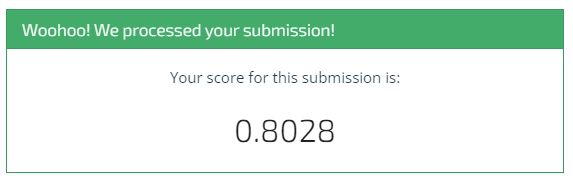

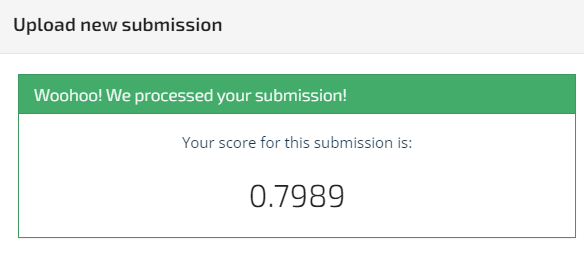

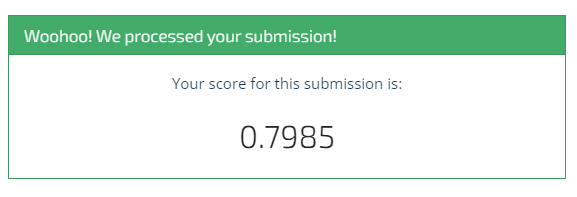